<a href="https://colab.research.google.com/github/dafsotomo/COVID19/blob/master/COVID19_Completo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install wget
import wget
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score
from joblib import dump, load
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error as mae
from sklearn.gaussian_process import GaussianProcessRegressor as GaussianProcess

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=921a8afa040f93c4d07b8876b69e62342900c90d40fa6194bd04ba2e6cf3292f
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


# Importacion de base de datos actualizada

Para el desarrollo de este notebook, se utiliza la base de datos 'NOVEL Coronavirus 2019 dataset' cargada por SRK en la página Kaggle la cual contiene 6 dasets en formato '.csv'con informacion de contagiados acumulados de CORONAVIRUS al rededor del mundo. La base de datos se actualiza todas las noches, por lo tanto, el set de datos analizado en este notebook estará siempre actualizado hasta el dia anterior.

In [2]:
#datos covid19 - mundo
url = "https://data.humdata.org/hxlproxy/api/data-preview.csv?url=https%3A%2F%2Fraw.githubusercontent.com%2FCSSEGISandData%2FCOVID-19%2Fmaster%2Fcsse_covid_19_data%2Fcsse_covid_19_time_series%2Ftime_series_covid19_confirmed_global.csv&filename=time_series_covid19_confirmed_global.csv"
#datos Colombia
#url = "https://www.datos.gov.co/api/views/gt2j-8ykr/rows.csv?accessType=DOWNLOAD"
wget.download(url, 'covid.csv')
Xd = pd.read_csv('covid.csv')
Xd

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20,4/30/20,5/1/20,5/2/20,5/3/20,5/4/20,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20,5/18/20,5/19/20,5/20/20,5/21/20,5/22/20,5/23/20,5/24/20,5/25/20,5/26/20,5/27/20,5/28/20,5/29/20
0,NaN,Afghanistan,33.000000,65.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,...,1026,1092,1176,1279,1351,1463,1531,1703,1828,1939,2171,2335,2469,2704,2894,3224,3392,3563,3778,4033,4402,4687,4963,5226,5639,6053,6402,6664,7072,7653,8145,8676,9216,9998,10582,11173,11831,12456,13036,13659
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,584,609,634,663,678,712,726,736,750,766,773,782,789,795,803,820,832,842,850,856,868,872,876,880,898,916,933,946,948,949,964,969,981,989,998,1004,1029,1050,1076,1099
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,2718,2811,2910,3007,3127,3256,3382,3517,3649,3848,4006,4154,4295,4474,4648,4838,4997,5182,5369,5558,5723,5891,6067,6253,6442,6629,6821,7019,7201,7377,7542,7728,7918,8113,8306,8503,8697,8857,8997,9134
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,717,717,723,723,731,738,738,743,743,743,745,745,747,748,750,751,751,752,752,754,755,755,758,760,761,761,761,761,761,761,762,762,762,762,762,763,763,763,763,764
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,24,24,25,25,25,25,26,27,27,27,27,30,35,35,35,36,36,36,43,43,45,45,45,45,48,48,48,48,50,52,52,58,60,61,69,70,70,71,74,81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,NaN,Sao Tome and Principe,0.186360,6.613081,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,4,4,4,4,4,4,4,4,8,8,14,16,16,16,23,174,174,187,208,208,208,208,208,220,235,235,235,235,246,251,251,251,251,251,251,299,441,443,458,463
262,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,6,6,7,10,10,12,22,25,25,34,34,51,56,65,70,85,106,122,128,130,167,184,197,209,212,222,233,249,256,278,283
263,NaN,Comoros,-11.645500,43.333300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,1,3,3,3,3,8,8,8,11,11,11,11,11,11,11,11,11,11,11,34,34,78,78,87,87,87,87,87,87
264,NaN,Tajikistan,38.861034,71.276093,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,15,15,76,128,230,293,379,461,522,612,612,661,729,801,907,1118,1322,1524,1729,1936,2140,2350,2551,2738,2929,3100,3266,3424,3563,3686


# Datos Colombia.

## Reporte de casos acumulados por dia.

## Preprocesamiento.

Definicion de funcion que realiza un barrido por todos los datos de un determinado pais y obtiene vectores de n dias predefinidos siendo la salida el dia n+1. Arma la matriz de entrenamiento y el vector de salida para el regresor.

In [0]:
#funcion ventaneo
def covid_win(serie,w=5):
    pi =0
    pf = w
    X = serie[pi:pf].reshape(1,-1)
    y = serie[pf+1].reshape(1,-1)
    pi += 1
    pf+= 1
    while pf+1 < serie.shape[0]:
      X = np.append(X,serie[pi:pf].reshape(1,-1),axis=0)
      y = np.append(y,serie[pf+1].reshape(1,-1),axis=0)
      pi += 1
      pf+=1
    return X, y # X \in Real^{N x P = w}, y \in Real^N

# Análisis Exploratorio

Contagiados acumulados y reporte de nuevos casos para el dia de ayer segun la base de datos:

In [4]:
hoy = datetime.datetime.now().date()
ayer = hoy - datetime.timedelta(days=1)
mañana = hoy + datetime.timedelta(days=1)
ii = Xd[Xd.columns[1]] == 'Colombia'

#contagios  acumulados
serie = np.array(Xd.iloc[np.where(ii)[0][0],4:])

#numero contagiados por dia
serie_d = np.append(0,np.diff(serie))

print('Contagiados acumulados', ayer,':', serie[-1])
print('Nuevos casos',ayer,':', serie_d[-1])

Contagiados acumulados 2020-05-29 : 25406
Nuevos casos 2020-05-29 : 1265


### Gráficas de contagios

In [0]:
X,y = covid_win(serie,w=5)
X_d,y_d = covid_win(serie_d,w=5)
figsize=[18,4]
title_acum='Acumulado de contagios'
title_day='Contagiados por dia'

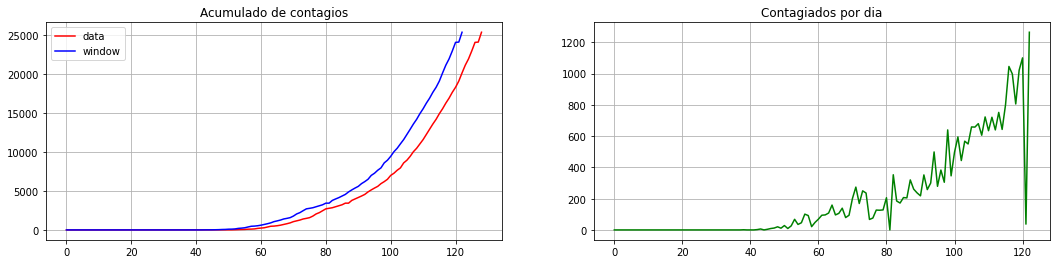

In [6]:
plt.figure(figsize=figsize)

plt.subplot(121)
plt.plot(serie,'r',label='data')
plt.plot(y,'b',label='window')
plt.legend()
plt.title(title_acum)
plt.grid()

plt.subplot(122)
plt.plot(y_d,'g')
plt.title(title_day)
plt.grid()

### Visualizacion en 2D PCA y TSNE

Text(0.5, 1.0, 'Contagiados por dia')

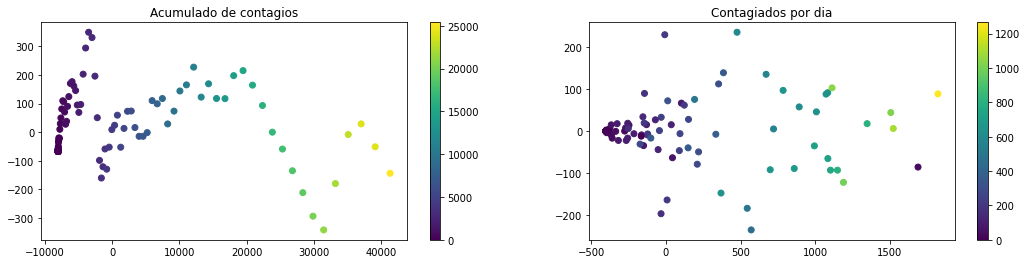

In [7]:
red_PCA = PCA (n_components=2)
red_d_PCA = PCA(n_components=2)

z_PCA = red_PCA.fit_transform(X)
z_d_PCA = red_d_PCA.fit_transform(X_d)

plt.figure(figsize=figsize)

plt.subplot(121)
plt.scatter(z_PCA[:,0],z_PCA[:,1],c=y)
plt.colorbar()
plt.title(title_acum)

plt.subplot(122)
plt.scatter(z_d_PCA[:,0],z_d_PCA[:,1],c=y_d)
plt.colorbar()
plt.title(title_day)

Text(0.5, 1.0, 'Contagiados por dia')

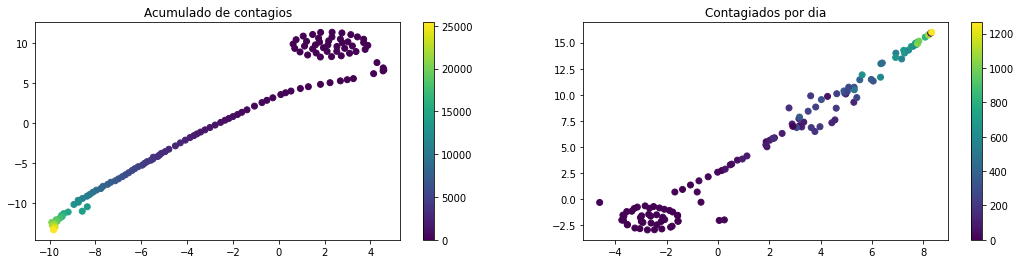

In [8]:
from sklearn.manifold import TSNE

perplexity=20

red_TSNE = TSNE(n_components = 2, perplexity=perplexity)
red_d_TSNE = TSNE(n_components = 2, perplexity=perplexity)

z_TSNE = red_TSNE.fit_transform(X)
z_d_TSNE = red_d_TSNE.fit_transform(X_d)

plt.figure(figsize=figsize)

plt.subplot(121)
plt.scatter(z_TSNE[:,0],z_TSNE[:,1],c=y)
plt.colorbar()
plt.title(title_acum)

plt.subplot(122)
plt.scatter(z_d_TSNE[:,0],z_d_TSNE[:,1],c=y_d)
plt.colorbar()
plt.title(title_day)

# Validación cruzada y anidada - Contagios por dia 

Consultar el funcionamiento (modelo matemático, función de costo y optimización) de los siguientes algoritmos segun su implementacion en el paquete scikit-learn de Python 

* sklearn.linear_model.LinearRegression
* sklearn.linear_model.Ridge
* sklearn.linear_model.Lasso
* sklearn.linear_model.ElasticNet
* KernelRidge
* Gaussian Process

Utilizando la base de datos del COVID-19 realice un análisis comparativo de los métodos de regression mediante validación cruzada. Recuerde sintonizar los parámetros libres de cada algoritmo utilizando búsqueda por grilla y búsqueda aleatoria.

In [0]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.kernel_ridge import KernelRidge

steps = [[('scaler', StandardScaler()), 
          ('rep',PCA()),
         ('reg', LinearRegression())],
         
         [('scaler', StandardScaler()),
         ('rep',PCA()),
         ('reg',Ridge())],
         
         [('scaler', StandardScaler()),
         ('rep',PCA()),
         ('reg',Lasso())],
         
         [('scaler', StandardScaler()),
         ('rep',PCA()),
         ('reg',ElasticNet())],
         
         [('scaler', StandardScaler()),
          ('rep',PCA()),
         ('reg', KernelRidge(kernel='rbf'))],
         
        [('scaler', StandardScaler()),
          ('rep',PCA()),
         ('reg', GaussianProcess())]
        ]

#parametros a buscar por busqueda por grilla
parameters =[{'rep__n_components' : [0.5,0.75,0.9],
             'reg__fit_intercept' : [True,False]},
             
             {'rep__n_components' : [0.5,0.75,0.9],
             'reg__alpha' : [1e-3,1e-2,1e-1,1,10,100],
             'reg__tol' : [1e-5,1e-4,1e-3,1e-2,1e-1,1]},
             
             {'rep__n_components' : [0.5,0.75,0.9],
             'reg__alpha' : [1e-3,1e-2,1e-1,1,10,100],
             'reg__warm_start' : [True,False],
             'reg__selection' : ['cyclic','random']},
             
             {'rep__n_components' : [0.5,0.75,0.9],
             'reg__alpha' : [1e-3,1e-2,1e-1,1,10,100],
             'reg__l1_ratio' : [1e-3,1e-2,1e-1,1,10,100],
             'reg__warm_start' : [True,False],
             'reg__selection' : ['cyclic','random']},
             
             {'rep__n_components': [0.5,0.75,0.9],
              'reg__gamma' : [1e-3,1e-2,1e-1,1,10,100],
             'reg__alpha' : [1e-3,1e-2,1e-1,1,10,100]},
            
             {'rep__n_components': [0.5,0.75,0.9],
              #'reg__kernel' : [None, 'rbf'],
             'reg__alpha' : [1e-3,1e-2,1e-1,1,10,100]}            
            ]

label_model=['NorSC-PCA-LR', 'NorSC-PCA-R', 'NorSC-PCA-L', 'NorSC-PCA-EN', 'NorSC-PCA-KR(rbf)', 'NorSC - PCA-GPR']

In [10]:
ii = Xd[Xd.columns[1]] == 'Colombia'
serie_d = np.append(0,np.diff(np.array(Xd.iloc[np.where(ii)[0][0],4:])))
window=11

Niter = 10 
maev = np.zeros ( (Niter,len(steps),window-3) )

min_it=1e10;         be_it=steps[0];            bhp_it=parameters[0]

win_mae_w = [];      win_estimators_w = [];     win_hyperparams_w = []

win_mae_it = [];     win_estimators_it = [];    win_hyperparams_it = []
    

for k in range(3,window):
    
    X_d,y_d = covid_win(serie_d,w=k)
    
    for j in range (Niter):

        X_train, X_test, y_train, y_test =train_test_split(X_d,y_d, test_size=0.2)

        for r in range (len(steps)):

            grid_search = GridSearchCV(Pipeline(steps[r]), parameters[r], cv=5, verbose=10, scoring='neg_mean_absolute_error', n_jobs=5) 
            grid_search.fit(X_train, y_train)

            y_pred = grid_search.best_estimator_.predict(X_test)

            # Guardar acierto
            maev[j,r,k-3] = mae(y_test, y_pred)

            if (maev[j,r,k-3] < min_it):
                min_it = maev[j,r,k-3]
                be_it = grid_search.best_estimator_
                bhp_it = grid_search.best_params_
                
            print('Ventana: %d/%d \nIteracion: %d/%d \nError absoluto para Modelo %d/%d:' 
                  %(      k,window-1,       j+1,Niter,                        r+1,len(steps)),         maev[j,r,k-3] )

        print('__________________________________________________________________')
        print ('estimador con menor error absoluto para it %d/%d: '%(j+1,Niter));   print(be_it) 
        print('Mejores hyperparametros: ',bhp_it)
        print('Error absoluto: %f'%min_it)
        print('__________________________________________________________________')
            
        win_estimators_it.append(be_it)
        win_hyperparams_it.append(bhp_it)
        win_mae_it.append(min_it)
        min_it=1e10
    
    print(win_mae_it)
    min=1e10
    pos_min = 0
    for i in range (len(win_mae_it)):
        if (win_mae_it[i] < min):
            min = win_mae_it[i]
            pos_min = i

    win_estimators_w.append(win_estimators_it[pos_min])
    win_hyperparams_w.append(win_hyperparams_it[pos_min])
    win_mae_w.append(win_mae_it[pos_min])
    print('__________________________________________________________________')
    print ('estimador con menor error absoluto para ventana %d/%d: ' %(k,window-1))
    print(win_estimators_it[pos_min]) 
    print('Mejores hyperparametros: ')
    print(win_hyperparams_it[pos_min])
    print('Error absoluto para ventana: %f' %win_mae_it[pos_min])
    print('__________________________________________________________________')
    
    win_estimators_it = []
    win_hyperparams_it = []
    win_mae_it = []

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    2.6s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    2.7s
[Parallel(n_jobs=5)]: Done  15 tasks      | elapsed:    2.7s
[Parallel(n_jobs=5)]: Done  25 out of  30 | elapsed:    2.8s remaining:    0.6s
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    2.8s finished


Ventana: 3/10 
Iteracion: 1/10 
Error absoluto para Modelo 1/6: 74.92533094394251
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0125s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0556s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0765s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1282s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 485 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 498 tasks      | ela

Ventana: 3/10 
Iteracion: 1/10 
Error absoluto para Modelo 2/6: 74.92491284912083
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0621s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1075s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1236s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 281 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 292 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0122s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks  

Ventana: 3/10 
Iteracion: 1/10 
Error absoluto para Modelo 3/6: 74.92508431500835
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0922s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1331s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.1s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    4.0s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    5.0s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    6.1s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    7.0s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    8.3s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.7s finished
[Parallel(n_jobs=5)]: Using

Ventana: 3/10 
Iteracion: 1/10 
Error absoluto para Modelo 4/6: 75.4614158527168
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1415s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 238 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 430 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 499 tasks      | elapsed:    2.5s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.6s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0293s.) Setting batch_size=2.


Ventana: 3/10 
Iteracion: 1/10 
Error absoluto para Modelo 5/6: 75.54704772383208
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0795s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1337s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  68 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  80 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0156s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0553s.) Setting batch_size=4.


Ventana: 3/10 
Iteracion: 1/10 
Error absoluto para Modelo 6/6: 69.82346597771576
__________________________________________________________________
estimador con menor error absoluto para it 1/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 GaussianProcessRegressor(alpha=0.001, copy_X_train=True,
                                          kernel=None, n_restarts_optimizer=0,
                                          normalize_y=False,
                                          optimizer='fmin_l_bfgs_b',
                                          random_state=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'rep__n_components': 0.5}
Error

[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0113s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0625s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0932s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1138s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 442 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 470 tasks  

Ventana: 3/10 
Iteracion: 2/10 
Error absoluto para Modelo 2/6: 36.24798369374949
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0949s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1708s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 307 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0129s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0710s.)

Ventana: 3/10 
Iteracion: 2/10 
Error absoluto para Modelo 3/6: 36.24784415337598
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0780s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1367s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.6s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.2s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    4.2s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    5.1s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    6.2s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    7.2s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    8.5s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.9s finished
[Parallel(n_jobs=5)]: Using

Ventana: 3/10 
Iteracion: 2/10 
Error absoluto para Modelo 4/6: 33.09653103375143
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1247s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  74 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 162 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 306 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 482 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0115s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0115s.) Setting batch_size=4.


Ventana: 3/10 
Iteracion: 2/10 
Error absoluto para Modelo 5/6: 30.945963795002317
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  14 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0815s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.5s finished


Ventana: 3/10 
Iteracion: 2/10 
Error absoluto para Modelo 6/6: 37.18944681354686
__________________________________________________________________
estimador con menor error absoluto para it 2/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 KernelRidge(alpha=0.001, coef0=1, degree=3, gamma=0.001,
                             kernel='rbf', kernel_params=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'reg__gamma': 0.001, 'rep__n_components': 0.5}
Error absoluto: 30.945964
__________________________________________________________________
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Ventana: 3/10 
Iteracion: 3/10 
Error 

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0123s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0123s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0137s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0137s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0702s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Par

Ventana: 3/10 
Iteracion: 3/10 
Error absoluto para Modelo 2/6: 86.33386081035164
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1446s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1425s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 307 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0122s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1

Ventana: 3/10 
Iteracion: 3/10 
Error absoluto para Modelo 3/6: 86.5891680368658
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1465s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1543s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.5s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.2s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    4.1s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    5.1s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.9s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.9s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    8.3s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_j

Ventana: 3/10 
Iteracion: 3/10 
Error absoluto para Modelo 4/6: 86.33438346245119
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1470s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 238 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 430 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 492 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0321s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0321s.) Setting batch_size=4.


Ventana: 3/10 
Iteracion: 3/10 
Error absoluto para Modelo 5/6: 85.2364018349447
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1034s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0119s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0119s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   5 out of  30 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=5)]: Done   9 out of  30 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0120s.) Setting batch_size=2.


Ventana: 3/10 
Iteracion: 3/10 
Error absoluto para Modelo 6/6: 87.31652552091893
__________________________________________________________________
estimador con menor error absoluto para it 3/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 KernelRidge(alpha=0.01, coef0=1, degree=3, gamma=0.001,
                             kernel='rbf', kernel_params=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.01, 'reg__gamma': 0.001, 'rep__n_components': 0.5}
Error absoluto: 85.236402
__________________________________________________________________
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Ventana: 3/10 
Iteracion: 4/10 
Error ab

[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0632s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0951s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1191s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]:

Ventana: 3/10 
Iteracion: 4/10 
Error absoluto para Modelo 2/6: 37.96103223302733
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1372s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1516s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    1.0s
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 322 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0201s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1

Ventana: 3/10 
Iteracion: 4/10 
Error absoluto para Modelo 3/6: 37.96085103628707
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0995s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1122s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.5s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.2s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    4.1s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    5.1s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    6.1s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    7.0s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    8.4s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.7s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_j

Ventana: 3/10 
Iteracion: 4/10 
Error absoluto para Modelo 4/6: 32.377444293763816
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1277s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1788s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 485 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0119s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0119s.)

Ventana: 3/10 
Iteracion: 4/10 
Error absoluto para Modelo 5/6: 35.650927382851954
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0603s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  23 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0090s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0469s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0173s.) Setting batch_size=2.


Ventana: 3/10 
Iteracion: 4/10 
Error absoluto para Modelo 6/6: 38.07147704364038
__________________________________________________________________
estimador con menor error absoluto para it 4/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 ElasticNet(alpha=0.001, copy_X=True, fit_intercept=True,
                            l1_ratio=100, max_iter=1000, normalize=False,
                            positive=False, precompute=False, random_state=None,
                            selection='cyclic', tol=0.0001, warm_start=True))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'reg__l1_ratio': 100, 'reg__selection': 'cyclic', 'reg__warm_start': 

[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0614s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0859s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1330s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]:

Ventana: 3/10 
Iteracion: 5/10 
Error absoluto para Modelo 2/6: 94.93412777068919
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0602s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1237s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1435s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 296 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 307 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0284s.)

Ventana: 3/10 
Iteracion: 5/10 
Error absoluto para Modelo 3/6: 94.93397887423795
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1985s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.0s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    4.0s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    4.9s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.9s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.9s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    8.2s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0125s.) Setting batch_size=2.
[Parallel(n_j

Ventana: 3/10 
Iteracion: 5/10 
Error absoluto para Modelo 4/6: 94.56803514818803
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1158s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1633s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    1.0s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 455 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.5s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0234s.) Setting batch_size=2

Ventana: 3/10 
Iteracion: 5/10 
Error absoluto para Modelo 5/6: 94.98028595482988
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1004s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1033s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  65 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  80 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0104s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0104s.) Setting batch_size=4.


Ventana: 3/10 
Iteracion: 5/10 
Error absoluto para Modelo 6/6: 99.62950187231414
__________________________________________________________________
estimador con menor error absoluto para it 5/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 ElasticNet(alpha=0.001, copy_X=True, fit_intercept=True,
                            l1_ratio=10, max_iter=1000, normalize=False,
                            positive=False, precompute=False, random_state=None,
                            selection='cyclic', tol=0.0001, warm_start=True))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'reg__l1_ratio': 10, 'reg__selection': 'cyclic', 'reg__warm_start': Tr

[Parallel(n_jobs=5)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0141s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0722s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0528s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 238 tasks      | elapsed:    1.1s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 430 tasks      | elapsed:    1.8s

Ventana: 3/10 
Iteracion: 6/10 
Error absoluto para Modelo 2/6: 61.4695233508418
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0845s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0954s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1205s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 307 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0140s.)

Ventana: 3/10 
Iteracion: 6/10 
Error absoluto para Modelo 3/6: 61.46942257495685
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1344s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1712s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.5s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.1s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    4.0s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    4.9s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.9s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.8s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    8.0s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_j

Ventana: 3/10 
Iteracion: 6/10 
Error absoluto para Modelo 4/6: 58.70409307361872
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0918s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1549s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 442 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0171s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0

Ventana: 3/10 
Iteracion: 6/10 
Error absoluto para Modelo 5/6: 61.08763354733237
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0860s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0909s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  73 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  82 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0111s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0759s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  30 out of  

Ventana: 3/10 
Iteracion: 6/10 
Error absoluto para Modelo 6/6: 64.83769244724928
__________________________________________________________________
estimador con menor error absoluto para it 6/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 ElasticNet(alpha=0.001, copy_X=True, fit_intercept=True,
                            l1_ratio=100, max_iter=1000, normalize=False,
                            positive=False, precompute=False, random_state=None,
                            selection='cyclic', tol=0.0001, warm_start=True))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'reg__l1_ratio': 100, 'reg__selection': 'cyclic', 'reg__warm_start': 

[Parallel(n_jobs=5)]: Batch computation too fast (0.0268s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0413s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1190s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1967s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 442 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 485 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.0s


Ventana: 3/10 
Iteracion: 7/10 
Error absoluto para Modelo 2/6: 55.19523674431273
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0554s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1000s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1449s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 281 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 292 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0174s.)

Ventana: 3/10 
Iteracion: 7/10 
Error absoluto para Modelo 3/6: 55.19506679172956
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1173s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1622s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.0s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    4.0s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    4.8s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.8s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.8s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    8.1s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.5s finished
[Parallel(n_jobs=5)]: Using

Ventana: 3/10 
Iteracion: 7/10 
Error absoluto para Modelo 4/6: 50.353931815470034
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0861s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 238 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 430 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 499 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.5s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0222s.) Setting batch_size=2.


Ventana: 3/10 
Iteracion: 7/10 
Error absoluto para Modelo 5/6: 50.8548725357838
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1158s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0865s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  80 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0081s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0081s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of  30 | elapsed:    0.1s remaining:    0.4s


Ventana: 3/10 
Iteracion: 7/10 
Error absoluto para Modelo 6/6: 43.2976955835463
__________________________________________________________________
estimador con menor error absoluto para it 7/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 GaussianProcessRegressor(alpha=0.001, copy_X_train=True,
                                          kernel=None, n_restarts_optimizer=0,
                                          normalize_y=False,
                                          optimizer='fmin_l_bfgs_b',
                                          random_state=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'rep__n_components': 0.5}
Error 

[Parallel(n_jobs=5)]: Done   9 out of  30 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=5)]: Done  13 out of  30 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=5)]: Done  17 out of  30 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0170s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0533s.) Setting batch_size=4.


Ventana: 3/10 
Iteracion: 8/10 
Error absoluto para Modelo 1/6: 72.82752484377676
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1070s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1782s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    1.0s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 442 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 485 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0122s.) Setting batch_size=2

Ventana: 3/10 
Iteracion: 8/10 
Error absoluto para Modelo 2/6: 72.82811837475728
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0567s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0892s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1729s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 251 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 292 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0145s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks  

Ventana: 3/10 
Iteracion: 8/10 
Error absoluto para Modelo 3/6: 72.82796280699714
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0965s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1865s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    1.0s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.5s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.1s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    4.1s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    5.0s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    6.0s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.9s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    8.1s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_j

Ventana: 3/10 
Iteracion: 8/10 
Error absoluto para Modelo 4/6: 66.7878780200641
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1009s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 238 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 430 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 499 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0165s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0165s.) Setting batch_size=4.


Ventana: 3/10 
Iteracion: 8/10 
Error absoluto para Modelo 5/6: 78.12558691627346
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1660s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  70 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  81 out of  90 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0083s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0374s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using back

Ventana: 3/10 
Iteracion: 8/10 
Error absoluto para Modelo 6/6: 92.42989905466332
__________________________________________________________________
estimador con menor error absoluto para it 8/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 ElasticNet(alpha=0.001, copy_X=True, fit_intercept=True,
                            l1_ratio=100, max_iter=1000, normalize=False,
                            positive=False, precompute=False, random_state=None,
                            selection='cyclic', tol=0.0001, warm_start=True))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'reg__l1_ratio': 100, 'reg__selection': 'cyclic', 'reg__warm_start': 

[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0587s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1080s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1273s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]:

Ventana: 3/10 
Iteracion: 9/10 
Error absoluto para Modelo 2/6: 37.21940809496189
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0609s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1178s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1383s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 281 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 292 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0127s.)

Ventana: 3/10 
Iteracion: 9/10 
Error absoluto para Modelo 3/6: 37.21932411399353
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1269s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1343s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    1.0s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.1s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    4.0s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    5.0s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.9s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.8s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    8.0s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_j

Ventana: 3/10 
Iteracion: 9/10 
Error absoluto para Modelo 4/6: 35.45648267119887
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1181s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1492s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    1.0s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0209s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0209s.)

Ventana: 3/10 
Iteracion: 9/10 
Error absoluto para Modelo 5/6: 38.17213846833823
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1322s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  50 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  71 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  81 out of  90 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Ventana: 3/10 
Iteracion: 9/10 
Error absoluto para Modelo 6/6: 39.579693130587756
__________________________________________________________________
estimador con menor error absoluto para it 9/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 ElasticNet(alpha=0.001, copy_X=True, fit_intercept=True,
                            l1_ratio=100, max_iter=1000, normalize=False,
                            positive=False, precompute=False, random_state=None,
                            selection='cyclic', tol=0.0001, warm_start=True))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'reg__l1_ratio': 100, 'reg__selection': 'cyclic', 'reg__warm_start':

[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0134s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0134s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   9 out of  30 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0123s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0509s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0838s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s

Ventana: 3/10 
Iteracion: 10/10 
Error absoluto para Modelo 2/6: 53.982004115728635
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0602s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0799s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1418s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 292 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0194s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks  

Ventana: 3/10 
Iteracion: 10/10 
Error absoluto para Modelo 3/6: 53.981886521639574
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1115s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1854s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.0s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    3.9s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    4.8s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.7s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.6s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    7.9s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.2s finished
[Parallel(n_jobs=5)]: Using

Ventana: 3/10 
Iteracion: 10/10 
Error absoluto para Modelo 4/6: 50.735947169860395
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1000s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 238 tasks      | elapsed:    1.1s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 430 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 499 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Ventana: 3/10 
Iteracion: 10/10 
Error absoluto para Modelo 5/6: 50.69670579756523
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0399s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0856s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1088s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  68 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  80 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0138s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0138s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5

Ventana: 3/10 
Iteracion: 10/10 
Error absoluto para Modelo 6/6: 43.466217366464974
__________________________________________________________________
estimador con menor error absoluto para it 10/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 GaussianProcessRegressor(alpha=0.1, copy_X_train=True,
                                          kernel=None, n_restarts_optimizer=0,
                                          normalize_y=False,
                                          optimizer='fmin_l_bfgs_b',
                                          random_state=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.1, 'rep__n_components': 0.5}
Error 

[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0118s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0610s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0898s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 238 tasks      | elapsed:    1.1s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 430 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 499 tasks      | elapsed:    2.0s

Ventana: 4/10 
Iteracion: 1/10 
Error absoluto para Modelo 2/6: 36.0811443275292
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1263s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1450s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    1.0s
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 307 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0124s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0548s.)

Ventana: 4/10 
Iteracion: 1/10 
Error absoluto para Modelo 3/6: 36.081116928684466
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1511s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1256s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.1s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    4.0s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    5.0s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    6.0s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.9s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    8.2s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.6s finished
[Parallel(n_jobs=5)]: Using

Ventana: 4/10 
Iteracion: 1/10 
Error absoluto para Modelo 4/6: 35.18947618374906
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0846s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1304s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    1.0s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0124s.) Setting batch_size=2

Ventana: 4/10 
Iteracion: 1/10 
Error absoluto para Modelo 5/6: 32.720553250921654
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0907s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0088s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0088s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0123s.) Setting batch_size=2.


Ventana: 4/10 
Iteracion: 1/10 
Error absoluto para Modelo 6/6: 33.63238890927165
__________________________________________________________________
estimador con menor error absoluto para it 1/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 KernelRidge(alpha=0.001, coef0=1, degree=3, gamma=0.001,
                             kernel='rbf', kernel_params=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'reg__gamma': 0.001, 'rep__n_components': 0.5}
Error absoluto: 32.720553
__________________________________________________________________
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Ventana: 4/10 
Iteracion: 2/10 
Error 

[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0635s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1023s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1177s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 455 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]:

Ventana: 4/10 
Iteracion: 2/10 
Error absoluto para Modelo 2/6: 49.872601750106384
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0667s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0732s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 238 tasks      | elapsed:    1.1s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 351 out of 360 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0130s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation t

Ventana: 4/10 
Iteracion: 2/10 
Error absoluto para Modelo 3/6: 49.872563085388805
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0920s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1303s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.5s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.1s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    4.0s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    5.0s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.9s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.8s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    8.2s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.5s finished
[Parallel(n_jobs=5)]: Using

Ventana: 4/10 
Iteracion: 2/10 
Error absoluto para Modelo 4/6: 48.17244705182952
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1159s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 238 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 430 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 499 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.5s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0115s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0115s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0s


Ventana: 4/10 
Iteracion: 2/10 
Error absoluto para Modelo 5/6: 311.6804284379172
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1295s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0086s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0086s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   9 out of  30 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished


Ventana: 4/10 
Iteracion: 2/10 
Error absoluto para Modelo 6/6: 424.88605406641886
__________________________________________________________________
estimador con menor error absoluto para it 2/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 ElasticNet(alpha=0.001, copy_X=True, fit_intercept=True,
                            l1_ratio=100, max_iter=1000, normalize=False,
                            positive=False, precompute=False, random_state=None,
                            selection='cyclic', tol=0.0001, warm_start=True))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'reg__l1_ratio': 100, 'reg__selection': 'cyclic', 'reg__warm_start':

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0150s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0564s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0914s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1532s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 442 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 498 tasks      | ela

Ventana: 4/10 
Iteracion: 3/10 
Error absoluto para Modelo 2/6: 42.63220392516353
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0626s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1081s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  74 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 162 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 246 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 302 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 313 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 339 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0160s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0

Ventana: 4/10 
Iteracion: 3/10 
Error absoluto para Modelo 3/6: 42.63218917889779
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0652s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1307s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1369s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.6s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.1s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    4.0s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    5.0s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    6.0s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    7.0s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    8.2s
[Parallel(n_jobs=

Ventana: 4/10 
Iteracion: 3/10 
Error absoluto para Modelo 4/6: 42.60070376908317
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1473s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1815s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    1.0s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 455 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.5s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0119s.) Setting batch_size=2

Ventana: 4/10 
Iteracion: 3/10 
Error absoluto para Modelo 5/6: 51.97531987620634
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done  24 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0096s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0096s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of  30 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=5)]: Done   9 out of  30 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=5)]: Done  13 out of  30 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=5)]: Done  17 out of  30 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=5)]: Done  21 out of  30 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Ba

Ventana: 4/10 
Iteracion: 3/10 
Error absoluto para Modelo 6/6: 67.7926895018438
__________________________________________________________________
estimador con menor error absoluto para it 3/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 ElasticNet(alpha=0.001, copy_X=True, fit_intercept=True,
                            l1_ratio=100, max_iter=1000, normalize=False,
                            positive=False, precompute=False, random_state=None,
                            selection='cyclic', tol=0.0001, warm_start=True))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'reg__l1_ratio': 100, 'reg__selection': 'cyclic', 'reg__warm_start': T

[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0531s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1230s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1123s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]:

Ventana: 4/10 
Iteracion: 4/10 
Error absoluto para Modelo 2/6: 78.18661032816888
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0543s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1032s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1608s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 281 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 307 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0127s.)

Ventana: 4/10 
Iteracion: 4/10 
Error absoluto para Modelo 3/6: 78.16566759192398
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0954s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1769s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.0s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    3.9s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    4.9s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.9s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.9s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    8.1s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_j

Ventana: 4/10 
Iteracion: 4/10 
Error absoluto para Modelo 4/6: 78.16566759192398
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1580s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1494s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0180s.) Setting batch_size=2.


Ventana: 4/10 
Iteracion: 4/10 
Error absoluto para Modelo 5/6: 78.08542036803628
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0912s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  26 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1586s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  48 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  71 out of  90 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=5)]: Done  81 out of  90 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0239s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0724s.) Setting batch_size=4.


Ventana: 4/10 
Iteracion: 4/10 
Error absoluto para Modelo 6/6: 81.19923376078222
__________________________________________________________________
estimador con menor error absoluto para it 4/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 KernelRidge(alpha=0.01, coef0=1, degree=3, gamma=0.001,
                             kernel='rbf', kernel_params=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.01, 'reg__gamma': 0.001, 'rep__n_components': 0.5}
Error absoluto: 78.085420
__________________________________________________________________
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0139s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0626s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s


Ventana: 4/10 
Iteracion: 5/10 
Error absoluto para Modelo 1/6: 50.38697577363196
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1097s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1011s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0128s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0

Ventana: 4/10 
Iteracion: 5/10 
Error absoluto para Modelo 2/6: 50.3872523537816
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0731s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1191s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1382s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    1.0s
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 292 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0189s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks  

Ventana: 4/10 
Iteracion: 5/10 
Error absoluto para Modelo 3/6: 50.38718747478228
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1098s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1657s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.1s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    4.0s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    5.0s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.9s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.9s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    8.2s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_j

Ventana: 4/10 
Iteracion: 5/10 
Error absoluto para Modelo 4/6: 47.90684366244033
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  86 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 158 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 246 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 334 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 438 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 500 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 531 out of 540 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0118s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0118s.) Setting batch_size=4.


Ventana: 4/10 
Iteracion: 5/10 
Error absoluto para Modelo 5/6: 51.84357855124418
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0754s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.5s finished


Ventana: 4/10 
Iteracion: 5/10 
Error absoluto para Modelo 6/6: 84.09649051820112
__________________________________________________________________
estimador con menor error absoluto para it 5/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 ElasticNet(alpha=0.001, copy_X=True, fit_intercept=True,
                            l1_ratio=100, max_iter=1000, normalize=False,
                            positive=False, precompute=False, random_state=None,
                            selection='cyclic', tol=0.0001, warm_start=True))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'reg__l1_ratio': 100, 'reg__selection': 'cyclic', 'reg__warm_start': 

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0127s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0127s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   9 out of  30 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0123s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0123s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1122s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  34 tasks      | el

Ventana: 4/10 
Iteracion: 6/10 
Error absoluto para Modelo 2/6: 42.75860194133611
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0793s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1125s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  66 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 146 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 245 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 271 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 312 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 325 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 338 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Ventana: 4/10 
Iteracion: 6/10 
Error absoluto para Modelo 3/6: 42.75851997360892
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0154s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0154s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0968s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1372s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  74 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 162 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 306 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 482 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 658 tasks      | elapsed:    3.0s
[Parallel(n_jobs=5)]: Done 866 tasks      | elapsed:    3.6s
[Parallel(n_jobs=5)]: Done 1074 tasks      | elapsed:    4.5s
[Parallel(n_jobs=5)]: Done 1314 tasks      | elapsed:    5.4

Ventana: 4/10 
Iteracion: 6/10 
Error absoluto para Modelo 4/6: 40.02619578054936
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Done  50 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 102 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 174 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 262 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 350 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 454 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 509 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 531 out of 540 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0239s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0836s.) Setting batch_size=4.


Ventana: 4/10 
Iteracion: 6/10 
Error absoluto para Modelo 5/6: 40.17371268919276
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1767s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  65 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  80 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0103s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0103s.) Setting batch_size=4.


Ventana: 4/10 
Iteracion: 6/10 
Error absoluto para Modelo 6/6: 40.14925298550108
__________________________________________________________________
estimador con menor error absoluto para it 6/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 ElasticNet(alpha=0.001, copy_X=True, fit_intercept=True,
                            l1_ratio=100, max_iter=1000, normalize=False,
                            positive=False, precompute=False, random_state=None,
                            selection='cyclic', tol=0.0001, warm_start=True))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'reg__l1_ratio': 100, 'reg__selection': 'cyclic', 'reg__warm_start': 

[Parallel(n_jobs=5)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0118s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0682s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0955s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1624s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 427 tasks  

Ventana: 4/10 
Iteracion: 7/10 
Error absoluto para Modelo 2/6: 37.84576086842721
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0695s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1404s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0959s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    1.0s
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 292 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0261s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks  

Ventana: 4/10 
Iteracion: 7/10 
Error absoluto para Modelo 3/6: 37.84567201200273
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0861s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1199s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.2s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    4.0s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    5.0s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    6.0s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    7.0s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    8.1s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.5s finished
[Parallel(n_jobs=5)]: Using

Ventana: 4/10 
Iteracion: 7/10 
Error absoluto para Modelo 4/6: 35.00438613474036
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1272s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1232s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 455 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0224s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0

Ventana: 4/10 
Iteracion: 7/10 
Error absoluto para Modelo 5/6: 35.201856778903746
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0698s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0781s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  65 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  77 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0135s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0713s.) Setting batch_size=4.


Ventana: 4/10 
Iteracion: 7/10 
Error absoluto para Modelo 6/6: 35.343519451289765
__________________________________________________________________
estimador con menor error absoluto para it 7/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 ElasticNet(alpha=0.001, copy_X=True, fit_intercept=True,
                            l1_ratio=100, max_iter=1000, normalize=False,
                            positive=False, precompute=False, random_state=None,
                            selection='cyclic', tol=0.0001, warm_start=True))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'reg__l1_ratio': 100, 'reg__selection': 'cyclic', 'reg__warm_start':

[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0194s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0785s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s


Ventana: 4/10 
Iteracion: 8/10 
Error absoluto para Modelo 1/6: 37.13987997200954
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0682s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1696s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 485 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0117s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0

Ventana: 4/10 
Iteracion: 8/10 
Error absoluto para Modelo 2/6: 37.14013434468346
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0574s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1086s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1304s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 251 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 307 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0084s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computatio

Ventana: 4/10 
Iteracion: 8/10 
Error absoluto para Modelo 3/6: 37.14006101419009
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1802s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  74 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 162 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 306 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 482 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 658 tasks      | elapsed:    3.0s
[Parallel(n_jobs=5)]: Done 866 tasks      | elapsed:    3.7s
[Parallel(n_jobs=5)]: Done 1074 tasks      | elapsed:    4.6s
[Parallel(n_jobs=5)]: Done 1314 tasks      | elapsed:    5.5s
[Parallel(n_jobs=5)]: Done 1554 tasks      | elapsed:    6.5s
[Parallel(n_jobs=5)]: Done 1826 tasks      | elapsed:    7.5s
[Parallel(n_jobs=5)]: Done 2083 tasks      | elapsed:    8.4s
[Parallel(n_jobs=5)]: Done 2147 tasks      | elapsed:    8.5s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.5s finished


Ventana: 4/10 
Iteracion: 8/10 
Error absoluto para Modelo 4/6: 35.52935049846801
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0130s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0799s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0940s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 238 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 430 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 499 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.3s
[Paralle

Ventana: 4/10 
Iteracion: 8/10 
Error absoluto para Modelo 5/6: 35.99387191144575
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1268s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Ventana: 4/10 
Iteracion: 8/10 
Error absoluto para Modelo 6/6: 39.690380842934836
__________________________________________________________________
estimador con menor error absoluto para it 8/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 ElasticNet(alpha=0.001, copy_X=True, fit_intercept=True,
                            l1_ratio=100, max_iter=1000, normalize=False,
                            positive=False, precompute=False, random_state=None,
                            selection='cyclic', tol=0.0001, warm_start=True))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'reg__l1_ratio': 100, 'reg__selection': 'cyclic', 'reg__warm_start':

[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0130s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0130s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   9 out of  30 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0109s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0426s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]

Ventana: 4/10 
Iteracion: 9/10 
Error absoluto para Modelo 2/6: 34.03589001928721
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1842s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  74 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 162 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 246 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 272 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 313 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 339 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Ventana: 4/10 
Iteracion: 9/10 
Error absoluto para Modelo 3/6: 34.03578535008987
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0182s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0448s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1070s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1902s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.5s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.1s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    4.0s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    4.9s

Ventana: 4/10 
Iteracion: 9/10 
Error absoluto para Modelo 4/6: 30.578994672636615
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1410s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1716s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 485 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Ventana: 4/10 
Iteracion: 9/10 
Error absoluto para Modelo 5/6: 31.851021483723454
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0182s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0182s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0659s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0084s.) Setting batch_size=2.


Ventana: 4/10 
Iteracion: 9/10 
Error absoluto para Modelo 6/6: 28.386919108159322
__________________________________________________________________
estimador con menor error absoluto para it 9/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 GaussianProcessRegressor(alpha=0.1, copy_X_train=True,
                                          kernel=None, n_restarts_optimizer=0,
                                          normalize_y=False,
                                          optimizer='fmin_l_bfgs_b',
                                          random_state=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.1, 'rep__n_components': 0.5}
Error ab

[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0478s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  25 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0120s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s


Ventana: 4/10 
Iteracion: 10/10 
Error absoluto para Modelo 1/6: 48.418675901833055
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0639s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0907s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1449s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 442 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 455 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers

Ventana: 4/10 
Iteracion: 10/10 
Error absoluto para Modelo 2/6: 48.41896932478627
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0499s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1152s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1601s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 292 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0214s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks  

Ventana: 4/10 
Iteracion: 10/10 
Error absoluto para Modelo 3/6: 48.41888422233182
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1055s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1323s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.0s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    4.0s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    4.9s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.8s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.8s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    8.0s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.3s finished
[Parallel(n_jobs=5)]: Using

Ventana: 4/10 
Iteracion: 10/10 
Error absoluto para Modelo 4/6: 45.488538662967784
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1102s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 238 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 430 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 499 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0119s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0119s.) Setting batch_size=4.


Ventana: 4/10 
Iteracion: 10/10 
Error absoluto para Modelo 5/6: 46.22163160033786
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1096s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.5s finished


Ventana: 4/10 
Iteracion: 10/10 
Error absoluto para Modelo 6/6: 49.13078358270106
__________________________________________________________________
estimador con menor error absoluto para it 10/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 ElasticNet(alpha=0.001, copy_X=True, fit_intercept=True,
                            l1_ratio=100, max_iter=1000, normalize=False,
                            positive=False, precompute=False, random_state=None,
                            selection='cyclic', tol=0.0001, warm_start=True))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'reg__l1_ratio': 100, 'reg__selection': 'cyclic', 'reg__warm_start'

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0165s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0537s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished


Ventana: 5/10 
Iteracion: 1/10 
Error absoluto para Modelo 1/6: 59.635192332135766
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0087s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0688s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1181s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1101s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 455 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 498 tasks      | ela

Ventana: 5/10 
Iteracion: 1/10 
Error absoluto para Modelo 2/6: 59.63539092186356
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0627s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0846s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1530s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 307 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0172s.)

Ventana: 5/10 
Iteracion: 1/10 
Error absoluto para Modelo 3/6: 59.635356575969524
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0840s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1344s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.1s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    4.1s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    5.0s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    6.0s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    7.0s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    8.2s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_j

Ventana: 5/10 
Iteracion: 1/10 
Error absoluto para Modelo 4/6: 57.684693732588485
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0956s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 238 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 430 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0122s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0122s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0s


Ventana: 5/10 
Iteracion: 1/10 
Error absoluto para Modelo 5/6: 63.10836957056439
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  14 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0853s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.5s finished


Ventana: 5/10 
Iteracion: 1/10 
Error absoluto para Modelo 6/6: 72.27035444588714
__________________________________________________________________
estimador con menor error absoluto para it 1/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 ElasticNet(alpha=0.001, copy_X=True, fit_intercept=True,
                            l1_ratio=100, max_iter=1000, normalize=False,
                            positive=False, precompute=False, random_state=None,
                            selection='cyclic', tol=0.0001, warm_start=True))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'reg__l1_ratio': 100, 'reg__selection': 'cyclic', 'reg__warm_start': 

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0156s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0472s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0151s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0621s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1120s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Par

Ventana: 5/10 
Iteracion: 2/10 
Error absoluto para Modelo 2/6: 52.445515507844014
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0577s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0644s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1654s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 292 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0113s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks  

Ventana: 5/10 
Iteracion: 2/10 
Error absoluto para Modelo 3/6: 52.44547074444078
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1317s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1280s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.0s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    4.0s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    5.0s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    6.0s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    7.0s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    8.2s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.6s finished
[Parallel(n_jobs=5)]: Using

Ventana: 5/10 
Iteracion: 2/10 
Error absoluto para Modelo 4/6: 50.198737165595986
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1340s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1695s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 455 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0227s.) Setting batch_size=2.


Ventana: 5/10 
Iteracion: 2/10 
Error absoluto para Modelo 5/6: 51.13113868921704
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0889s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1157s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  65 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  80 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0166s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0683s.) Setting batch_size=4.


Ventana: 5/10 
Iteracion: 2/10 
Error absoluto para Modelo 6/6: 63.38488750842222
__________________________________________________________________
estimador con menor error absoluto para it 2/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 ElasticNet(alpha=0.001, copy_X=True, fit_intercept=True,
                            l1_ratio=100, max_iter=1000, normalize=False,
                            positive=False, precompute=False, random_state=None,
                            selection='cyclic', tol=0.0001, warm_start=True))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'reg__l1_ratio': 100, 'reg__selection': 'cyclic', 'reg__warm_start': 

[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0111s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0111s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0971s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1735s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  74 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 162 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 306 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 467 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 540 out of 

Ventana: 5/10 
Iteracion: 3/10 
Error absoluto para Modelo 2/6: 39.1944071811324
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0172s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0580s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0894s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1648s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 281 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 292 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.6s 

Ventana: 5/10 
Iteracion: 3/10 
Error absoluto para Modelo 3/6: 39.194401826165524
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1003s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1508s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.0s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    3.9s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    4.9s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.9s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.9s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    8.1s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.4s finished
[Parallel(n_jobs=5)]: Using

Ventana: 5/10 
Iteracion: 3/10 
Error absoluto para Modelo 4/6: 38.96917298096267
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1042s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1509s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 412 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0249s.) Setting batch_size=2.


Ventana: 5/10 
Iteracion: 3/10 
Error absoluto para Modelo 5/6: 38.88086017772672
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0819s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1245s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  65 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  80 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0110s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0856s.) Setting batch_size=4.


Ventana: 5/10 
Iteracion: 3/10 
Error absoluto para Modelo 6/6: 36.361286611654165
__________________________________________________________________
estimador con menor error absoluto para it 3/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 GaussianProcessRegressor(alpha=1, copy_X_train=True,
                                          kernel=None, n_restarts_optimizer=0,
                                          normalize_y=False,
                                          optimizer='fmin_l_bfgs_b',
                                          random_state=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 1, 'rep__n_components': 0.5}
Error absolu

[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0138s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0457s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0871s.) Setting batch_size=8.


Ventana: 5/10 
Iteracion: 4/10 
Error absoluto para Modelo 1/6: 54.00767528471026
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1178s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 485 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0143s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)

Ventana: 5/10 
Iteracion: 4/10 
Error absoluto para Modelo 2/6: 54.007875395823575
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0932s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1300s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 307 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0154s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1

Ventana: 5/10 
Iteracion: 4/10 
Error absoluto para Modelo 3/6: 54.00783111161896
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1111s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 238 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 430 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 534 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 654 tasks      | elapsed:    2.9s
[Parallel(n_jobs=5)]: Done 774 tasks      | elapsed:    3.4s
[Parallel(n_jobs=5)]: Done 910 tasks      | elapsed:    3.9s
[Parallel(n_jobs=5)]: Done 1046 tasks      | elapsed:    4.6s
[Parallel(n_jobs=5)]: Done 1198 tasks      | elapsed:    5.1s
[Parallel(n_jobs=5)]: Done 1350 tasks      | elapsed:    5.8s
[Parallel(n_jobs=5)]: Done 1518 tasks      | elapsed:    6.5s

Ventana: 5/10 
Iteracion: 4/10 
Error absoluto para Modelo 4/6: 52.041278362845716
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1169s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 238 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 430 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 499 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0109s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s


Ventana: 5/10 
Iteracion: 4/10 
Error absoluto para Modelo 5/6: 52.61756839716716
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0861s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0854s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  50 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  71 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  83 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0091s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0s


Ventana: 5/10 
Iteracion: 4/10 
Error absoluto para Modelo 6/6: 52.917804512686345
__________________________________________________________________
estimador con menor error absoluto para it 4/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 ElasticNet(alpha=0.001, copy_X=True, fit_intercept=True,
                            l1_ratio=100, max_iter=1000, normalize=False,
                            positive=False, precompute=False, random_state=None,
                            selection='cyclic', tol=0.0001, warm_start=True))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'reg__l1_ratio': 100, 'reg__selection': 'cyclic', 'reg__warm_start':

[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0551s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0160s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0879s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0871s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1723s.) Setting batch_size=16.
[Parallel(n_jobs=

Ventana: 5/10 
Iteracion: 5/10 
Error absoluto para Modelo 2/6: 32.858143294917575
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0482s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1260s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1622s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 281 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 307 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0200s.)

Ventana: 5/10 
Iteracion: 5/10 
Error absoluto para Modelo 3/6: 32.85811319452012
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0945s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1066s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    1.0s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.6s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.2s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    4.1s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    5.1s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    6.1s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    7.1s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    8.3s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.7s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_j

Ventana: 5/10 
Iteracion: 5/10 
Error absoluto para Modelo 4/6: 31.584537893134435
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1175s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1650s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 442 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 455 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0137s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0137s.)

Ventana: 5/10 
Iteracion: 5/10 
Error absoluto para Modelo 5/6: 30.43660096385833
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0141s.) Setting batch_size=2.


Ventana: 5/10 
Iteracion: 5/10 
Error absoluto para Modelo 6/6: 34.33136024797559
__________________________________________________________________
estimador con menor error absoluto para it 5/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 KernelRidge(alpha=0.01, coef0=1, degree=3, gamma=0.001,
                             kernel='rbf', kernel_params=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.01, 'reg__gamma': 0.001, 'rep__n_components': 0.5}
Error absoluto: 30.436601
__________________________________________________________________
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0445s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  13 out of  30 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=5)]: Done  17 out of  30 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0118s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s


Ventana: 5/10 
Iteracion: 6/10 
Error absoluto para Modelo 1/6: 60.2550763995157
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0793s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0730s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1731s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.2s finished
[Parallel(n_

Ventana: 5/10 
Iteracion: 6/10 
Error absoluto para Modelo 2/6: 60.255318821627824
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0680s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1230s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1616s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 251 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 307 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0116s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks  

Ventana: 5/10 
Iteracion: 6/10 
Error absoluto para Modelo 3/6: 60.25527694133188
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1232s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1625s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.5s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.1s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    3.9s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    5.0s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.9s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.8s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    8.2s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.6s finished
[Parallel(n_jobs=5)]: Using

Ventana: 5/10 
Iteracion: 6/10 
Error absoluto para Modelo 4/6: 57.87405146401937
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0789s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 238 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 430 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 499 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Ventana: 5/10 
Iteracion: 6/10 
Error absoluto para Modelo 5/6: 63.2987659872428
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0110s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0420s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0582s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  50 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  74 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  83 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0242s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0242s.) Setting batch_size=4.
[Parallel(n_jobs=5

Ventana: 5/10 
Iteracion: 6/10 
Error absoluto para Modelo 6/6: 135.66995352485773
__________________________________________________________________
estimador con menor error absoluto para it 6/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 ElasticNet(alpha=0.001, copy_X=True, fit_intercept=True,
                            l1_ratio=100, max_iter=1000, normalize=False,
                            positive=False, precompute=False, random_state=None,
                            selection='cyclic', tol=0.0001, warm_start=True))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'reg__l1_ratio': 100, 'reg__selection': 'cyclic', 'reg__warm_start':

[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0121s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0893s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0913s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0967s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 470 tasks  

Ventana: 5/10 
Iteracion: 7/10 
Error absoluto para Modelo 2/6: 72.61954475567732
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0539s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0867s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 238 tasks      | elapsed:    1.1s
[Parallel(n_jobs=5)]: Done 319 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 351 out of 360 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0198s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s


Ventana: 5/10 
Iteracion: 7/10 
Error absoluto para Modelo 3/6: 72.61953847684113
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0648s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0710s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1744s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.5s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.0s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    4.0s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    4.9s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.9s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.8s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    8.1s
[Parallel(n_jobs=

Ventana: 5/10 
Iteracion: 7/10 
Error absoluto para Modelo 4/6: 72.48401054910828
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1261s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1601s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 442 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Ventana: 5/10 
Iteracion: 7/10 
Error absoluto para Modelo 5/6: 74.10740429247336
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0282s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0849s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1548s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  65 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  77 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0147s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0147s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5

Ventana: 5/10 
Iteracion: 7/10 
Error absoluto para Modelo 6/6: 81.40649732066412
__________________________________________________________________
estimador con menor error absoluto para it 7/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 ElasticNet(alpha=0.01, copy_X=True, fit_intercept=True,
                            l1_ratio=10, max_iter=1000, normalize=False,
                            positive=False, precompute=False, random_state=None,
                            selection='cyclic', tol=0.0001, warm_start=True))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.01, 'reg__l1_ratio': 10, 'reg__selection': 'cyclic', 'reg__warm_start': True

[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0176s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0557s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0997s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1458s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 442 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 485 tasks  

Ventana: 5/10 
Iteracion: 8/10 
Error absoluto para Modelo 2/6: 45.806520147205774
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0869s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 238 tasks      | elapsed:    1.1s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 351 out of 360 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0121s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0547s.) Setting batch_size=4.


Ventana: 5/10 
Iteracion: 8/10 
Error absoluto para Modelo 3/6: 45.80645939455219
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1052s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1345s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    1.0s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.5s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.1s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    4.1s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    5.1s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    6.1s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    7.0s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    8.4s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.8s finished
[Parallel(n_jobs=5)]: Using

Ventana: 5/10 
Iteracion: 8/10 
Error absoluto para Modelo 4/6: 43.704728401200356
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0953s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1400s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0194s.) Setting batch_size=2

Ventana: 5/10 
Iteracion: 8/10 
Error absoluto para Modelo 5/6: 43.42392957685268
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0917s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1201s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  65 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  80 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0151s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0695s.) Setting batch_size=4.


Ventana: 5/10 
Iteracion: 8/10 
Error absoluto para Modelo 6/6: 44.93641610086963
__________________________________________________________________
estimador con menor error absoluto para it 8/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 KernelRidge(alpha=0.01, coef0=1, degree=3, gamma=0.001,
                             kernel='rbf', kernel_params=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.01, 'reg__gamma': 0.001, 'rep__n_components': 0.5}
Error absoluto: 43.423930
__________________________________________________________________
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Ventana: 5/10 
Iteracion: 9/10 
Error ab

[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0114s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0598s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1075s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1603s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 442 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 470 tasks  

Ventana: 5/10 
Iteracion: 9/10 
Error absoluto para Modelo 2/6: 62.68220254833095
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0703s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1920s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  74 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 162 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 246 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 287 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 313 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 339 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Ventana: 5/10 
Iteracion: 9/10 
Error absoluto para Modelo 3/6: 62.68217987717749
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0179s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0441s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0771s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1231s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.5s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.1s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    4.1s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    5.1s

Ventana: 5/10 
Iteracion: 9/10 
Error absoluto para Modelo 4/6: 61.22169925010765
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0960s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1421s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 442 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0145s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0145s.)

Ventana: 5/10 
Iteracion: 9/10 
Error absoluto para Modelo 5/6: 75.85481171132838
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1072s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Ventana: 5/10 
Iteracion: 9/10 
Error absoluto para Modelo 6/6: 113.26966953175499
__________________________________________________________________
estimador con menor error absoluto para it 9/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 ElasticNet(alpha=0.001, copy_X=True, fit_intercept=True,
                            l1_ratio=100, max_iter=1000, normalize=False,
                            positive=False, precompute=False, random_state=None,
                            selection='cyclic', tol=0.0001, warm_start=True))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'reg__l1_ratio': 100, 'reg__selection': 'cyclic', 'reg__warm_start':

[Parallel(n_jobs=5)]: Batch computation too fast (0.0291s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0291s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   9 out of  30 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0121s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s


Ventana: 5/10 
Iteracion: 10/10 
Error absoluto para Modelo 1/6: 28.63788808043694
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0592s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0950s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1242s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 455 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.2s finished
[Parallel(n_

Ventana: 5/10 
Iteracion: 10/10 
Error absoluto para Modelo 2/6: 28.638014484237996
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1227s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1207s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 251 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 292 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0121s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0679s.)

Ventana: 5/10 
Iteracion: 10/10 
Error absoluto para Modelo 3/6: 28.637983707525628
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1022s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1755s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.1s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.1s finished
[Parallel(n_jobs=5)]: Using backe

Ventana: 6/10 
Iteracion: 1/10 
Error absoluto para Modelo 2/6: 53.62450390931905
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0884s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1656s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  74 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 162 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 261 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 287 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 313 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 339 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0146s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0

Ventana: 6/10 
Iteracion: 1/10 
Error absoluto para Modelo 3/6: 53.624477969143264
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1068s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1484s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    2.9s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    3.8s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    4.8s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.8s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.8s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    8.0s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.4s finished
[Parallel(n_jobs=5)]: Using

Ventana: 6/10 
Iteracion: 1/10 
Error absoluto para Modelo 4/6: 51.03953352116344
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1290s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1504s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0144s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0144s.)

Ventana: 6/10 
Iteracion: 1/10 
Error absoluto para Modelo 5/6: 50.34136273655167
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done  23 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0086s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0464s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Ventana: 6/10 
Iteracion: 1/10 
Error absoluto para Modelo 6/6: 66.88544368433622
__________________________________________________________________
estimador con menor error absoluto para it 1/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 KernelRidge(alpha=0.001, coef0=1, degree=3, gamma=0.001,
                             kernel='rbf', kernel_params=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'reg__gamma': 0.001, 'rep__n_components': 0.5}
Error absoluto: 50.341363
__________________________________________________________________
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Ventana: 6/10 
Iteracion: 2/10 
Error 

[Parallel(n_jobs=5)]: Batch computation too fast (0.0152s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0520s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1053s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 238 tasks      | elapsed:    1.0s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 430 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 499 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.2s finished
[Parallel(n_j

Ventana: 6/10 
Iteracion: 2/10 
Error absoluto para Modelo 2/6: 38.65488815552475
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1064s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1590s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 251 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 292 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 320 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0178s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1

Ventana: 6/10 
Iteracion: 2/10 
Error absoluto para Modelo 3/6: 38.65485822215984
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0934s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1184s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.0s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    3.9s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    4.8s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.8s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.8s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    8.1s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.5s finished
[Parallel(n_jobs=5)]: Using

Ventana: 6/10 
Iteracion: 2/10 
Error absoluto para Modelo 4/6: 36.160677754180654
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1008s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 238 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 430 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 499 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.5s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Ventana: 6/10 
Iteracion: 2/10 
Error absoluto para Modelo 5/6: 49.48489709856286
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0172s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0841s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1453s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  80 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0259s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation

Ventana: 6/10 
Iteracion: 2/10 
Error absoluto para Modelo 6/6: 72.96058650760679
__________________________________________________________________
estimador con menor error absoluto para it 2/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 ElasticNet(alpha=0.001, copy_X=True, fit_intercept=True,
                            l1_ratio=100, max_iter=1000, normalize=False,
                            positive=False, precompute=False, random_state=None,
                            selection='cyclic', tol=0.0001, warm_start=True))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'reg__l1_ratio': 100, 'reg__selection': 'cyclic', 'reg__warm_start': 

[Parallel(n_jobs=5)]: Batch computation too fast (0.0190s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0518s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0861s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1255s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.1s


Ventana: 6/10 
Iteracion: 3/10 
Error absoluto para Modelo 2/6: 56.52448489577219
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0684s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  54 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1994s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 110 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 182 tasks      | elapsed:    1.0s
[Parallel(n_jobs=5)]: Done 290 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0121s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0585s.) Setting batch_size=4.


Ventana: 6/10 
Iteracion: 3/10 
Error absoluto para Modelo 3/6: 56.52446495501643
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0896s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1772s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    1.0s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.5s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.1s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    4.0s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    5.1s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    6.1s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    7.1s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    8.2s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.6s finished
[Parallel(n_jobs=5)]: Using

Ventana: 6/10 
Iteracion: 3/10 
Error absoluto para Modelo 4/6: 54.10987229094153
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1091s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1693s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 455 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0191s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0

Ventana: 6/10 
Iteracion: 3/10 
Error absoluto para Modelo 5/6: 56.676152760778656
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0777s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1254s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  68 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  80 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.6s finished


Ventana: 6/10 
Iteracion: 3/10 
Error absoluto para Modelo 6/6: 108.41631525631044
__________________________________________________________________
estimador con menor error absoluto para it 3/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 ElasticNet(alpha=0.001, copy_X=True, fit_intercept=True,
                            l1_ratio=100, max_iter=1000, normalize=False,
                            positive=False, precompute=False, random_state=None,
                            selection='cyclic', tol=0.0001, warm_start=True))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'reg__l1_ratio': 100, 'reg__selection': 'cyclic', 'reg__warm_start':

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0178s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0713s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0163s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0977s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0695s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Par

Ventana: 6/10 
Iteracion: 4/10 
Error absoluto para Modelo 2/6: 56.197399495954215
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0819s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0864s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1220s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 322 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0194s.)

Ventana: 6/10 
Iteracion: 4/10 
Error absoluto para Modelo 3/6: 56.19737657362804
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1709s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1539s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    1.0s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.1s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    4.0s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    5.0s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.9s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.9s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    8.2s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_j

Ventana: 6/10 
Iteracion: 4/10 
Error absoluto para Modelo 4/6: 54.60681977685548
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1488s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1675s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    1.0s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 442 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 485 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0150s.) Setting batch_size=2

Ventana: 6/10 
Iteracion: 4/10 
Error absoluto para Modelo 5/6: 56.1131371453538
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0994s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0145s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0145s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0140s.) Setting batch_size=2.


Ventana: 6/10 
Iteracion: 4/10 
Error absoluto para Modelo 6/6: 60.02465637593556
__________________________________________________________________
estimador con menor error absoluto para it 4/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 ElasticNet(alpha=0.001, copy_X=True, fit_intercept=True,
                            l1_ratio=100, max_iter=1000, normalize=False,
                            positive=False, precompute=False, random_state=None,
                            selection='cyclic', tol=0.0001, warm_start=True))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'reg__l1_ratio': 100, 'reg__selection': 'cyclic', 'reg__warm_start': 

[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0410s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0778s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1523s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]:

Ventana: 6/10 
Iteracion: 5/10 
Error absoluto para Modelo 2/6: 42.97644067788065
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0831s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1860s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 292 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0180s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0516s.)

Ventana: 6/10 
Iteracion: 5/10 
Error absoluto para Modelo 3/6: 42.97644990976553
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0888s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1643s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.5s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.1s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    3.9s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    4.9s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    6.0s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.9s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    8.1s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_j

Ventana: 6/10 
Iteracion: 5/10 
Error absoluto para Modelo 4/6: 43.75796328487581
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1006s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1291s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 485 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0107s.) Setting batch_size=2

Ventana: 6/10 
Iteracion: 5/10 
Error absoluto para Modelo 5/6: 38.57795514421887
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0834s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1509s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  69 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  81 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0155s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0155s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   9 out of  

Ventana: 6/10 
Iteracion: 5/10 
Error absoluto para Modelo 6/6: 56.268666750782806
__________________________________________________________________
estimador con menor error absoluto para it 5/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 KernelRidge(alpha=0.001, coef0=1, degree=3, gamma=0.001,
                             kernel='rbf', kernel_params=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'reg__gamma': 0.001, 'rep__n_components': 0.5}
Error absoluto: 38.577955
__________________________________________________________________
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Ventana: 6/10 
Iteracion: 6/10 
Error

[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1054s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1606s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1507s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 442 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 485 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.3s finished
[Parallel(n_

Ventana: 6/10 
Iteracion: 6/10 
Error absoluto para Modelo 2/6: 46.55394040289061
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1545s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  74 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 162 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 231 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 272 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 313 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 339 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0211s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s


Ventana: 6/10 
Iteracion: 6/10 
Error absoluto para Modelo 3/6: 46.55392878226775
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0631s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1009s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1175s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.5s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.1s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    4.1s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    5.0s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.9s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.8s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    8.0s
[Parallel(n_jobs=

Ventana: 6/10 
Iteracion: 6/10 
Error absoluto para Modelo 4/6: 45.57012799859428
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1296s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1245s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 455 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0194s.) Setting batch_size=2

Ventana: 6/10 
Iteracion: 6/10 
Error absoluto para Modelo 5/6: 147.697564613297
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0897s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.5s finished


Ventana: 6/10 
Iteracion: 6/10 
Error absoluto para Modelo 6/6: 215.55615026008738
__________________________________________________________________
estimador con menor error absoluto para it 6/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 ElasticNet(alpha=0.001, copy_X=True, fit_intercept=True,
                            l1_ratio=100, max_iter=1000, normalize=False,
                            positive=False, precompute=False, random_state=None,
                            selection='cyclic', tol=0.0001, warm_start=True))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'reg__l1_ratio': 100, 'reg__selection': 'cyclic', 'reg__warm_start':

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0199s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0199s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   9 out of  30 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0114s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0603s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0717s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | el

Ventana: 6/10 
Iteracion: 7/10 
Error absoluto para Modelo 2/6: 90.80933443058566
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0556s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1176s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1576s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 292 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0122s.)

Ventana: 6/10 
Iteracion: 7/10 
Error absoluto para Modelo 3/6: 90.80935098108336
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1086s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1908s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1784s.) Setting batch_size=32.
[Parallel(n_jobs=5)]: Done 342 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 694 tasks      | elapsed:    3.7s
[Parallel(n_jobs=5)]: Done 1110 tasks      | elapsed:    4.7s
[Parallel(n_jobs=5)]: Done 1526 tasks      | elapsed:    6.7s
[Parallel(n_jobs=5)]: Done 1944 tasks      | elapsed:    7.8s
[Parallel(n_jobs=5)]: Done 1990 tasks      | elapsed:    8.0s
[Parallel(n_jobs=5)]: Done 2069 tasks      | elapsed:    8.1s
[Parallel(n_jobs=5)]: Done 2117 tasks      | elapsed:    8.2s
[Parallel(n_jobs=5)]: Done 2136 tasks      | elapsed:    8.3s
[Parallel(n_j

Ventana: 6/10 
Iteracion: 7/10 
Error absoluto para Modelo 4/6: 90.87450091337841
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0622s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1128s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1537s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 442 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers

Ventana: 6/10 
Iteracion: 7/10 
Error absoluto para Modelo 5/6: 93.00752431244494
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0748s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Ventana: 6/10 
Iteracion: 7/10 
Error absoluto para Modelo 6/6: 95.44971528645036
__________________________________________________________________
estimador con menor error absoluto para it 7/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 Ridge(alpha=0.001, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=1e-05))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'reg__tol': 1e-05, 'rep__n_components': 0.5}
Error absoluto: 90.809334
__________________________________________________________________
Fitting 5 folds for each of 6 candidates, tot

[Parallel(n_jobs=5)]: Batch computation too fast (0.0163s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0163s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   9 out of  30 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0136s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0603s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1031s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1336s.) 

Ventana: 6/10 
Iteracion: 8/10 
Error absoluto para Modelo 2/6: 46.16710077426702
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0548s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0821s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1205s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 307 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0324s.)

Ventana: 6/10 
Iteracion: 8/10 
Error absoluto para Modelo 3/6: 46.16707504744338
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0928s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1248s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.5s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.0s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    4.0s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    4.9s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.9s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.9s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    8.2s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_j

Ventana: 6/10 
Iteracion: 8/10 
Error absoluto para Modelo 4/6: 44.30540589605766
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1141s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1941s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0107s.) Setting batch_size=2

Ventana: 6/10 
Iteracion: 8/10 
Error absoluto para Modelo 5/6: 44.33334072172147
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0666s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1518s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  67 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  82 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0132s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0653s.) Setting batch_size=4.


Ventana: 6/10 
Iteracion: 8/10 
Error absoluto para Modelo 6/6: 43.41014707098216
__________________________________________________________________
estimador con menor error absoluto para it 8/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 GaussianProcessRegressor(alpha=1, copy_X_train=True,
                                          kernel=None, n_restarts_optimizer=0,
                                          normalize_y=False,
                                          optimizer='fmin_l_bfgs_b',
                                          random_state=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 1, 'rep__n_components': 0.5}
Error absolut

[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0083s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0083s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0565s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1185s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  74 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 162 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 306 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 467 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.1s finished
[Parallel(n_jobs=5)]: Using b

Ventana: 6/10 
Iteracion: 9/10 
Error absoluto para Modelo 2/6: 33.27559065540492
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0845s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1037s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 238 tasks      | elapsed:    1.1s
[Parallel(n_jobs=5)]: Done 319 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0146s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0731s.) 

Ventana: 6/10 
Iteracion: 9/10 
Error absoluto para Modelo 3/6: 33.27556152525726
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1076s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1289s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.0s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    3.8s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    4.7s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.8s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.7s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    8.0s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.4s finished
[Parallel(n_jobs=5)]: Using

Ventana: 6/10 
Iteracion: 9/10 
Error absoluto para Modelo 4/6: 31.472050724957615
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1080s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1300s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 455 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0299s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0

Ventana: 6/10 
Iteracion: 9/10 
Error absoluto para Modelo 5/6: 24.830172942189673
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0761s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1065s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  68 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  77 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0115s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0283s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0283s.) Setting batch_size=8.


Ventana: 6/10 
Iteracion: 9/10 
Error absoluto para Modelo 6/6: 31.39418041089275
__________________________________________________________________
estimador con menor error absoluto para it 9/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 KernelRidge(alpha=0.001, coef0=1, degree=3, gamma=0.001,
                             kernel='rbf', kernel_params=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'reg__gamma': 0.001, 'rep__n_components': 0.5}
Error absoluto: 24.830173
__________________________________________________________________
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Ventana: 6/10 
Iteracion: 10/10 
Error

[Parallel(n_jobs=5)]: Done  13 out of  30 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=5)]: Done  21 out of  30 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=5)]: Done  25 out of  30 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0123s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0590s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1213s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1782s.) Sett

Ventana: 6/10 
Iteracion: 10/10 
Error absoluto para Modelo 2/6: 94.46390804511734
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0794s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1449s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1195s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 307 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0151s.)

Ventana: 6/10 
Iteracion: 10/10 
Error absoluto para Modelo 3/6: 94.46388259347263
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1366s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1622s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.6s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.2s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    4.1s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    5.1s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    6.1s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    7.1s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    8.4s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.7s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_j

Ventana: 6/10 
Iteracion: 10/10 
Error absoluto para Modelo 4/6: 92.94150478498564
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1165s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 238 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 430 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0118s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0118s.) Setting batch_size=4.


Ventana: 6/10 
Iteracion: 10/10 
Error absoluto para Modelo 5/6: 97.47887631254396
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0928s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0084s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0084s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   9 out of  30 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished


Ventana: 6/10 
Iteracion: 10/10 
Error absoluto para Modelo 6/6: 108.70988072473016
__________________________________________________________________
estimador con menor error absoluto para it 10/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 ElasticNet(alpha=0.001, copy_X=True, fit_intercept=True,
                            l1_ratio=100, max_iter=1000, normalize=False,
                            positive=False, precompute=False, random_state=None,
                            selection='cyclic', tol=0.0001, warm_start=True))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'reg__l1_ratio': 100, 'reg__selection': 'cyclic', 'reg__warm_start

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0173s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0582s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0671s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1717s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 498 tasks      | ela

Ventana: 7/10 
Iteracion: 1/10 
Error absoluto para Modelo 2/6: 48.264433111279985
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0606s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0864s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1923s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    1.0s
[Parallel(n_jobs=5)]: Done 281 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 307 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.7s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0129s.)

Ventana: 7/10 
Iteracion: 1/10 
Error absoluto para Modelo 3/6: 48.26442088307347
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0847s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 238 tasks      | elapsed:    1.1s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 430 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 534 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 654 tasks      | elapsed:    2.9s
[Parallel(n_jobs=5)]: Done 774 tasks      | elapsed:    3.3s
[Parallel(n_jobs=5)]: Done 910 tasks      | elapsed:    3.8s
[Parallel(n_jobs=5)]: Done 1046 tasks      | elapsed:    4.4s
[Parallel(n_jobs=5)]: Done 1198 tasks      | elapsed:    4.9s
[Parallel(n_jobs=5)]: Done 1350 tasks      | elapsed:    5.5s
[Parallel(n_jobs=5)]: Done 1518 tasks      | elapsed:    6.3s

Ventana: 7/10 
Iteracion: 1/10 
Error absoluto para Modelo 4/6: 47.3859980499136
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1026s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 238 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 430 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 499 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.5s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0116s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0116s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0s


Ventana: 7/10 
Iteracion: 1/10 
Error absoluto para Modelo 5/6: 47.33878356147557
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0710s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0141s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0141s.) Setting batch_size=4.


Ventana: 7/10 
Iteracion: 1/10 
Error absoluto para Modelo 6/6: 43.54329925279613
__________________________________________________________________
estimador con menor error absoluto para it 1/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 GaussianProcessRegressor(alpha=1, copy_X_train=True,
                                          kernel=None, n_restarts_optimizer=0,
                                          normalize_y=False,
                                          optimizer='fmin_l_bfgs_b',
                                          random_state=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 1, 'rep__n_components': 0.5}
Error absolut

[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   9 out of  30 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0167s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0747s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0709s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1403s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)

Ventana: 7/10 
Iteracion: 2/10 
Error absoluto para Modelo 2/6: 53.73237718684643
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0340s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  27 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 114 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 186 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 274 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 327 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 347 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 351 out of 360 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0104s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[

Ventana: 7/10 
Iteracion: 2/10 
Error absoluto para Modelo 3/6: 53.73237309822321
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0858s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1330s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.0s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    4.0s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    4.9s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    6.0s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    7.1s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    8.3s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.7s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_j

Ventana: 7/10 
Iteracion: 2/10 
Error absoluto para Modelo 4/6: 53.38386904664933
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1038s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1765s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 442 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.5s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0110s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0110s.)

Ventana: 7/10 
Iteracion: 2/10 
Error absoluto para Modelo 5/6: 53.50815891415521
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0807s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0160s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0160s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   9 out of  30 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished


Ventana: 7/10 
Iteracion: 2/10 
Error absoluto para Modelo 6/6: 51.90633267400745
__________________________________________________________________
estimador con menor error absoluto para it 2/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 GaussianProcessRegressor(alpha=0.1, copy_X_train=True,
                                          kernel=None, n_restarts_optimizer=0,
                                          normalize_y=False,
                                          optimizer='fmin_l_bfgs_b',
                                          random_state=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.1, 'rep__n_components': 0.5}
Error abs

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0143s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0796s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0732s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1891s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 412 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 498 tasks      | ela

Ventana: 7/10 
Iteracion: 3/10 
Error absoluto para Modelo 2/6: 34.38214570650915
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0590s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1001s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1678s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 307 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0131s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks  

Ventana: 7/10 
Iteracion: 3/10 
Error absoluto para Modelo 3/6: 34.38213089245863
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0599s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1314s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1273s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.0s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    4.0s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    4.9s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.9s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.8s
[Parallel(n_jobs=5

Ventana: 7/10 
Iteracion: 3/10 
Error absoluto para Modelo 4/6: 33.170637103280775
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1087s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1459s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 485 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.5s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0112s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0112s.)

Ventana: 7/10 
Iteracion: 3/10 
Error absoluto para Modelo 5/6: 28.97707416502992
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0885s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Ventana: 7/10 
Iteracion: 3/10 
Error absoluto para Modelo 6/6: 39.934401964452256
__________________________________________________________________
estimador con menor error absoluto para it 3/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 KernelRidge(alpha=0.001, coef0=1, degree=3, gamma=0.001,
                             kernel='rbf', kernel_params=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'reg__gamma': 0.001, 'rep__n_components': 0.5}
Error absoluto: 28.977074
__________________________________________________________________
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Ventana: 7/10 
Iteracion: 4/10 
Error

[Parallel(n_jobs=5)]: Batch computation too fast (0.0141s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0141s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   5 out of  30 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=5)]: Done   9 out of  30 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0117s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0698s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1317s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks     

Ventana: 7/10 
Iteracion: 4/10 
Error absoluto para Modelo 2/6: 77.28378688353347
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0747s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0918s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1603s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 292 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers

Ventana: 7/10 
Iteracion: 4/10 
Error absoluto para Modelo 3/6: 77.32785918727673
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0825s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 238 tasks      | elapsed:    1.1s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 430 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 534 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 654 tasks      | elapsed:    2.8s
[Parallel(n_jobs=5)]: Done 774 tasks      | elapsed:    3.3s
[Parallel(n_jobs=5)]: Done 910 tasks      | elapsed:    3.8s
[Parallel(n_jobs=5)]: Done 1046 tasks      | elapsed:    4.5s
[Parallel(n_jobs=5)]: Done 1198 tasks      | elapsed:    5.0s
[Parallel(n_jobs=5)]: Done 1350 tasks      | elapsed:    5.7s
[Parallel(n_jobs=5)]: Done 1518 tasks      | elapsed:    6.5s

Ventana: 7/10 
Iteracion: 4/10 
Error absoluto para Modelo 4/6: 77.29494356898857
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1415s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1754s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    1.0s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 455 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.5s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0399s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.1

Ventana: 7/10 
Iteracion: 4/10 
Error absoluto para Modelo 5/6: 86.53458414334804
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1415s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  68 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  77 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0098s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0098s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of  30 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=5)]: Done   9 out of  30 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=5)]: Done  13 out of  30 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=5)]: Done  17 out of  30 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=5)]: Done  21 out of  30 | e

Ventana: 7/10 
Iteracion: 4/10 
Error absoluto para Modelo 6/6: 90.33633739045108
__________________________________________________________________
estimador con menor error absoluto para it 4/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None,
                       normalize=False, random_state=None, solver='auto',
                       tol=1e-05))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 10, 'reg__tol': 1e-05, 'rep__n_components': 0.5}
Error absoluto: 77.283787
__________________________________________________________________
Fitting 5 folds for each of 6 candidates, totalling

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0145s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0605s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1001s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1112s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 442 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 455 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 483 tasks      | ela

Ventana: 7/10 
Iteracion: 5/10 
Error absoluto para Modelo 2/6: 48.455022736564494
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0484s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0958s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1227s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 281 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 307 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0137s.)

Ventana: 7/10 
Iteracion: 5/10 
Error absoluto para Modelo 3/6: 48.45501160027401
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0958s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 238 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 430 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 534 tasks      | elapsed:    2.5s
[Parallel(n_jobs=5)]: Done 654 tasks      | elapsed:    3.0s
[Parallel(n_jobs=5)]: Done 774 tasks      | elapsed:    3.5s
[Parallel(n_jobs=5)]: Done 910 tasks      | elapsed:    3.9s
[Parallel(n_jobs=5)]: Done 1046 tasks      | elapsed:    4.6s
[Parallel(n_jobs=5)]: Done 1198 tasks      | elapsed:    5.1s
[Parallel(n_jobs=5)]: Done 1350 tasks      | elapsed:    5.8s
[Parallel(n_jobs=5)]: Done 1518 tasks      | elapsed:    6.5s
[Parallel(n_jobs=5)]: Done 1686 tasks      | elapsed:    7.4

Ventana: 7/10 
Iteracion: 5/10 
Error absoluto para Modelo 4/6: 47.72415732357098
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1263s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 238 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 430 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 499 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.5s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0124s.) Setting batch_size=2.


Ventana: 7/10 
Iteracion: 5/10 
Error absoluto para Modelo 5/6: 44.35112759088602
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0684s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1507s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  65 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  80 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0098s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0588s.) Setting batch_size=4.


Ventana: 7/10 
Iteracion: 5/10 
Error absoluto para Modelo 6/6: 39.296848648330965
__________________________________________________________________
estimador con menor error absoluto para it 5/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 GaussianProcessRegressor(alpha=0.1, copy_X_train=True,
                                          kernel=None, n_restarts_optimizer=0,
                                          normalize_y=False,
                                          optimizer='fmin_l_bfgs_b',
                                          random_state=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.1, 'rep__n_components': 0.5}
Error ab

[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0195s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0708s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1146s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1013s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 455 tasks  

Ventana: 7/10 
Iteracion: 6/10 
Error absoluto para Modelo 2/6: 43.323212931946344
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0676s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0904s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1229s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 307 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers

Ventana: 7/10 
Iteracion: 6/10 
Error absoluto para Modelo 3/6: 43.32320427514193
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1055s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1457s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.5s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.1s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    4.0s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    4.9s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.9s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.7s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    8.0s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.4s finished
[Parallel(n_jobs=5)]: Using

Ventana: 7/10 
Iteracion: 6/10 
Error absoluto para Modelo 4/6: 42.15911957621122
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1118s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1695s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 455 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0108s.) Setting batch_size=2

Ventana: 7/10 
Iteracion: 6/10 
Error absoluto para Modelo 5/6: 41.02883146936918
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done  28 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0653s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  54 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  72 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  84 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0130s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0774s.) Setting batch_size=4.


Ventana: 7/10 
Iteracion: 6/10 
Error absoluto para Modelo 6/6: 44.224696227870915
__________________________________________________________________
estimador con menor error absoluto para it 6/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 KernelRidge(alpha=0.01, coef0=1, degree=3, gamma=0.001,
                             kernel='rbf', kernel_params=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.01, 'reg__gamma': 0.001, 'rep__n_components': 0.5}
Error absoluto: 41.028831
__________________________________________________________________
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Ventana: 7/10 
Iteracion: 7/10 
Error a

[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0117s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0791s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0730s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 238 tasks      | elapsed:    1.0s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 430 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 499 tasks      | elapsed:    2.1s

Ventana: 7/10 
Iteracion: 7/10 
Error absoluto para Modelo 2/6: 54.05847453910497
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0592s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1093s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1886s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 322 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0121s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks  

Ventana: 7/10 
Iteracion: 7/10 
Error absoluto para Modelo 3/6: 54.05847262776567
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1770s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.5s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.2s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    4.0s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    4.9s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.8s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.8s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    8.0s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0154s.) Setting batch_size=2.
[Parallel(n_j

Ventana: 7/10 
Iteracion: 7/10 
Error absoluto para Modelo 4/6: 53.94837815335964
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0844s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1689s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0210s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0210s.)

Ventana: 7/10 
Iteracion: 7/10 
Error absoluto para Modelo 5/6: 55.967354920729996
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0166s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0526s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished


Ventana: 7/10 
Iteracion: 7/10 
Error absoluto para Modelo 6/6: 53.88234361699547
__________________________________________________________________
estimador con menor error absoluto para it 7/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 GaussianProcessRegressor(alpha=1, copy_X_train=True,
                                          kernel=None, n_restarts_optimizer=0,
                                          normalize_y=False,
                                          optimizer='fmin_l_bfgs_b',
                                          random_state=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 1, 'rep__n_components': 0.5}
Error absolut

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0071s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0071s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0809s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1369s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  74 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 162 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 306 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 467 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Ba

Ventana: 7/10 
Iteracion: 8/10 
Error absoluto para Modelo 2/6: 54.829491552172485
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0579s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0909s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1179s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 307 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0117s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks  

Ventana: 7/10 
Iteracion: 8/10 
Error absoluto para Modelo 3/6: 54.829482742844554
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0866s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1501s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.0s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    3.9s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    4.9s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.9s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.8s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    8.1s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_j

Ventana: 7/10 
Iteracion: 8/10 
Error absoluto para Modelo 4/6: 52.612544468995154
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1360s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1619s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 455 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0130s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0130s.)

Ventana: 7/10 
Iteracion: 8/10 
Error absoluto para Modelo 5/6: 95.75758321412451
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0880s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0327s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0493s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0085s.) Setting batch_size=2.


Ventana: 7/10 
Iteracion: 8/10 
Error absoluto para Modelo 6/6: 98.68925852521716
__________________________________________________________________
estimador con menor error absoluto para it 8/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 ElasticNet(alpha=0.001, copy_X=True, fit_intercept=True,
                            l1_ratio=100, max_iter=1000, normalize=False,
                            positive=False, precompute=False, random_state=None,
                            selection='cyclic', tol=0.0001, warm_start=True))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'reg__l1_ratio': 100, 'reg__selection': 'cyclic', 'reg__warm_start': 

[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0847s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1066s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0913s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]:

Ventana: 7/10 
Iteracion: 9/10 
Error absoluto para Modelo 2/6: 37.72964226096287
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0728s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0594s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1187s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 307 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0226s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks  

Ventana: 7/10 
Iteracion: 9/10 
Error absoluto para Modelo 3/6: 37.729638537857795
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0717s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1638s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.0s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    3.9s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    4.8s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.8s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.7s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    7.9s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.3s finished
[Parallel(n_jobs=5)]: Using

Ventana: 7/10 
Iteracion: 9/10 
Error absoluto para Modelo 4/6: 36.77422612031227
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0992s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 238 tasks      | elapsed:    1.1s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 430 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 506 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0122s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s


Ventana: 7/10 
Iteracion: 9/10 
Error absoluto para Modelo 5/6: 30.84301622660598
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0896s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1025s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  68 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  80 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0117s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0117s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using ba

Ventana: 7/10 
Iteracion: 9/10 
Error absoluto para Modelo 6/6: 38.042582097865406
__________________________________________________________________
estimador con menor error absoluto para it 9/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 KernelRidge(alpha=0.001, coef0=1, degree=3, gamma=0.001,
                             kernel='rbf', kernel_params=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'reg__gamma': 0.001, 'rep__n_components': 0.5}
Error absoluto: 30.843016
__________________________________________________________________
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Ventana: 7/10 
Iteracion: 10/10 
Erro

[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0625s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0506s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1913s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]:

Ventana: 7/10 
Iteracion: 10/10 
Error absoluto para Modelo 2/6: 55.75799371100263
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1361s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1312s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 307 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0191s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1

Ventana: 7/10 
Iteracion: 10/10 
Error absoluto para Modelo 3/6: 55.75798866297133
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0739s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1346s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    2.9s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    3.8s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    4.8s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.7s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.6s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    7.8s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.2s finished
[Parallel(n_jobs=5)]: Using

Ventana: 7/10 
Iteracion: 10/10 
Error absoluto para Modelo 4/6: 43.80132478575803
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1037s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1560s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 442 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0166s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0166s.)

Ventana: 7/10 
Iteracion: 10/10 
Error absoluto para Modelo 5/6: 72.48209154793683
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1478s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  70 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  81 out of  90 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0154s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0544s.) Setting batch_size=4.


Ventana: 7/10 
Iteracion: 10/10 
Error absoluto para Modelo 6/6: 101.08854819758997
__________________________________________________________________
estimador con menor error absoluto para it 10/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True,
                            l1_ratio=10, max_iter=1000, normalize=False,
                            positive=False, precompute=False, random_state=None,
                            selection='cyclic', tol=0.0001, warm_start=True))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.1, 'reg__l1_ratio': 10, 'reg__selection': 'cyclic', 'reg__warm_start': Tru

[Parallel(n_jobs=5)]: Done  13 out of  30 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=5)]: Done  17 out of  30 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0165s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0725s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0743s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1004s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s


Ventana: 8/10 
Iteracion: 1/10 
Error absoluto para Modelo 2/6: 50.12864506273977
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0565s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1654s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0839s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 251 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 292 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0127s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks  

Ventana: 8/10 
Iteracion: 1/10 
Error absoluto para Modelo 3/6: 50.1286432460819
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0891s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 238 tasks      | elapsed:    1.1s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 430 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 534 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 654 tasks      | elapsed:    2.8s
[Parallel(n_jobs=5)]: Done 774 tasks      | elapsed:    3.2s
[Parallel(n_jobs=5)]: Done 910 tasks      | elapsed:    3.6s
[Parallel(n_jobs=5)]: Done 1046 tasks      | elapsed:    4.2s
[Parallel(n_jobs=5)]: Done 1198 tasks      | elapsed:    4.7s
[Parallel(n_jobs=5)]: Done 1350 tasks      | elapsed:    5.4s
[Parallel(n_jobs=5)]: Done 1518 tasks      | elapsed:    6.1s

Ventana: 8/10 
Iteracion: 1/10 
Error absoluto para Modelo 4/6: 47.542540581509314
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0305s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0305s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0768s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1369s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  74 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 162 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 306 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 467 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computatio

Ventana: 8/10 
Iteracion: 1/10 
Error absoluto para Modelo 5/6: 67.58525384213135
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0672s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  16 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0505s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1541s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  68 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0086s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0290s.) Setting batch_size=4.


Ventana: 8/10 
Iteracion: 1/10 
Error absoluto para Modelo 6/6: 144.06150784294437
__________________________________________________________________
estimador con menor error absoluto para it 1/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True,
                            l1_ratio=10, max_iter=1000, normalize=False,
                            positive=False, precompute=False, random_state=None,
                            selection='cyclic', tol=0.0001, warm_start=True))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.1, 'reg__l1_ratio': 10, 'reg__selection': 'cyclic', 'reg__warm_start': True,

[Parallel(n_jobs=5)]: Done  17 out of  30 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0103s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0589s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1173s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1210s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)

Ventana: 8/10 
Iteracion: 2/10 
Error absoluto para Modelo 2/6: 45.608226172283594
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1150s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1200s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 292 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0175s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0560s.)

Ventana: 8/10 
Iteracion: 2/10 
Error absoluto para Modelo 3/6: 45.60823110926109
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0917s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 238 tasks      | elapsed:    1.1s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 430 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 534 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 654 tasks      | elapsed:    2.9s
[Parallel(n_jobs=5)]: Done 774 tasks      | elapsed:    3.3s
[Parallel(n_jobs=5)]: Done 910 tasks      | elapsed:    3.8s
[Parallel(n_jobs=5)]: Done 1046 tasks      | elapsed:    4.4s
[Parallel(n_jobs=5)]: Done 1198 tasks      | elapsed:    4.8s
[Parallel(n_jobs=5)]: Done 1350 tasks      | elapsed:    5.5s
[Parallel(n_jobs=5)]: Done 1518 tasks      | elapsed:    6.1s
[Parallel(n_jobs=5)]: Done 1686 tasks      | elapsed:    6.9

Ventana: 8/10 
Iteracion: 2/10 
Error absoluto para Modelo 4/6: 46.13906705485126
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1393s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1625s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0154s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0

Ventana: 8/10 
Iteracion: 2/10 
Error absoluto para Modelo 5/6: 42.87249700007427
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0965s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1558s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  65 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  80 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0161s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0600s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using ba

Ventana: 8/10 
Iteracion: 2/10 
Error absoluto para Modelo 6/6: 62.215037792339594
__________________________________________________________________
estimador con menor error absoluto para it 2/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 KernelRidge(alpha=0.001, coef0=1, degree=3, gamma=0.001,
                             kernel='rbf', kernel_params=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'reg__gamma': 0.001, 'rep__n_components': 0.5}
Error absoluto: 42.872497
__________________________________________________________________
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Ventana: 8/10 
Iteracion: 3/10 
Error

[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0738s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0717s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1192s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]:

Ventana: 8/10 
Iteracion: 3/10 
Error absoluto para Modelo 2/6: 44.487065821105055
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0859s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1173s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 251 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 307 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0146s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1

Ventana: 8/10 
Iteracion: 3/10 
Error absoluto para Modelo 3/6: 44.487062722038495
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1101s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1241s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    2.8s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    3.6s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    4.5s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.4s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.2s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    7.4s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    7.7s finished
[Parallel(n_jobs=5)]: Using

Ventana: 8/10 
Iteracion: 3/10 
Error absoluto para Modelo 4/6: 42.82496870630515
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1283s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1461s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0306s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.1

Ventana: 8/10 
Iteracion: 3/10 
Error absoluto para Modelo 5/6: 40.79047152940135
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1106s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  65 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  80 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0180s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0180s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   9 out of  30 | elapsed:    0.1s remaining:    0.2s


Ventana: 8/10 
Iteracion: 3/10 
Error absoluto para Modelo 6/6: 54.82828640992532
__________________________________________________________________
estimador con menor error absoluto para it 3/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 KernelRidge(alpha=0.001, coef0=1, degree=3, gamma=0.001,
                             kernel='rbf', kernel_params=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'reg__gamma': 0.001, 'rep__n_components': 0.5}
Error absoluto: 40.790472
__________________________________________________________________
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Ventana: 8/10 
Iteracion: 4/10 
Error 

[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0121s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0887s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0996s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 238 tasks      | elapsed:    1.0s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 430 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 499 tasks      | elapsed:    2.0s

Ventana: 8/10 
Iteracion: 4/10 
Error absoluto para Modelo 2/6: 76.9506656589394
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0876s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1863s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 292 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 320 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0100s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1

Ventana: 8/10 
Iteracion: 4/10 
Error absoluto para Modelo 3/6: 76.95067607196088
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1110s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1859s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    2.8s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    3.7s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    4.6s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.6s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.5s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    7.7s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_j

Ventana: 8/10 
Iteracion: 4/10 
Error absoluto para Modelo 4/6: 77.87688659445853
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1611s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 442 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0239s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0239s.) Setting batch_size=4.


Ventana: 8/10 
Iteracion: 4/10 
Error absoluto para Modelo 5/6: 79.4628364963525
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0674s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0217s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0738s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Ventana: 8/10 
Iteracion: 4/10 
Error absoluto para Modelo 6/6: 90.534541851668
__________________________________________________________________
estimador con menor error absoluto para it 4/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 Ridge(alpha=0.001, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=1e-05))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'reg__tol': 1e-05, 'rep__n_components': 0.5}
Error absoluto: 76.950666
__________________________________________________________________
Fitting 5 folds for each of 6 candidates, total

[Parallel(n_jobs=5)]: Batch computation too fast (0.0205s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0516s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0622s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1282s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    1.9s


Ventana: 8/10 
Iteracion: 5/10 
Error absoluto para Modelo 2/6: 41.6448997104077
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0491s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1113s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1455s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 277 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0140s.)

Ventana: 8/10 
Iteracion: 5/10 
Error absoluto para Modelo 3/6: 41.6448939201993
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1008s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 238 tasks      | elapsed:    1.1s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 430 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 534 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 654 tasks      | elapsed:    2.7s
[Parallel(n_jobs=5)]: Done 774 tasks      | elapsed:    3.2s
[Parallel(n_jobs=5)]: Done 910 tasks      | elapsed:    3.7s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1907s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 1046 tasks      | elapsed:    4.3s
[Parallel(n_jobs=5)]: Done 1326 tasks      | elapsed:    5.3s
[Parallel(n_jobs=5)]: Done 1630 tasks      | elapsed:    6.5s
[Parallel(n_jobs=5)]: Done 1966 tasks  

Ventana: 8/10 
Iteracion: 5/10 
Error absoluto para Modelo 4/6: 40.78555475420993
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0556s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1221s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 238 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 430 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 499 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]

Ventana: 8/10 
Iteracion: 5/10 
Error absoluto para Modelo 5/6: 40.21681342604764
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0955s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1044s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  68 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  80 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0134s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0134s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   9 out of  30 | elapsed:    0.1s remaining:    0.2s


Ventana: 8/10 
Iteracion: 5/10 
Error absoluto para Modelo 6/6: 41.37983109737977
__________________________________________________________________
estimador con menor error absoluto para it 5/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 KernelRidge(alpha=0.001, coef0=1, degree=3, gamma=0.001,
                             kernel='rbf', kernel_params=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'reg__gamma': 0.001, 'rep__n_components': 0.5}
Error absoluto: 40.216813
__________________________________________________________________
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Ventana: 8/10 
Iteracion: 6/10 
Error 

[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0107s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0593s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0901s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1205s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 470 tasks  

Ventana: 8/10 
Iteracion: 6/10 
Error absoluto para Modelo 2/6: 69.79589971073774
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0596s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0716s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1143s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    1.0s
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 292 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 320 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0138s.)

Ventana: 8/10 
Iteracion: 6/10 
Error absoluto para Modelo 3/6: 69.79590157604319
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0603s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0936s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1485s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.0s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    3.9s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    4.8s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.8s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.7s
[Parallel(n_jobs=5

Ventana: 8/10 
Iteracion: 6/10 
Error absoluto para Modelo 4/6: 70.00033704193044
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0934s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1911s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 412 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 455 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0179s.) Setting batch_size=2

Ventana: 8/10 
Iteracion: 6/10 
Error absoluto para Modelo 5/6: 74.92339072022271
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Ventana: 8/10 
Iteracion: 6/10 
Error absoluto para Modelo 6/6: 90.26712637537207
__________________________________________________________________
estimador con menor error absoluto para it 6/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 Ridge(alpha=0.001, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=1e-05))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'reg__tol': 1e-05, 'rep__n_components': 0.5}
Error absoluto: 69.795900
__________________________________________________________________
Fitting 5 folds for each of 6 candidates, tot

[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0234s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0532s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0116s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0570s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0834s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5

Ventana: 8/10 
Iteracion: 7/10 
Error absoluto para Modelo 2/6: 79.04567394931051
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0471s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1513s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1618s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 322 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0119s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks  

Ventana: 8/10 
Iteracion: 7/10 
Error absoluto para Modelo 3/6: 79.04567673015896
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0953s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1214s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    2.9s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    3.9s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    4.7s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.8s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.6s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    7.8s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_j

Ventana: 8/10 
Iteracion: 7/10 
Error absoluto para Modelo 4/6: 79.52504839324268
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1750s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 114 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 202 tasks      | elapsed:    1.1s
[Parallel(n_jobs=5)]: Done 378 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 464 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 492 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 520 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 531 out of 540 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0165s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0165s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   6 tasks    

Ventana: 8/10 
Iteracion: 7/10 
Error absoluto para Modelo 5/6: 79.30056808521961
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Ventana: 8/10 
Iteracion: 7/10 
Error absoluto para Modelo 6/6: 103.57650253550298
__________________________________________________________________
estimador con menor error absoluto para it 7/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 Ridge(alpha=0.001, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=1e-05))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'reg__tol': 1e-05, 'rep__n_components': 0.5}
Error absoluto: 79.045674
__________________________________________________________________
Fitting 5 folds for each of 6 candidates, to

[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0122s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0473s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0156s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0568s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1000s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5

Ventana: 8/10 
Iteracion: 8/10 
Error absoluto para Modelo 2/6: 69.97004132806428
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1117s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1064s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 307 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0180s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0482s.)

Ventana: 8/10 
Iteracion: 8/10 
Error absoluto para Modelo 3/6: 69.9700482386682
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0924s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1608s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    2.9s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    3.8s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    4.7s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.6s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.5s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    7.6s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.0s finished
[Parallel(n_jobs=5)]: Using

Ventana: 8/10 
Iteracion: 8/10 
Error absoluto para Modelo 4/6: 68.49758148116648
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1161s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1819s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 412 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0151s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0

Ventana: 8/10 
Iteracion: 8/10 
Error absoluto para Modelo 5/6: 69.51285128607128
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0994s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1727s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  65 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  80 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0202s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0550s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using ba

Ventana: 8/10 
Iteracion: 8/10 
Error absoluto para Modelo 6/6: 120.64809612164346
__________________________________________________________________
estimador con menor error absoluto para it 8/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 ElasticNet(alpha=0.001, copy_X=True, fit_intercept=True,
                            l1_ratio=100, max_iter=1000, normalize=False,
                            positive=False, precompute=False, random_state=None,
                            selection='cyclic', tol=0.0001, warm_start=True))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'reg__l1_ratio': 100, 'reg__selection': 'cyclic', 'reg__warm_start':

[Parallel(n_jobs=5)]: Batch computation too fast (0.0149s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0544s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0909s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1468s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1875s.) Setting batch_size=32.
[Parallel(n_jobs=5)]: Done 342 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 384 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 397 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 441 tasks   

Ventana: 8/10 
Iteracion: 9/10 
Error absoluto para Modelo 2/6: 67.63907042722197
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1381s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 281 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 292 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0856s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s


Ventana: 8/10 
Iteracion: 9/10 
Error absoluto para Modelo 3/6: 67.63907790880744
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0484s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0921s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1252s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.1s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    3.9s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    4.8s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.8s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.7s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    7.8s
[Parallel(n_jobs=

Ventana: 8/10 
Iteracion: 9/10 
Error absoluto para Modelo 4/6: 63.45060892490025
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0898s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1824s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0198s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0198s.)

Ventana: 8/10 
Iteracion: 9/10 
Error absoluto para Modelo 5/6: 127.09914473664423
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0893s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  24 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0072s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0817s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished


Ventana: 8/10 
Iteracion: 9/10 
Error absoluto para Modelo 6/6: 125.850215289362
__________________________________________________________________
estimador con menor error absoluto para it 9/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True,
                            l1_ratio=10, max_iter=1000, normalize=False,
                            positive=False, precompute=False, random_state=None,
                            selection='cyclic', tol=0.0001, warm_start=True))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.1, 'reg__l1_ratio': 10, 'reg__selection': 'cyclic', 'reg__warm_start': True, '

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0117s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0591s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0801s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1311s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 455 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 498 tasks      | ela

Ventana: 8/10 
Iteracion: 10/10 
Error absoluto para Modelo 2/6: 32.849143888807745
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0891s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1000s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1497s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 251 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 307 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0143s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks  

Ventana: 8/10 
Iteracion: 10/10 
Error absoluto para Modelo 3/6: 32.849140842322804
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0759s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1853s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.1s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    3.9s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    4.9s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.8s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.7s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    7.9s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_j

Ventana: 8/10 
Iteracion: 10/10 
Error absoluto para Modelo 4/6: 31.832894267907363
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1168s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1913s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 455 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0251s.) Setting batch_size=2.


Ventana: 8/10 
Iteracion: 10/10 
Error absoluto para Modelo 5/6: 32.60221879974233
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0672s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1637s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  68 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  80 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0091s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0451s.) 

Ventana: 8/10 
Iteracion: 10/10 
Error absoluto para Modelo 6/6: 41.05221002712392
__________________________________________________________________
estimador con menor error absoluto para it 10/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 ElasticNet(alpha=0.001, copy_X=True, fit_intercept=True,
                            l1_ratio=100, max_iter=1000, normalize=False,
                            positive=False, precompute=False, random_state=None,
                            selection='cyclic', tol=0.0001, warm_start=True))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'reg__l1_ratio': 100, 'reg__selection': 'cyclic', 'reg__warm_start'

[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0847s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0772s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1216s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 442 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]:

Ventana: 9/10 
Iteracion: 1/10 
Error absoluto para Modelo 2/6: 44.30432435554955
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0559s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0942s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1898s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 292 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0140s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks  

Ventana: 9/10 
Iteracion: 1/10 
Error absoluto para Modelo 3/6: 44.30432633481335
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1043s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1232s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    2.9s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    3.8s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    4.6s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.5s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.4s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    7.5s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    7.8s finished
[Parallel(n_jobs=5)]: Using

Ventana: 9/10 
Iteracion: 1/10 
Error absoluto para Modelo 4/6: 42.72589404351563
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1043s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1058s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 455 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0216s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0

Ventana: 9/10 
Iteracion: 1/10 
Error absoluto para Modelo 5/6: 41.696416782810296
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0868s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0805s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  68 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  80 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0165s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0165s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   9 out of  30 | elapsed:    0.1s remaining:    0.2s


Ventana: 9/10 
Iteracion: 1/10 
Error absoluto para Modelo 6/6: 43.01918682928194
__________________________________________________________________
estimador con menor error absoluto para it 1/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 KernelRidge(alpha=0.01, coef0=1, degree=3, gamma=0.001,
                             kernel='rbf', kernel_params=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.01, 'reg__gamma': 0.001, 'rep__n_components': 0.5}
Error absoluto: 41.696417
__________________________________________________________________
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Ventana: 9/10 
Iteracion: 2/10 
Error ab

[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0107s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0545s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1100s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1452s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 442 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 485 tasks  

Ventana: 9/10 
Iteracion: 2/10 
Error absoluto para Modelo 2/6: 76.76582095836915
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0527s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1184s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1205s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 251 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 292 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0162s.)

Ventana: 9/10 
Iteracion: 2/10 
Error absoluto para Modelo 3/6: 76.76585163154095
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0887s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1001s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.0s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    3.9s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    4.8s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.8s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.8s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    8.0s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_j

Ventana: 9/10 
Iteracion: 2/10 
Error absoluto para Modelo 4/6: 63.712242308378045
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1262s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1704s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 455 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Ventana: 9/10 
Iteracion: 2/10 
Error absoluto para Modelo 5/6: 75.26184747887773
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0254s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0254s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  14 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1241s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Ventana: 9/10 
Iteracion: 2/10 
Error absoluto para Modelo 6/6: 97.28238256170641
__________________________________________________________________
estimador con menor error absoluto para it 2/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True,
                            l1_ratio=10, max_iter=1000, normalize=False,
                            positive=False, precompute=False, random_state=None,
                            selection='cyclic', tol=0.0001, warm_start=True))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.1, 'reg__l1_ratio': 10, 'reg__selection': 'cyclic', 'reg__warm_start': True, 

[Parallel(n_jobs=5)]: Batch computation too fast (0.0166s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0166s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0113s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0551s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0701s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5

Ventana: 9/10 
Iteracion: 3/10 
Error absoluto para Modelo 2/6: 110.44666584345407
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0711s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0694s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 238 tasks      | elapsed:    1.1s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 351 out of 360 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0160s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks     

Ventana: 9/10 
Iteracion: 3/10 
Error absoluto para Modelo 3/6: 110.44667739484412
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0965s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1231s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.0s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    3.8s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    4.8s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.8s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.7s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    7.8s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_j

Ventana: 9/10 
Iteracion: 3/10 
Error absoluto para Modelo 4/6: 112.33417939233037
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1981s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 442 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 455 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0249s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s


Ventana: 9/10 
Iteracion: 3/10 
Error absoluto para Modelo 5/6: 107.64950107831025
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0914s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1508s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  68 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  80 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0195s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0691s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using ba

Ventana: 9/10 
Iteracion: 3/10 
Error absoluto para Modelo 6/6: 96.44265931332018
__________________________________________________________________
estimador con menor error absoluto para it 3/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 GaussianProcessRegressor(alpha=0.1, copy_X_train=True,
                                          kernel=None, n_restarts_optimizer=0,
                                          normalize_y=False,
                                          optimizer='fmin_l_bfgs_b',
                                          random_state=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.1, 'rep__n_components': 0.5}
Error abs

[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0548s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0732s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1092s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 455 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]:

Ventana: 9/10 
Iteracion: 4/10 
Error absoluto para Modelo 2/6: 59.34440782233158
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0865s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1210s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 292 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0116s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1

Ventana: 9/10 
Iteracion: 4/10 
Error absoluto para Modelo 3/6: 59.34440885663994
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1359s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1272s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    2.9s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    3.8s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    4.7s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.7s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.7s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    7.9s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_j

Ventana: 9/10 
Iteracion: 4/10 
Error absoluto para Modelo 4/6: 59.755916841103726
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1196s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1306s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 442 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0211s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.1

Ventana: 9/10 
Iteracion: 4/10 
Error absoluto para Modelo 5/6: 65.47259294195116
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1169s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1138s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  65 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  80 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0113s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0113s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using ba

Ventana: 9/10 
Iteracion: 4/10 
Error absoluto para Modelo 6/6: 64.74372898233634
__________________________________________________________________
estimador con menor error absoluto para it 4/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)
Mejores hyperparametros:  {'reg__fit_intercept': True, 'rep__n_components': 0.5}
Error absoluto: 59.344358
__________________________________________________________________
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Ventana: 9/10 
Iteracion: 5/10 
Error absoluto para Modelo

[Parallel(n_jobs=5)]: Batch computation too fast (0.0111s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0508s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0778s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1379s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 485 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    1.9s


Ventana: 9/10 
Iteracion: 5/10 
Error absoluto para Modelo 2/6: 55.16266513770426
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1125s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1521s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 292 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 320 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0143s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0646s.)

Ventana: 9/10 
Iteracion: 5/10 
Error absoluto para Modelo 3/6: 55.162679715352134
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1131s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1447s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.5s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.0s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    3.8s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    4.8s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.7s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.6s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    7.7s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_j

Ventana: 9/10 
Iteracion: 5/10 
Error absoluto para Modelo 4/6: 48.94542426153871
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1069s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 238 tasks      | elapsed:    1.1s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 430 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 492 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0193s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s


Ventana: 9/10 
Iteracion: 5/10 
Error absoluto para Modelo 5/6: 135.97810040669194
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0584s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1042s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  80 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Ventana: 9/10 
Iteracion: 5/10 
Error absoluto para Modelo 6/6: 108.03225864454066
__________________________________________________________________
estimador con menor error absoluto para it 5/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True,
                            l1_ratio=10, max_iter=1000, normalize=False,
                            positive=False, precompute=False, random_state=None,
                            selection='cyclic', tol=0.0001, warm_start=True))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.1, 'reg__l1_ratio': 10, 'reg__selection': 'cyclic', 'reg__warm_start': True,

[Parallel(n_jobs=5)]: Batch computation too fast (0.0085s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0085s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0137s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0860s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0935s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5

Ventana: 9/10 
Iteracion: 6/10 
Error absoluto para Modelo 2/6: 24.65941323755403
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0555s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0645s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1526s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 281 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 307 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0118s.)

Ventana: 9/10 
Iteracion: 6/10 
Error absoluto para Modelo 3/6: 24.659410897476153
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1030s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1211s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    2.9s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    3.8s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    4.8s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.8s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.6s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    7.9s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_j

Ventana: 9/10 
Iteracion: 6/10 
Error absoluto para Modelo 4/6: 23.805719345605652
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0980s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1632s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 412 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 485 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0164s.) Setting batch_size=2

Ventana: 9/10 
Iteracion: 6/10 
Error absoluto para Modelo 5/6: 20.845241990621577
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0843s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0112s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0112s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s


Ventana: 9/10 
Iteracion: 6/10 
Error absoluto para Modelo 6/6: 22.309381965031843
__________________________________________________________________
estimador con menor error absoluto para it 6/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 KernelRidge(alpha=0.01, coef0=1, degree=3, gamma=0.001,
                             kernel='rbf', kernel_params=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.01, 'reg__gamma': 0.001, 'rep__n_components': 0.5}
Error absoluto: 20.845242
__________________________________________________________________
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Ventana: 9/10 
Iteracion: 7/10 
Error a

[Parallel(n_jobs=5)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0217s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0217s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0543s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1330s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  98 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 210 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 354 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 470 tasks  

Ventana: 9/10 
Iteracion: 7/10 
Error absoluto para Modelo 2/6: 94.24030459806504
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1167s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1322s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 307 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0167s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1

Ventana: 9/10 
Iteracion: 7/10 
Error absoluto para Modelo 3/6: 94.2403083920234
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1052s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1220s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.1s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    4.0s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    4.9s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.9s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.8s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    8.0s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_j

Ventana: 9/10 
Iteracion: 7/10 
Error absoluto para Modelo 4/6: 93.64103133531783
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1440s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 238 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 430 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 499 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0144s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0144s.) Setting batch_size=4.


Ventana: 9/10 
Iteracion: 7/10 
Error absoluto para Modelo 5/6: 99.8680856710708
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0737s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0139s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0139s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   6 tasks      | elapsed:    0.1s


Ventana: 9/10 
Iteracion: 7/10 
Error absoluto para Modelo 6/6: 116.88175513875437
__________________________________________________________________
estimador con menor error absoluto para it 7/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 ElasticNet(alpha=0.001, copy_X=True, fit_intercept=True,
                            l1_ratio=100, max_iter=1000, normalize=False,
                            positive=False, precompute=False, random_state=None,
                            selection='cyclic', tol=0.0001, warm_start=True))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'reg__l1_ratio': 100, 'reg__selection': 'cyclic', 'reg__warm_start':

[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0110s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0547s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s


Ventana: 9/10 
Iteracion: 8/10 
Error absoluto para Modelo 1/6: 51.53658632403994
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0846s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0929s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 455 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0136s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0

Ventana: 9/10 
Iteracion: 8/10 
Error absoluto para Modelo 2/6: 51.536613475080664
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0607s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1066s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1476s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 307 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0111s.)

Ventana: 9/10 
Iteracion: 8/10 
Error absoluto para Modelo 3/6: 51.53661430955956
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1018s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1282s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.0s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    3.8s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    4.7s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.7s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.7s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    8.0s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.3s finished
[Parallel(n_jobs=5)]: Using

Ventana: 9/10 
Iteracion: 8/10 
Error absoluto para Modelo 4/6: 53.94050791792289
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1117s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1836s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 455 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Ventana: 9/10 
Iteracion: 8/10 
Error absoluto para Modelo 5/6: 46.52086619517255
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0228s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0983s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0963s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  68 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  80 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0133s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0133s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5

Ventana: 9/10 
Iteracion: 8/10 
Error absoluto para Modelo 6/6: 61.47750868934299
__________________________________________________________________
estimador con menor error absoluto para it 8/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 KernelRidge(alpha=0.001, coef0=1, degree=3, gamma=0.001,
                             kernel='rbf', kernel_params=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'reg__gamma': 0.001, 'rep__n_components': 0.5}
Error absoluto: 46.520866
__________________________________________________________________
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Ventana: 9/10 
Iteracion: 9/10 
Error 

[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0107s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0107s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0951s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1340s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  74 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 162 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 306 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 467 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.0s finished
[Parallel(n_jobs=5)]: Using b

Ventana: 9/10 
Iteracion: 9/10 
Error absoluto para Modelo 2/6: 55.04730068038118
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1142s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1306s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 251 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 307 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0117s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0517s.)

Ventana: 9/10 
Iteracion: 9/10 
Error absoluto para Modelo 3/6: 55.04730940600865
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1085s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1453s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    2.9s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    3.8s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    4.6s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.7s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.5s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    7.7s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_j

Ventana: 9/10 
Iteracion: 9/10 
Error absoluto para Modelo 4/6: 51.95541672270068
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1250s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 238 tasks      | elapsed:    1.1s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 430 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 506 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0363s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0702s.) Setting batch_size=4.

Ventana: 9/10 
Iteracion: 9/10 
Error absoluto para Modelo 5/6: 143.8534058804859
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1180s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  68 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  80 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0138s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0138s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   9 out of  30 | elapsed:    0.1s remaining:    0.2s


Ventana: 9/10 
Iteracion: 9/10 
Error absoluto para Modelo 6/6: 112.59550194617388
__________________________________________________________________
estimador con menor error absoluto para it 9/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True,
                            l1_ratio=10, max_iter=1000, normalize=False,
                            positive=False, precompute=False, random_state=None,
                            selection='cyclic', tol=0.0001, warm_start=True))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.1, 'reg__l1_ratio': 10, 'reg__selection': 'cyclic', 'reg__warm_start': True,

[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0117s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0594s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0813s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1558s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 412 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 485 tasks  

Ventana: 9/10 
Iteracion: 10/10 
Error absoluto para Modelo 2/6: 46.37762145345183
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0537s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1090s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1580s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 292 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0236s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks  

Ventana: 9/10 
Iteracion: 10/10 
Error absoluto para Modelo 3/6: 46.37762188056229
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0658s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1278s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.5s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.0s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    3.8s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    4.8s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.7s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.6s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    7.8s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_j

Ventana: 9/10 
Iteracion: 10/10 
Error absoluto para Modelo 4/6: 43.09150793405242
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0963s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1417s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Ventana: 9/10 
Iteracion: 10/10 
Error absoluto para Modelo 5/6: 44.371184076651765
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0217s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0890s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1336s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  71 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  80 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0078s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   6 tasks   

Ventana: 9/10 
Iteracion: 10/10 
Error absoluto para Modelo 6/6: 41.24745167051788
__________________________________________________________________
estimador con menor error absoluto para it 10/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 GaussianProcessRegressor(alpha=0.1, copy_X_train=True,
                                          kernel=None, n_restarts_optimizer=0,
                                          normalize_y=False,
                                          optimizer='fmin_l_bfgs_b',
                                          random_state=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.1, 'rep__n_components': 0.5}
Error a

[Parallel(n_jobs=5)]: Batch computation too fast (0.0162s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0608s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0942s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0860s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.0s


Ventana: 10/10 
Iteracion: 1/10 
Error absoluto para Modelo 2/6: 89.90452200621469
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0574s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0822s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1507s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 307 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0137s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks  

Ventana: 10/10 
Iteracion: 1/10 
Error absoluto para Modelo 3/6: 89.90452428584234
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1035s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1473s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    2.9s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    3.7s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    4.7s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.5s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.4s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    7.5s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    7.9s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_j

Ventana: 10/10 
Iteracion: 1/10 
Error absoluto para Modelo 4/6: 89.21507647833441
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0907s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1458s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 455 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0110s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0

Ventana: 10/10 
Iteracion: 1/10 
Error absoluto para Modelo 5/6: 91.78023800418555
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1037s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1314s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  68 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  80 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0175s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0483s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using ba

Ventana: 10/10 
Iteracion: 1/10 
Error absoluto para Modelo 6/6: 94.98965997902275
__________________________________________________________________
estimador con menor error absoluto para it 1/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 ElasticNet(alpha=0.001, copy_X=True, fit_intercept=True,
                            l1_ratio=100, max_iter=1000, normalize=False,
                            positive=False, precompute=False, random_state=None,
                            selection='cyclic', tol=0.0001, warm_start=True))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'reg__l1_ratio': 100, 'reg__selection': 'cyclic', 'reg__warm_start':

[Parallel(n_jobs=5)]: Batch computation too fast (0.0200s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0404s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0881s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 238 tasks      | elapsed:    1.0s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 430 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 492 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.1s finished
[Parallel(n_j

Ventana: 10/10 
Iteracion: 2/10 
Error absoluto para Modelo 2/6: 42.363674974333506
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0839s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1110s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 292 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0125s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0511s.)

Ventana: 10/10 
Iteracion: 2/10 
Error absoluto para Modelo 3/6: 42.363677196184234
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0660s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1517s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.0s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    3.9s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    4.8s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.7s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.6s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    7.9s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_j

Ventana: 10/10 
Iteracion: 2/10 
Error absoluto para Modelo 4/6: 38.582357692934146
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0988s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1673s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0207s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0

Ventana: 10/10 
Iteracion: 2/10 
Error absoluto para Modelo 5/6: 38.7997988991198
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0784s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1216s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  65 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  80 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0130s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0130s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:    0.1s


Ventana: 10/10 
Iteracion: 2/10 
Error absoluto para Modelo 6/6: 42.1523464251962
__________________________________________________________________
estimador con menor error absoluto para it 2/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True,
                            l1_ratio=10, max_iter=1000, normalize=False,
                            positive=False, precompute=False, random_state=None,
                            selection='cyclic', tol=0.0001, warm_start=True))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.1, 'reg__l1_ratio': 10, 'reg__selection': 'cyclic', 'reg__warm_start': True, 

[Parallel(n_jobs=5)]: Done   9 out of  30 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0130s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0574s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1248s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1654s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)

Ventana: 10/10 
Iteracion: 3/10 
Error absoluto para Modelo 2/6: 43.43320259668612
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1183s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1253s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 292 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 320 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0169s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0432s.)

Ventana: 10/10 
Iteracion: 3/10 
Error absoluto para Modelo 3/6: 43.43322753700077
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0958s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1218s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.0s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    3.8s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    4.7s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.6s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.4s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    7.6s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_j

Ventana: 10/10 
Iteracion: 3/10 
Error absoluto para Modelo 4/6: 34.96180222088062
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1441s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 442 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 483 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0185s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0185s.) Setting batch_size=4

Ventana: 10/10 
Iteracion: 3/10 
Error absoluto para Modelo 5/6: 39.748024826434026
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0604s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0131s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0131s.) Setting batch_size=4.


Ventana: 10/10 
Iteracion: 3/10 
Error absoluto para Modelo 6/6: 48.65540938209315
__________________________________________________________________
estimador con menor error absoluto para it 3/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True,
                            l1_ratio=10, max_iter=1000, normalize=False,
                            positive=False, precompute=False, random_state=None,
                            selection='cyclic', tol=0.0001, warm_start=True))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.1, 'reg__l1_ratio': 10, 'reg__selection': 'cyclic', 'reg__warm_start': True,

[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   9 out of  30 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0098s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0707s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0639s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 238 tasks      | elapsed:    1.0s
[Parallel(n_jobs=5)]: Done 326 tasks     

Ventana: 10/10 
Iteracion: 4/10 
Error absoluto para Modelo 2/6: 41.35638564051967
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0823s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 238 tasks      | elapsed:    1.1s
[Parallel(n_jobs=5)]: Done 319 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 351 out of 360 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0114s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0663s.) Setting batch_size=4.


Ventana: 10/10 
Iteracion: 4/10 
Error absoluto para Modelo 3/6: 41.35638816037852
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0885s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1382s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    2.9s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    3.7s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    4.6s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.6s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.4s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    7.5s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.0s finished
[Parallel(n_jobs=5)]: Using

Ventana: 10/10 
Iteracion: 4/10 
Error absoluto para Modelo 4/6: 37.31952492839432
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1124s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1481s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 483 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0181s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0181s.)

Ventana: 10/10 
Iteracion: 4/10 
Error absoluto para Modelo 5/6: 39.842692429922714
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  14 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0783s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Ventana: 10/10 
Iteracion: 4/10 
Error absoluto para Modelo 6/6: 37.587345244870214
__________________________________________________________________
estimador con menor error absoluto para it 4/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True,
                            l1_ratio=10, max_iter=1000, normalize=False,
                            positive=False, precompute=False, random_state=None,
                            selection='cyclic', tol=0.0001, warm_start=True))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.1, 'reg__l1_ratio': 10, 'reg__selection': 'cyclic', 'reg__warm_start': True

[Parallel(n_jobs=5)]: Batch computation too fast (0.0245s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0593s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0115s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0585s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0938s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5

Ventana: 10/10 
Iteracion: 5/10 
Error absoluto para Modelo 2/6: 71.74540424205367
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1082s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1630s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 281 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 322 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0125s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0528s.)

Ventana: 10/10 
Iteracion: 5/10 
Error absoluto para Modelo 3/6: 71.74540438211757
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1157s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1129s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.5s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.1s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    4.0s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    4.9s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.8s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.8s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    7.9s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_j

Ventana: 10/10 
Iteracion: 5/10 
Error absoluto para Modelo 4/6: 71.78022590302062
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0879s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 238 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 430 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 499 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0110s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0110s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   6 tasks      | elapsed:    0.1s


Ventana: 10/10 
Iteracion: 5/10 
Error absoluto para Modelo 5/6: 75.84378197811232
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0776s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0128s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0128s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   9 out of  30 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0124s.) Setting batch_size=2.


Ventana: 10/10 
Iteracion: 5/10 
Error absoluto para Modelo 6/6: 88.32901242609982
__________________________________________________________________
estimador con menor error absoluto para it 5/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 Ridge(alpha=0.001, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=1e-05))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'reg__tol': 1e-05, 'rep__n_components': 0.5}
Error absoluto: 71.745404
__________________________________________________________________
Fitting 5 folds for each of 6 candidates, to

[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0554s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1229s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 238 tasks      | elapsed:    1.1s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 430 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 499 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]

Ventana: 10/10 
Iteracion: 6/10 
Error absoluto para Modelo 2/6: 28.658530746365347
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0652s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1451s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  74 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 162 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 231 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 287 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 313 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 339 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0120s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0

Ventana: 10/10 
Iteracion: 6/10 
Error absoluto para Modelo 3/6: 28.65854623597869
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1156s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1514s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.1s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    3.9s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    4.8s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.7s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.7s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    7.9s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.2s finished
[Parallel(n_jobs=5)]: Using

Ventana: 10/10 
Iteracion: 6/10 
Error absoluto para Modelo 4/6: 35.09323353933892
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  86 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 158 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 246 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 334 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 438 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 507 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 531 out of 540 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0170s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0170s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0s


Ventana: 10/10 
Iteracion: 6/10 
Error absoluto para Modelo 5/6: 26.062413456325277
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1100s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  50 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  68 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  81 out of  90 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0172s.) Setting batch_size=2.


Ventana: 10/10 
Iteracion: 6/10 
Error absoluto para Modelo 6/6: 63.07857794206907
__________________________________________________________________
estimador con menor error absoluto para it 6/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 KernelRidge(alpha=0.001, coef0=1, degree=3, gamma=0.001,
                             kernel='rbf', kernel_params=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'reg__gamma': 0.001, 'rep__n_components': 0.5}
Error absoluto: 26.062413
__________________________________________________________________
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Ventana: 10/10 
Iteracion: 7/10 
Erro

[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0800s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0137s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0740s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1069s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1420s.) Setting batch_size=16.
[Parallel(n_jobs=

Ventana: 10/10 
Iteracion: 7/10 
Error absoluto para Modelo 2/6: 28.102689743321367
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0759s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1830s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 307 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0176s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0398s.)

Ventana: 10/10 
Iteracion: 7/10 
Error absoluto para Modelo 3/6: 28.1026898457862
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1042s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1178s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.0s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    3.9s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    4.8s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.8s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.8s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    8.0s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_j

Ventana: 10/10 
Iteracion: 7/10 
Error absoluto para Modelo 4/6: 27.974937218022376
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1438s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1389s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 442 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0178s.) Setting batch_size=2

Ventana: 10/10 
Iteracion: 7/10 
Error absoluto para Modelo 5/6: 27.54449272744114
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1152s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0132s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0511s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0132s.) Setting batch_size=2.


Ventana: 10/10 
Iteracion: 7/10 
Error absoluto para Modelo 6/6: 26.950746881544806
__________________________________________________________________
estimador con menor error absoluto para it 7/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 GaussianProcessRegressor(alpha=0.1, copy_X_train=True,
                                          kernel=None, n_restarts_optimizer=0,
                                          normalize_y=False,
                                          optimizer='fmin_l_bfgs_b',
                                          random_state=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.1, 'rep__n_components': 0.5}
Error a

[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0644s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0859s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1563s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]:

Ventana: 10/10 
Iteracion: 8/10 
Error absoluto para Modelo 2/6: 42.55401911532626
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0567s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0793s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1836s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 251 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 292 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0113s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks  

Ventana: 10/10 
Iteracion: 8/10 
Error absoluto para Modelo 3/6: 42.55402429830474
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0880s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1213s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.0s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    3.9s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    4.9s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.8s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.8s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    8.0s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_j

Ventana: 10/10 
Iteracion: 8/10 
Error absoluto para Modelo 4/6: 40.33646614867231
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0975s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1660s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 455 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0153s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0

Ventana: 10/10 
Iteracion: 8/10 
Error absoluto para Modelo 5/6: 43.1492939120379
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0756s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0996s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  65 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  80 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0080s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0080s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   9 out of  30 | elapsed:    0.1s remaining:    0.2s


Ventana: 10/10 
Iteracion: 8/10 
Error absoluto para Modelo 6/6: 36.60475301826738
__________________________________________________________________
estimador con menor error absoluto para it 8/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 GaussianProcessRegressor(alpha=0.1, copy_X_train=True,
                                          kernel=None, n_restarts_optimizer=0,
                                          normalize_y=False,
                                          optimizer='fmin_l_bfgs_b',
                                          random_state=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.1, 'rep__n_components': 0.5}
Error ab

[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0172s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0531s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0994s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1053s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 485 tasks  

Ventana: 10/10 
Iteracion: 9/10 
Error absoluto para Modelo 2/6: 94.64315623745385
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0699s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1188s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1333s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 277 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0121s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks  

Ventana: 10/10 
Iteracion: 9/10 
Error absoluto para Modelo 3/6: 94.64315805346034
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0798s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1362s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.1s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    4.0s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    5.0s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.9s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.8s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    8.1s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_j

Ventana: 10/10 
Iteracion: 9/10 
Error absoluto para Modelo 4/6: 94.68977858123372
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1426s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1254s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    1.0s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 442 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0210s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0210s.)

Ventana: 10/10 
Iteracion: 9/10 
Error absoluto para Modelo 5/6: 104.22077846830723
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0840s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0087s.) Setting batch_size=2.


Ventana: 10/10 
Iteracion: 9/10 
Error absoluto para Modelo 6/6: 117.49782838243165
__________________________________________________________________
estimador con menor error absoluto para it 9/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 Ridge(alpha=0.001, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=1e-05))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'reg__tol': 1e-05, 'rep__n_components': 0.5}
Error absoluto: 94.643156
__________________________________________________________________
Fitting 5 folds for each of 6 candidates, t

[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0478s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0121s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0512s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1064s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation

Ventana: 10/10 
Iteracion: 10/10 
Error absoluto para Modelo 2/6: 52.30770400801982
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0514s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1100s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0842s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 281 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 307 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0144s.)

Ventana: 10/10 
Iteracion: 10/10 
Error absoluto para Modelo 3/6: 52.30773256846959
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1360s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1822s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.0s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    3.9s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    4.8s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.7s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.7s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    7.8s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_j

Ventana: 10/10 
Iteracion: 10/10 
Error absoluto para Modelo 4/6: 37.25987135056314
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0882s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1607s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.4s finished


Ventana: 10/10 
Iteracion: 10/10 
Error absoluto para Modelo 5/6: 120.05498378573355
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0233s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0943s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1161s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  65 tasks      | elapsed:    0.5s


Ventana: 10/10 
Iteracion: 10/10 
Error absoluto para Modelo 6/6: 129.0349805861191
__________________________________________________________________
estimador con menor error absoluto para it 10/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True,
                            l1_ratio=10, max_iter=1000, normalize=False,
                            positive=False, precompute=False, random_state=None,
                            selection='cyclic', tol=0.0001, warm_start=True))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.1, 'reg__l1_ratio': 10, 'reg__selection': 'cyclic', 'reg__warm_start': Tru

[Parallel(n_jobs=5)]: Done  80 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.5s finished


## Diagrama de cajas para los regresores

Se pretende analizar el error absoluto obtenido por cada regresor en todas las iteraciones realizadas mediante un diagrama de cajas. Debido a que el programa tiene en cuenta el numero de dias por ventana para obtener el mejor regresor, este parámetro se puede modificar y observar el diagrama de cajas para cada ventana.

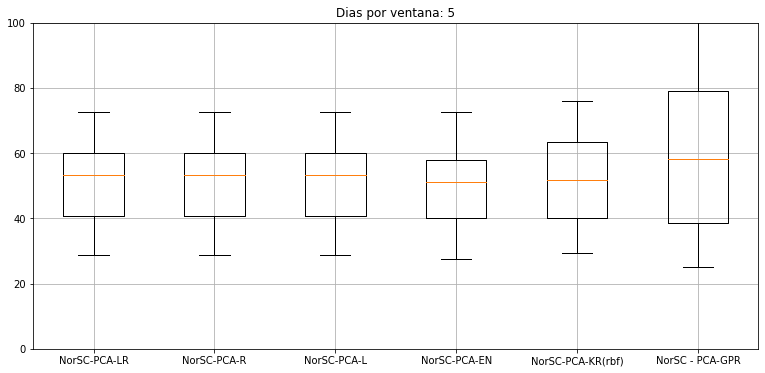

In [11]:
ventana_dias=5
plt.figure(figsize=[13,6])
plt.boxplot(maev[:,:,ventana_dias-3])
plt.xticks(ticks=np.arange(len(steps))+1, labels=label_model)
plt.title('Dias por ventana: '+str(ventana_dias))
plt.grid()
plt.ylim([0,100])
plt.show()

## Modelo Ganador Contagiados por dia

Se detemia el modelo con menor error absoluto para todas las iteraciones y todas las ventanas posibles.

Se determina:

* Mejor modelo
* Mejores Hiperparámetros
* Mejor ventana

In [12]:
win_mae_w

[30.945963795002317,
 28.386919108159322,
 25.158385728054114,
 24.830172942189673,
 28.97707416502992,
 31.832894267907363,
 20.845241990621577,
 26.062413456325277]

In [13]:
min=1e10
pos_min = 0
for i in range (len(win_mae_w)):
    if (win_mae_w[i] < min):
        min = win_mae_w[i]
        pos_min = i
        
print('Mejor estimador: ',win_estimators_w[pos_min])
print('Mejores Hyperparametros: ', win_hyperparams_w[pos_min])
print('Mejor Error absoluto: ', min)
print('Mejor ventana Regresion: ',pos_min+3)

Mejor estimador:  Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 KernelRidge(alpha=0.01, coef0=1, degree=3, gamma=0.001,
                             kernel='rbf', kernel_params=None))],
         verbose=False)
Mejores Hyperparametros:  {'reg__alpha': 0.01, 'reg__gamma': 0.001, 'rep__n_components': 0.5}
Mejor Error absoluto:  20.845241990621577
Mejor ventana Regresion:  9


# Entrenamiento del Regresor con la base de datos completa 

Se realiza el entregamiento del regresor ganador con todo el set de datos de contagiados por dia  para ajustar las predicciones, tambien se tiene en cuales son los dias por ventana que generan un mejor error absoluto.

mejor ventana entrenamiento: 8


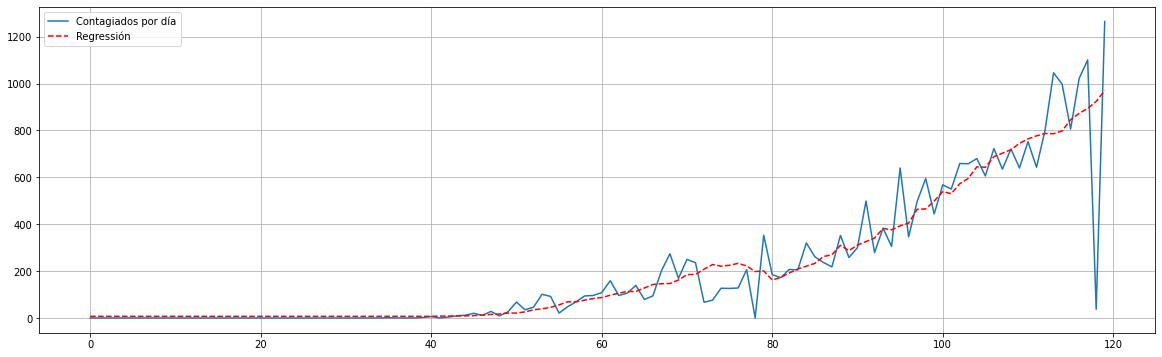

In [14]:
ii = Xd[Xd.columns[1]] == 'Colombia'
serie_d = np.append(0,np.diff(np.array(Xd.iloc[np.where(ii)[0][0],4:])))
min_mae_pred=1e10
best_window=0

for i in range (3,11):
    X_d,y_d = covid_win(serie_d,w=i)        
    model_covid = win_estimators_w[pos_min].fit(X_d,y_d)
    y_pred = model_covid.predict(X_d)
    y_pred_1 = []
    for j in range (len(X_d)):
        y_pred_1.append(int(y_pred[j]))
    if (mae(y_pred_1,y_d) < min_mae_pred):
        min_mae_pred=mae(y_pred_1,y_d)
        best_window=i
        
X_d,y_d = covid_win(serie_d,w=best_window)        
model_covid = win_estimators_w[pos_min].fit(X_d,y_d)
y_pred = model_covid.predict(X_d)
y_pred_1 = []
for j in range (len(X_d)):
    y_pred_1.append(int(y_pred[j]))

plt.figure(figsize=[20,6])
plt.plot(y_d, label='Contagiados por día')
plt.plot(y_pred_1,'r--', label='Regressión')
plt.legend()
plt.grid()
print("mejor ventana entrenamiento:", best_window)

In [15]:
print('Prediccion contagiados nuevos para',mañana,':',int(model_covid.predict(X_d[-2:-1])))

Prediccion contagiados nuevos para 2020-05-31 : 924


#### Guardar el modelo Obtenido 

In [16]:
# Guardar datos
savedata1 = {
    'mae':min,
    'best_model': win_estimators_w[pos_min],
    'best_parameters': win_hyperparams_w[pos_min]
}
dump(savedata1,'win_regressor_per_day.joblib')

['win_regressor_per_day.joblib']

# Validación cruzada y anidada - Acumulado de contagios 

In [17]:
ii = Xd[Xd.columns[1]] == 'Colombia'
serie_d = np.append(0,np.array(Xd.iloc[np.where(ii)[0][0],4:]))
window=11

Niter = 10 
maev = np.zeros ( (Niter,len(steps),window-3) )

min_it=1e10;         be_it=steps[0];              bhp_it=parameters[0]

win_mae_wa = [];     win_estimators_wa = [];      win_hyperparams_wa = []

win_mae_it = [];     win_estimators_it = [];      win_hyperparams_it = []
    

for k in range(3,window):
    
    X,y = covid_win(serie_d,w=k)
    
    for j in range (Niter):

        X_train, X_test, y_train, y_test =train_test_split(X,y, test_size=0.2)

        for r in range (len(steps)):

            grid_search = GridSearchCV(Pipeline(steps[r]), parameters[r], cv=5, verbose=10, scoring='neg_mean_absolute_error', n_jobs=5) 
            grid_search.fit(X_train, y_train)

            y_pred = grid_search.best_estimator_.predict(X_test)

            # Guardar acierto
            maev[j,r,k-3] = mae(y_test, y_pred)

            if (maev[j,r,k-3] < min_it):
                min_it = maev[j,r,k-3];   be_it = grid_search.best_estimator_;   bhp_it = grid_search.best_params_
                
            print('Ventana: %d/%d \nIteracion: %d/%d \nError absoluto para Modelo %d/%d:' 
                  %(      k,window-1,       j+1,Niter,                        r+1,len(steps)),         maev[j,r,k-3] )

        print('__________________________________________________________________')
        print ('estimador con menor error absoluto para it %d/%d: '%(j+1,Niter)); print(be_it) 
        print('Mejores hyperparametros: ',bhp_it)
        print('Error absoluto: %f'%min_it)
        print('__________________________________________________________________')
            
        win_estimators_it.append(be_it)
        win_hyperparams_it.append(bhp_it)
        win_mae_it.append(min_it)
        min_it=1e10
    
    #print(win_mae_it)
    min=1e10
    pos_min = 0
    for i in range (len(win_mae_it)):
        if (win_mae_it[i] < min):
            min = win_mae_it[i]
            pos_min = i

    win_estimators_wa.append(win_estimators_it[pos_min])
    win_hyperparams_wa.append(win_hyperparams_it[pos_min])
    win_mae_wa.append(win_mae_it[pos_min])
    print('__________________________________________________________________')
    print ('estimador con menor error absoluto para ventana %d/%d: ' %(k,window-1))
    print(win_estimators_it[pos_min]) 
    print('Mejores hyperparametros: ')
    print(win_hyperparams_it[pos_min])
    print('Error absoluto para ventana: %f' %win_mae_it[pos_min])
    print('__________________________________________________________________')
    
    win_estimators_it = []
    win_hyperparams_it = []
    win_mae_it = []

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Ventana: 3/10 
Iteracion: 1/10 
Error absoluto para Modelo 1/6: 124.5069025044516
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0079s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0079s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   9 out of  30 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0079s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0079s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0820s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fa

Ventana: 3/10 
Iteracion: 1/10 
Error absoluto para Modelo 2/6: 124.51474537602553
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0793s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1557s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.1s
[Parallel(n_jobs=5)]: Done 307 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 320 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0112s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1

Ventana: 3/10 
Iteracion: 1/10 
Error absoluto para Modelo 3/6: 124.50711148830231
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0802s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1666s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    2.8s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    3.7s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    4.5s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.4s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.2s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    7.4s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    7.7s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_j

Ventana: 3/10 
Iteracion: 1/10 
Error absoluto para Modelo 4/6: 117.42915002088353
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1041s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1402s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 455 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0101s.) Setting batch_size=2

Ventana: 3/10 
Iteracion: 1/10 
Error absoluto para Modelo 5/6: 81.71192199878212
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0461s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0640s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  50 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  74 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  83 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0137s.) Setting batch_size=2.


Ventana: 3/10 
Iteracion: 1/10 
Error absoluto para Modelo 6/6: 64.3701536843003
__________________________________________________________________
estimador con menor error absoluto para it 1/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 GaussianProcessRegressor(alpha=0.001, copy_X_train=True,
                                          kernel=None, n_restarts_optimizer=0,
                                          normalize_y=False,
                                          optimizer='fmin_l_bfgs_b',
                                          random_state=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'rep__n_components': 0.5}
Error 

[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0647s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0159s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0433s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1039s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1254s.) Setting batch_size=16.
[Parallel(n_jobs=

Ventana: 3/10 
Iteracion: 2/10 
Error absoluto para Modelo 2/6: 120.53632976805092
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1040s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0560s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1190s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 292 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0117s.)

Ventana: 3/10 
Iteracion: 2/10 
Error absoluto para Modelo 3/6: 120.52284649674894
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0630s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1462s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    2.9s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    3.7s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    4.6s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.6s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.5s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    7.8s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.1s finished
[Parallel(n_jobs=5)]: Using

Ventana: 3/10 
Iteracion: 2/10 
Error absoluto para Modelo 4/6: 108.02986873607583
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1387s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1400s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    1.0s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0190s.) Setting batch_size=2.


Ventana: 3/10 
Iteracion: 2/10 
Error absoluto para Modelo 5/6: 49.31892324892691
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0959s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1173s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  65 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  80 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0111s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0111s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   9 out of  

Ventana: 3/10 
Iteracion: 2/10 
Error absoluto para Modelo 6/6: 49.06513712487504
__________________________________________________________________
estimador con menor error absoluto para it 2/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 GaussianProcessRegressor(alpha=0.001, copy_X_train=True,
                                          kernel=None, n_restarts_optimizer=0,
                                          normalize_y=False,
                                          optimizer='fmin_l_bfgs_b',
                                          random_state=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'rep__n_components': 0.5}
Error

[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0142s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0539s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1014s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1294s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 455 tasks  

Ventana: 3/10 
Iteracion: 3/10 
Error absoluto para Modelo 2/6: 140.2491549132813
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0790s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0960s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1108s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 281 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 307 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 320 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0156s.)

Ventana: 3/10 
Iteracion: 3/10 
Error absoluto para Modelo 3/6: 140.25140408562027
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1020s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1352s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    2.9s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    3.7s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    4.5s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.5s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.4s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    7.5s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_j

Ventana: 3/10 
Iteracion: 3/10 
Error absoluto para Modelo 4/6: 143.14975016277862
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1477s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1293s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 455 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0145s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.0

Ventana: 3/10 
Iteracion: 3/10 
Error absoluto para Modelo 5/6: 96.54656759461908
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1010s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  69 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  81 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0093s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0093s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   7 tasks      | elapsed:    0.1s


Ventana: 3/10 
Iteracion: 3/10 
Error absoluto para Modelo 6/6: 97.22931716380809
__________________________________________________________________
estimador con menor error absoluto para it 3/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 KernelRidge(alpha=0.001, coef0=1, degree=3, gamma=0.1,
                             kernel='rbf', kernel_params=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}
Error absoluto: 96.546568
__________________________________________________________________
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Ventana: 3/10 
Iteracion: 4/10 
Error abso

[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0171s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0557s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0939s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1285s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 455 tasks  

Ventana: 3/10 
Iteracion: 4/10 
Error absoluto para Modelo 2/6: 101.58511129706326
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0570s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0580s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 238 tasks      | elapsed:    1.0s
[Parallel(n_jobs=5)]: Done 319 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0226s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0434s.) Setting batch_size=4.


Ventana: 3/10 
Iteracion: 4/10 
Error absoluto para Modelo 3/6: 101.57466970154587
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0621s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1252s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    2.8s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    3.7s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    4.6s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.4s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.2s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    7.3s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    7.7s finished
[Parallel(n_jobs=5)]: Using

Ventana: 3/10 
Iteracion: 4/10 
Error absoluto para Modelo 4/6: 91.89423010218987
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1121s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1720s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0182s.) Setting batch_size=2

Ventana: 3/10 
Iteracion: 4/10 
Error absoluto para Modelo 5/6: 51.66856901309746
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  14 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0753s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0199s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0199s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished


Ventana: 3/10 
Iteracion: 4/10 
Error absoluto para Modelo 6/6: 35.37211740570204
__________________________________________________________________
estimador con menor error absoluto para it 4/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 GaussianProcessRegressor(alpha=0.001, copy_X_train=True,
                                          kernel=None, n_restarts_optimizer=0,
                                          normalize_y=False,
                                          optimizer='fmin_l_bfgs_b',
                                          random_state=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'rep__n_components': 0.5}
Error

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0137s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0582s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0795s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1386s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 485 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 498 tasks      | ela

Ventana: 3/10 
Iteracion: 5/10 
Error absoluto para Modelo 2/6: 101.59976513893793
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0830s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0631s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1186s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 292 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0301s.)

Ventana: 3/10 
Iteracion: 5/10 
Error absoluto para Modelo 3/6: 101.59139681713857
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0698s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1608s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    2.9s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    3.7s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    4.7s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.7s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.7s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    7.9s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.2s finished
[Parallel(n_jobs=5)]: Using

Ventana: 3/10 
Iteracion: 5/10 
Error absoluto para Modelo 4/6: 93.83101573994594
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0977s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1654s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0165s.) Setting batch_size=2

Ventana: 3/10 
Iteracion: 5/10 
Error absoluto para Modelo 5/6: 63.36659053804424
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0689s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.5s finished


Ventana: 3/10 
Iteracion: 5/10 
Error absoluto para Modelo 6/6: 65.27597108732908
__________________________________________________________________
estimador con menor error absoluto para it 5/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 KernelRidge(alpha=0.001, coef0=1, degree=3, gamma=0.1,
                             kernel='rbf', kernel_params=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}
Error absoluto: 63.366591
__________________________________________________________________
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Ventana: 3/10 
Iteracion: 6/10 
Error abso

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0154s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0154s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of  30 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=5)]: Done   9 out of  30 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0110s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0603s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast

Ventana: 3/10 
Iteracion: 6/10 
Error absoluto para Modelo 2/6: 145.28678848049077
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0437s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0962s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1860s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 251 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 292 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0171s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks  

Ventana: 3/10 
Iteracion: 6/10 
Error absoluto para Modelo 3/6: 145.28024204401584
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1007s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1280s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    2.9s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    3.7s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    4.6s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.5s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.4s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    7.5s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_j

Ventana: 3/10 
Iteracion: 6/10 
Error absoluto para Modelo 4/6: 139.207936754871
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0932s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1240s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 412 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0213s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0

Ventana: 3/10 
Iteracion: 6/10 
Error absoluto para Modelo 5/6: 106.83664684993934
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0880s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1089s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  65 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  80 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0131s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0782s.) Setting batch_size=4.


Ventana: 3/10 
Iteracion: 6/10 
Error absoluto para Modelo 6/6: 68.89674646910687
__________________________________________________________________
estimador con menor error absoluto para it 6/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 GaussianProcessRegressor(alpha=0.001, copy_X_train=True,
                                          kernel=None, n_restarts_optimizer=0,
                                          normalize_y=False,
                                          optimizer='fmin_l_bfgs_b',
                                          random_state=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'rep__n_components': 0.5}
Error

[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0113s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0575s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0598s.) Setting batch_size=8.


Ventana: 3/10 
Iteracion: 7/10 
Error absoluto para Modelo 1/6: 119.83588436807518
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1403s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0112s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s


Ventana: 3/10 
Iteracion: 7/10 
Error absoluto para Modelo 2/6: 119.84138834431802
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0523s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0829s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1979s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1921s.) Setting batch_size=32.
[Parallel(n_jobs=5)]: Done 251 tasks      | elapsed:    1.1s
[Parallel(n_jobs=5)]: Done 292 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend wit

Ventana: 3/10 
Iteracion: 7/10 
Error absoluto para Modelo 3/6: 119.83603036712734
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1002s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1217s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    2.9s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    3.7s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    4.7s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.6s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.5s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    7.7s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_j

Ventana: 3/10 
Iteracion: 7/10 
Error absoluto para Modelo 4/6: 114.86884728597794
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1147s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 238 tasks      | elapsed:    1.1s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 430 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 499 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0181s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s


Ventana: 3/10 
Iteracion: 7/10 
Error absoluto para Modelo 5/6: 70.82341263044677
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0670s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0137s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0137s.) Setting batch_size=4.


Ventana: 3/10 
Iteracion: 7/10 
Error absoluto para Modelo 6/6: 36.9079258219413
__________________________________________________________________
estimador con menor error absoluto para it 7/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 GaussianProcessRegressor(alpha=0.001, copy_X_train=True,
                                          kernel=None, n_restarts_optimizer=0,
                                          normalize_y=False,
                                          optimizer='fmin_l_bfgs_b',
                                          random_state=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'rep__n_components': 0.5}
Error 

[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   9 out of  30 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0164s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0521s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0817s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1617s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)

Ventana: 3/10 
Iteracion: 8/10 
Error absoluto para Modelo 2/6: 112.35133883157688
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0547s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0651s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1200s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.1s
[Parallel(n_jobs=5)]: Done 292 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0105s.)

Ventana: 3/10 
Iteracion: 8/10 
Error absoluto para Modelo 3/6: 112.33795619032671
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1133s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1288s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    2.8s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    3.7s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    4.6s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.5s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.4s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    7.5s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    7.9s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_j

Ventana: 3/10 
Iteracion: 8/10 
Error absoluto para Modelo 4/6: 99.93444061383835
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1153s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1556s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0216s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0216s.)

Ventana: 3/10 
Iteracion: 8/10 
Error absoluto para Modelo 5/6: 72.68859722370998
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0793s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0083s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0083s.) Setting batch_size=4.


Ventana: 3/10 
Iteracion: 8/10 
Error absoluto para Modelo 6/6: 62.350268156237476
__________________________________________________________________
estimador con menor error absoluto para it 8/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 GaussianProcessRegressor(alpha=0.001, copy_X_train=True,
                                          kernel=None, n_restarts_optimizer=0,
                                          normalize_y=False,
                                          optimizer='fmin_l_bfgs_b',
                                          random_state=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'rep__n_components': 0.5}
Erro

[Parallel(n_jobs=5)]: Done   5 out of  30 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=5)]: Done   9 out of  30 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=5)]: Done  13 out of  30 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=5)]: Done  17 out of  30 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=5)]: Done  21 out of  30 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0113s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0897s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0629s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done

Ventana: 3/10 
Iteracion: 9/10 
Error absoluto para Modelo 2/6: 131.80932815899808
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0923s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1203s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 281 tasks      | elapsed:    1.1s
[Parallel(n_jobs=5)]: Done 292 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 320 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0149s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0544s.)

Ventana: 3/10 
Iteracion: 9/10 
Error absoluto para Modelo 3/6: 131.80448030369996
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0748s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1303s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    2.8s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    3.6s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    4.5s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.5s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.3s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    7.4s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    7.9s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_j

Ventana: 3/10 
Iteracion: 9/10 
Error absoluto para Modelo 4/6: 129.51693587085418
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1029s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1543s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 412 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0171s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0171s.)

Ventana: 3/10 
Iteracion: 9/10 
Error absoluto para Modelo 5/6: 126.90651033880064
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  14 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1533s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0175s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0175s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0s


Ventana: 3/10 
Iteracion: 9/10 
Error absoluto para Modelo 6/6: 137.3393066493473
__________________________________________________________________
estimador con menor error absoluto para it 9/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 KernelRidge(alpha=0.001, coef0=1, degree=3, gamma=0.1,
                             kernel='rbf', kernel_params=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}
Error absoluto: 126.906510
__________________________________________________________________
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Ventana: 3/10 
Iteracion: 10/10 
Error ab

[Parallel(n_jobs=5)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0153s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0507s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1416s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1337s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 427 tasks  

Ventana: 3/10 
Iteracion: 10/10 
Error absoluto para Modelo 2/6: 136.7191170885493
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0600s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1273s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1170s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 307 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0118s.)

Ventana: 3/10 
Iteracion: 10/10 
Error absoluto para Modelo 3/6: 136.71875817646782
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0818s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1464s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    2.8s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    3.7s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    4.7s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.6s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.4s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    7.8s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_j

Ventana: 3/10 
Iteracion: 10/10 
Error absoluto para Modelo 4/6: 136.3866172353428
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0947s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1991s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 455 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0292s.) Setting batch_size=2.


Ventana: 3/10 
Iteracion: 10/10 
Error absoluto para Modelo 5/6: 96.93672639802614
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0702s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1139s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  68 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  80 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0114s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0114s.) Setting batch_size=4.


Ventana: 3/10 
Iteracion: 10/10 
Error absoluto para Modelo 6/6: 66.3262391529083
__________________________________________________________________
estimador con menor error absoluto para it 10/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 GaussianProcessRegressor(alpha=0.001, copy_X_train=True,
                                          kernel=None, n_restarts_optimizer=0,
                                          normalize_y=False,
                                          optimizer='fmin_l_bfgs_b',
                                          random_state=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'rep__n_components': 0.5}
Erro

[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   9 out of  30 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0116s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0535s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0965s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1411s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)

Ventana: 4/10 
Iteracion: 1/10 
Error absoluto para Modelo 2/6: 138.48471524479228
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0866s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 238 tasks      | elapsed:    1.1s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0115s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0115s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:    0.1s


Ventana: 4/10 
Iteracion: 1/10 
Error absoluto para Modelo 3/6: 138.48221527095455
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0787s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1140s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  74 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 162 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 306 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 482 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 658 tasks      | elapsed:    2.8s
[Parallel(n_jobs=5)]: Done 866 tasks      | elapsed:    3.4s
[Parallel(n_jobs=5)]: Done 1074 tasks      | elapsed:    4.3s
[Parallel(n_jobs=5)]: Done 1314 tasks      | elapsed:    5.2s
[Parallel(n_jobs=5)]: Done 1554 tasks      | elapsed:    6.1s
[Parallel(n_jobs=5)]: Done 1826 tasks      | elapsed:    7.0s
[Parallel(n_jobs=5)]: Done 2068 tasks      | elapsed:    7.9s
[Parallel(n_jobs=5)]: Done 2147 tasks      | elapsed:    8.1s
[Parallel(n_jobs=5)]: Done 2160 out 

Ventana: 4/10 
Iteracion: 1/10 
Error absoluto para Modelo 4/6: 144.303562465405
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0163s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0617s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1185s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1420s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 412 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.1s


Ventana: 4/10 
Iteracion: 1/10 
Error absoluto para Modelo 5/6: 121.23081487930453
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0882s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0926s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  65 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  77 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0124s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.1s


Ventana: 4/10 
Iteracion: 1/10 
Error absoluto para Modelo 6/6: 167.5906068728568
__________________________________________________________________
estimador con menor error absoluto para it 1/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 KernelRidge(alpha=0.001, coef0=1, degree=3, gamma=0.1,
                             kernel='rbf', kernel_params=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}
Error absoluto: 121.230815
__________________________________________________________________
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Ventana: 4/10 
Iteracion: 2/10 
Error abs

[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0550s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0158s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0696s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0918s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1157s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=

Ventana: 4/10 
Iteracion: 2/10 
Error absoluto para Modelo 2/6: 131.1608123203717
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1375s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1332s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 292 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0142s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1

Ventana: 4/10 
Iteracion: 2/10 
Error absoluto para Modelo 3/6: 131.15240913263304
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0629s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1233s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    2.9s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    3.7s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    4.7s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.5s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.4s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    7.6s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_j

Ventana: 4/10 
Iteracion: 2/10 
Error absoluto para Modelo 4/6: 111.17413878481644
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0849s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 238 tasks      | elapsed:    1.1s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 430 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 499 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0218s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s


Ventana: 4/10 
Iteracion: 2/10 
Error absoluto para Modelo 5/6: 81.51229339764163
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0627s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  28 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0702s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  54 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  75 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  84 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0197s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0197s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0s


Ventana: 4/10 
Iteracion: 2/10 
Error absoluto para Modelo 6/6: 88.8312967065697
__________________________________________________________________
estimador con menor error absoluto para it 2/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 KernelRidge(alpha=0.001, coef0=1, degree=3, gamma=0.1,
                             kernel='rbf', kernel_params=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}
Error absoluto: 81.512293
__________________________________________________________________
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Ventana: 4/10 
Iteracion: 3/10 
Error absol

[Parallel(n_jobs=5)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0269s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0269s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  14 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1203s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  86 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 158 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 246 tasks      | elapsed:    1.0s
[Parallel(n_jobs=5)]: Done 334 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 438 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 493 tasks      | elapsed:    1.8s

Ventana: 4/10 
Iteracion: 3/10 
Error absoluto para Modelo 2/6: 162.04791759990763
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0940s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1520s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.1s
[Parallel(n_jobs=5)]: Done 307 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 320 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0119s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1

Ventana: 4/10 
Iteracion: 3/10 
Error absoluto para Modelo 3/6: 162.04912184047956
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1292s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1236s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    2.8s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    3.6s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    4.5s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.5s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.4s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    7.5s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    7.9s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_j

Ventana: 4/10 
Iteracion: 3/10 
Error absoluto para Modelo 4/6: 163.1697519846385
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0790s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1709s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 455 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0209s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0

Ventana: 4/10 
Iteracion: 3/10 
Error absoluto para Modelo 5/6: 236.53044280074036
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0842s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1061s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  65 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  80 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0101s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0403s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  30 out of  

Ventana: 4/10 
Iteracion: 3/10 
Error absoluto para Modelo 6/6: 167.75439972415435
__________________________________________________________________
estimador con menor error absoluto para it 3/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 Ridge(alpha=0.001, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=1e-05))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'reg__tol': 1e-05, 'rep__n_components': 0.5}
Error absoluto: 162.047918
__________________________________________________________________
Fitting 5 folds for each of 6 candidates, t

[Parallel(n_jobs=5)]: Batch computation too fast (0.0215s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0518s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0828s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1619s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 442 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 455 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 483 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    1.9s


Ventana: 4/10 
Iteracion: 4/10 
Error absoluto para Modelo 2/6: 187.1491584545906
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0942s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1903s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 292 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 320 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0175s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1

Ventana: 4/10 
Iteracion: 4/10 
Error absoluto para Modelo 3/6: 187.14916417569327
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1465s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1451s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    2.9s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    3.8s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    4.7s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.6s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.6s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    7.9s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_j

Ventana: 4/10 
Iteracion: 4/10 
Error absoluto para Modelo 4/6: 187.17464032878937
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1313s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1183s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0190s.) Setting batch_size=2

Ventana: 4/10 
Iteracion: 4/10 
Error absoluto para Modelo 5/6: 132.48894136334434
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0532s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1092s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  68 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  80 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0180s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0180s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   6 tasks      | elapsed:    0.1s


Ventana: 4/10 
Iteracion: 4/10 
Error absoluto para Modelo 6/6: 193.77357909973173
__________________________________________________________________
estimador con menor error absoluto para it 4/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 KernelRidge(alpha=0.001, coef0=1, degree=3, gamma=0.1,
                             kernel='rbf', kernel_params=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}
Error absoluto: 132.488941
__________________________________________________________________
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Ventana: 4/10 
Iteracion: 5/10 
Error ab

[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0135s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0564s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0893s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1602s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 470 tasks  

Ventana: 4/10 
Iteracion: 5/10 
Error absoluto para Modelo 2/6: 158.96378720517458
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0612s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0966s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1379s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 281 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 292 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 320 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0177s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks  

Ventana: 4/10 
Iteracion: 5/10 
Error absoluto para Modelo 3/6: 158.9630632763467
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0757s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1987s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.0s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    3.9s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    4.7s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.8s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.7s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    8.0s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_j

Ventana: 4/10 
Iteracion: 5/10 
Error absoluto para Modelo 4/6: 158.55752945973242
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0740s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1222s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 442 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 485 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0181s.) Setting batch_size=2.


Ventana: 4/10 
Iteracion: 5/10 
Error absoluto para Modelo 5/6: 98.48731494246167
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0945s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1717s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  65 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  80 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0189s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0189s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of  30 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=5)]

Ventana: 4/10 
Iteracion: 5/10 
Error absoluto para Modelo 6/6: 87.90183743083588
__________________________________________________________________
estimador con menor error absoluto para it 5/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 GaussianProcessRegressor(alpha=0.001, copy_X_train=True,
                                          kernel=None, n_restarts_optimizer=0,
                                          normalize_y=False,
                                          optimizer='fmin_l_bfgs_b',
                                          random_state=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'rep__n_components': 0.5}
Error

[Parallel(n_jobs=5)]: Batch computation too fast (0.0185s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0523s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0965s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1155s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.0s


Ventana: 4/10 
Iteracion: 6/10 
Error absoluto para Modelo 2/6: 118.84234406410114
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0499s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1059s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 238 tasks      | elapsed:    1.1s
[Parallel(n_jobs=5)]: Done 319 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 351 out of 360 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0091s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks     

Ventana: 4/10 
Iteracion: 6/10 
Error absoluto para Modelo 3/6: 118.83633630873652
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0694s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0924s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1423s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.0s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    4.0s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    5.0s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    6.0s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.9s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    8.2s
[Parallel(n_jobs=

Ventana: 4/10 
Iteracion: 6/10 
Error absoluto para Modelo 4/6: 119.73069623746224
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1293s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1595s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 455 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0109s.) Setting batch_size=2

Ventana: 4/10 
Iteracion: 6/10 
Error absoluto para Modelo 5/6: 68.37501039988477
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0500s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  16 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0932s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1157s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  68 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0123s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0710s.) Setting batch_size=4.


Ventana: 4/10 
Iteracion: 6/10 
Error absoluto para Modelo 6/6: 71.92610482968652
__________________________________________________________________
estimador con menor error absoluto para it 6/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 KernelRidge(alpha=0.001, coef0=1, degree=3, gamma=0.1,
                             kernel='rbf', kernel_params=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}
Error absoluto: 68.375010
__________________________________________________________________
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Ventana: 4/10 
Iteracion: 7/10 
Error abso

[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0166s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0470s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0829s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1502s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 470 tasks  

Ventana: 4/10 
Iteracion: 7/10 
Error absoluto para Modelo 2/6: 146.491962352015
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0613s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0964s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1488s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 292 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0122s.)

Ventana: 4/10 
Iteracion: 7/10 
Error absoluto para Modelo 3/6: 146.4861984712066
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1154s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 238 tasks      | elapsed:    1.1s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 430 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 534 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 654 tasks      | elapsed:    2.8s
[Parallel(n_jobs=5)]: Done 774 tasks      | elapsed:    3.3s
[Parallel(n_jobs=5)]: Done 910 tasks      | elapsed:    3.7s
[Parallel(n_jobs=5)]: Done 1046 tasks      | elapsed:    4.4s
[Parallel(n_jobs=5)]: Done 1198 tasks      | elapsed:    4.8s
[Parallel(n_jobs=5)]: Done 1350 tasks      | elapsed:    5.5s
[Parallel(n_jobs=5)]: Done 1518 tasks      | elapsed:    6.2s
[Parallel(n_jobs=5)]: Done 1686 tasks      | elapsed:    7.0

Ventana: 4/10 
Iteracion: 7/10 
Error absoluto para Modelo 4/6: 120.49836660511357
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1151s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1919s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 483 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0164s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0164s.)

Ventana: 4/10 
Iteracion: 7/10 
Error absoluto para Modelo 5/6: 213.06643012516273
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  14 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1415s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0159s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0673s.) Setting batch_size=4.


Ventana: 4/10 
Iteracion: 7/10 
Error absoluto para Modelo 6/6: 158.98587124188214
__________________________________________________________________
estimador con menor error absoluto para it 7/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 ElasticNet(alpha=0.01, copy_X=True, fit_intercept=True,
                            l1_ratio=10, max_iter=1000, normalize=False,
                            positive=False, precompute=False, random_state=None,
                            selection='cyclic', tol=0.0001, warm_start=True))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.01, 'reg__l1_ratio': 10, 'reg__selection': 'cyclic', 'reg__warm_start': Tru

[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0128s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0574s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0969s.) Setting batch_size=8.


Ventana: 4/10 
Iteracion: 8/10 
Error absoluto para Modelo 1/6: 100.99454986791588
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1412s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 442 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 485 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0127s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s


Ventana: 4/10 
Iteracion: 8/10 
Error absoluto para Modelo 2/6: 100.99664776850133
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0673s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0574s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1625s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 292 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0

Ventana: 4/10 
Iteracion: 8/10 
Error absoluto para Modelo 3/6: 100.99460909513432
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1446s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  74 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 162 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 306 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 482 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 658 tasks      | elapsed:    2.9s
[Parallel(n_jobs=5)]: Done 866 tasks      | elapsed:    3.6s
[Parallel(n_jobs=5)]: Done 1074 tasks      | elapsed:    4.5s
[Parallel(n_jobs=5)]: Done 1314 tasks      | elapsed:    5.5s
[Parallel(n_jobs=5)]: Done 1554 tasks      | elapsed:    6.4s
[Parallel(n_jobs=5)]: Done 1826 tasks      | elapsed:    7.4s
[Parallel(n_jobs=5)]: Done 2068 tasks      | elapsed:    8.3s
[Parallel(n_jobs=5)]: Done 2147 tasks      | elapsed:    8.5s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBacken

Ventana: 4/10 
Iteracion: 8/10 
Error absoluto para Modelo 4/6: 92.91080950081538
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1072s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1307s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    1.0s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0192s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0192s.)

Ventana: 4/10 
Iteracion: 8/10 
Error absoluto para Modelo 5/6: 63.492731755641074
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1108s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  70 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  81 out of  90 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0163s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0450s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Ventana: 4/10 
Iteracion: 8/10 
Error absoluto para Modelo 6/6: 39.28061936264392
__________________________________________________________________
estimador con menor error absoluto para it 8/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 GaussianProcessRegressor(alpha=0.001, copy_X_train=True,
                                          kernel=None, n_restarts_optimizer=0,
                                          normalize_y=False,
                                          optimizer='fmin_l_bfgs_b',
                                          random_state=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'rep__n_components': 0.5}
Error

[Parallel(n_jobs=5)]: Batch computation too fast (0.0122s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0612s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1291s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1088s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 455 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.0s


Ventana: 4/10 
Iteracion: 9/10 
Error absoluto para Modelo 2/6: 126.12028011530414
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0836s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0905s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1645s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 292 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0150s.)

Ventana: 4/10 
Iteracion: 9/10 
Error absoluto para Modelo 3/6: 126.11442693968995
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0904s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1444s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    2.9s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    3.8s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    4.8s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.6s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.5s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    7.8s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.2s finished
[Parallel(n_jobs=5)]: Using

Ventana: 4/10 
Iteracion: 9/10 
Error absoluto para Modelo 4/6: 82.69330913388961
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0800s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1735s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 455 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0167s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0167s.)

Ventana: 4/10 
Iteracion: 9/10 
Error absoluto para Modelo 5/6: 58.98332297995919
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0690s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  23 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0111s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0645s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished


Ventana: 4/10 
Iteracion: 9/10 
Error absoluto para Modelo 6/6: 44.80017640306629
__________________________________________________________________
estimador con menor error absoluto para it 9/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 GaussianProcessRegressor(alpha=0.001, copy_X_train=True,
                                          kernel=None, n_restarts_optimizer=0,
                                          normalize_y=False,
                                          optimizer='fmin_l_bfgs_b',
                                          random_state=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'rep__n_components': 0.5}
Error

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0154s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0600s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1123s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 238 tasks      | elapsed:    1.1s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 430 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 506 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.1s
[Paralle

Ventana: 4/10 
Iteracion: 10/10 
Error absoluto para Modelo 2/6: 113.29121480880256
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0958s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1161s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 292 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 320 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0216s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1

Ventana: 4/10 
Iteracion: 10/10 
Error absoluto para Modelo 3/6: 113.28581153686213
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0743s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1198s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.0s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    4.0s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    4.9s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    6.0s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.9s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    8.1s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_j

Ventana: 4/10 
Iteracion: 10/10 
Error absoluto para Modelo 4/6: 110.76116172836511
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1567s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 238 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 430 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 499 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0169s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s


Ventana: 4/10 
Iteracion: 10/10 
Error absoluto para Modelo 5/6: 105.47744183242787
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0830s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1340s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  65 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  80 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0091s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0478s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  30 out of  

Ventana: 4/10 
Iteracion: 10/10 
Error absoluto para Modelo 6/6: 43.48340712231591
__________________________________________________________________
estimador con menor error absoluto para it 10/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 GaussianProcessRegressor(alpha=0.001, copy_X_train=True,
                                          kernel=None, n_restarts_optimizer=0,
                                          normalize_y=False,
                                          optimizer='fmin_l_bfgs_b',
                                          random_state=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'rep__n_components': 0.5}
Err

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0233s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0465s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0747s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1110s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 455 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 498 tasks      | ela

Ventana: 5/10 
Iteracion: 1/10 
Error absoluto para Modelo 2/6: 139.70583272206358
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0537s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1002s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 238 tasks      | elapsed:    1.1s
[Parallel(n_jobs=5)]: Done 319 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0122s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0632s.) 

Ventana: 5/10 
Iteracion: 1/10 
Error absoluto para Modelo 3/6: 139.70059771873667
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0956s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1339s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.0s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    4.0s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    4.9s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.8s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.7s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    8.1s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.6s finished
[Parallel(n_jobs=5)]: Using

Ventana: 5/10 
Iteracion: 1/10 
Error absoluto para Modelo 4/6: 117.46614128575666
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1463s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1649s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    1.0s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 442 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.5s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0185s.) Setting batch_size=2

Ventana: 5/10 
Iteracion: 1/10 
Error absoluto para Modelo 5/6: 77.41101436535551
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1448s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Ventana: 5/10 
Iteracion: 1/10 
Error absoluto para Modelo 6/6: 64.84356093736766
__________________________________________________________________
estimador con menor error absoluto para it 1/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 GaussianProcessRegressor(alpha=0.001, copy_X_train=True,
                                          kernel=None, n_restarts_optimizer=0,
                                          normalize_y=False,
                                          optimizer='fmin_l_bfgs_b',
                                          random_state=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'rep__n_components': 0.5}
Error

[Parallel(n_jobs=5)]: Batch computation too fast (0.0151s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0151s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of  30 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=5)]: Done   9 out of  30 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=5)]: Done  13 out of  30 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=5)]: Done  17 out of  30 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=5)]: Done  21 out of  30 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=5)]: Done  25 out of  30 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0083s.) Setting batch_size=2.
[Parall

Ventana: 5/10 
Iteracion: 2/10 
Error absoluto para Modelo 2/6: 183.8880780057473
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1119s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1250s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 292 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0135s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0135s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  10 tasks  

Ventana: 5/10 
Iteracion: 2/10 
Error absoluto para Modelo 3/6: 183.88484903381894
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1217s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  82 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 178 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 322 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 674 tasks      | elapsed:    2.8s
[Parallel(n_jobs=5)]: Done 882 tasks      | elapsed:    3.5s
[Parallel(n_jobs=5)]: Done 1090 tasks      | elapsed:    4.4s
[Parallel(n_jobs=5)]: Done 1330 tasks      | elapsed:    5.3s
[Parallel(n_jobs=5)]: Done 1570 tasks      | elapsed:    6.2s
[Parallel(n_jobs=5)]: Done 1842 tasks      | elapsed:    7.3s
[Parallel(n_jobs=5)]: Done 2069 tasks      | elapsed:    8.2s
[Parallel(n_jobs=5)]: Done 2148 tasks      | elapsed:    8.3s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBacken

Ventana: 5/10 
Iteracion: 2/10 
Error absoluto para Modelo 4/6: 156.95290615850678
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1048s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1588s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 485 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0117s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0117s.)

Ventana: 5/10 
Iteracion: 2/10 
Error absoluto para Modelo 5/6: 138.62252270370016
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0687s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1073s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  49 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  70 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  86 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0089s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0518s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  12 tasks  

Ventana: 5/10 
Iteracion: 2/10 
Error absoluto para Modelo 6/6: 188.12297454179384
__________________________________________________________________
estimador con menor error absoluto para it 2/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 KernelRidge(alpha=0.001, coef0=1, degree=3, gamma=0.1,
                             kernel='rbf', kernel_params=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}
Error absoluto: 138.622523
__________________________________________________________________
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Ventana: 5/10 
Iteracion: 3/10 
Error ab

[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0115s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0601s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0689s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1259s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 442 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 470 tasks  

Ventana: 5/10 
Iteracion: 3/10 
Error absoluto para Modelo 2/6: 195.33473851436807
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0525s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1078s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 238 tasks      | elapsed:    1.0s
[Parallel(n_jobs=5)]: Done 319 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0155s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0689s.) 

Ventana: 5/10 
Iteracion: 3/10 
Error absoluto para Modelo 3/6: 195.33058059429956
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0852s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1892s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.5s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.0s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    4.0s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    4.9s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.9s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.8s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    8.1s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.6s finished
[Parallel(n_jobs=5)]: Using

Ventana: 5/10 
Iteracion: 3/10 
Error absoluto para Modelo 4/6: 158.79406488255188
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1495s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1260s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0175s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0

Ventana: 5/10 
Iteracion: 3/10 
Error absoluto para Modelo 5/6: 84.43055192278844
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0894s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1461s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  68 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  80 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0196s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1013s.) Setting batch_size=4.


Ventana: 5/10 
Iteracion: 3/10 
Error absoluto para Modelo 6/6: 84.61009831262272
__________________________________________________________________
estimador con menor error absoluto para it 3/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 KernelRidge(alpha=0.001, coef0=1, degree=3, gamma=0.1,
                             kernel='rbf', kernel_params=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}
Error absoluto: 84.430552
__________________________________________________________________
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0136s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0556s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s


Ventana: 5/10 
Iteracion: 4/10 
Error absoluto para Modelo 1/6: 129.76392851159466
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0979s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1215s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 455 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0138s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0

Ventana: 5/10 
Iteracion: 4/10 
Error absoluto para Modelo 2/6: 129.76545029987523
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0552s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0948s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1170s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 251 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 307 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0131s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks  

Ventana: 5/10 
Iteracion: 4/10 
Error absoluto para Modelo 3/6: 129.7639771313951
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1240s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1171s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    1.0s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.0s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    3.9s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    4.9s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.8s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.7s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    8.0s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_j

Ventana: 5/10 
Iteracion: 4/10 
Error absoluto para Modelo 4/6: 118.75022150559835
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1025s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1310s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 442 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0195s.) Setting batch_size=2

Ventana: 5/10 
Iteracion: 4/10 
Error absoluto para Modelo 5/6: 64.79987274203653
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0195s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0882s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0178s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0178s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   9 out of  30 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent worker

Ventana: 5/10 
Iteracion: 4/10 
Error absoluto para Modelo 6/6: 66.6152424230181
__________________________________________________________________
estimador con menor error absoluto para it 4/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 KernelRidge(alpha=0.001, coef0=1, degree=3, gamma=0.1,
                             kernel='rbf', kernel_params=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}
Error absoluto: 64.799873
__________________________________________________________________
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Ventana: 5/10 
Iteracion: 5/10 
Error absol

[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0592s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0880s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1394s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.1s finished
[Parallel(n_

Ventana: 5/10 
Iteracion: 5/10 
Error absoluto para Modelo 2/6: 146.85988408421602
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0836s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1489s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 292 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 320 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0172s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1

Ventana: 5/10 
Iteracion: 5/10 
Error absoluto para Modelo 3/6: 146.85276223060097
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1259s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1601s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.5s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.0s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    3.9s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    4.8s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.8s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.8s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    8.0s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_j

Ventana: 5/10 
Iteracion: 5/10 
Error absoluto para Modelo 4/6: 112.69111576946209
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1124s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1254s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    1.0s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0181s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0181s.)

Ventana: 5/10 
Iteracion: 5/10 
Error absoluto para Modelo 5/6: 122.31063962704269
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0697s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0110s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0110s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   9 out of  30 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0139s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.

Ventana: 5/10 
Iteracion: 5/10 
Error absoluto para Modelo 6/6: 55.608340420797795
__________________________________________________________________
estimador con menor error absoluto para it 5/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 GaussianProcessRegressor(alpha=0.001, copy_X_train=True,
                                          kernel=None, n_restarts_optimizer=0,
                                          normalize_y=False,
                                          optimizer='fmin_l_bfgs_b',
                                          random_state=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'rep__n_components': 0.5}
Erro

[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0545s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0859s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1810s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 442 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 455 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.3s finished
[Parallel(n_

Ventana: 5/10 
Iteracion: 6/10 
Error absoluto para Modelo 2/6: 153.0356267346804
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0839s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1100s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1354s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 292 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0130s.)

Ventana: 5/10 
Iteracion: 6/10 
Error absoluto para Modelo 3/6: 153.03003055945544
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1079s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1331s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    2.9s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    3.9s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    4.9s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.8s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.7s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    8.0s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.4s finished
[Parallel(n_jobs=5)]: Using

Ventana: 5/10 
Iteracion: 6/10 
Error absoluto para Modelo 4/6: 137.44857173285752
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0999s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1183s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 442 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 455 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0378s.) Setting batch_size=2.


Ventana: 5/10 
Iteracion: 6/10 
Error absoluto para Modelo 5/6: 73.06718625195514
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0598s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0639s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  68 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  80 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0086s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0086s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   9 out of  30 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=5)]

Ventana: 5/10 
Iteracion: 6/10 
Error absoluto para Modelo 6/6: 96.3693297520664
__________________________________________________________________
estimador con menor error absoluto para it 6/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 KernelRidge(alpha=0.001, coef0=1, degree=3, gamma=0.1,
                             kernel='rbf', kernel_params=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}
Error absoluto: 73.067186
__________________________________________________________________
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Ventana: 5/10 
Iteracion: 7/10 
Error absol

[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0510s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0795s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 238 tasks      | elapsed:    1.0s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 430 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 499 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]

Ventana: 5/10 
Iteracion: 7/10 
Error absoluto para Modelo 2/6: 147.96899611627637
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1187s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1536s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 307 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0177s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0600s.)

Ventana: 5/10 
Iteracion: 7/10 
Error absoluto para Modelo 3/6: 147.96470074043987
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1082s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1658s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.5s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.0s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    4.0s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    4.9s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.9s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.8s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    8.1s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_j

Ventana: 5/10 
Iteracion: 7/10 
Error absoluto para Modelo 4/6: 120.89497579411058
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1501s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1779s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0107s.) Setting batch_size=2

Ventana: 5/10 
Iteracion: 7/10 
Error absoluto para Modelo 5/6: 87.69422231526886
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0602s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0887s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  50 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  74 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  83 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.6s finished


Ventana: 5/10 
Iteracion: 7/10 
Error absoluto para Modelo 6/6: 54.28973890709
__________________________________________________________________
estimador con menor error absoluto para it 7/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 GaussianProcessRegressor(alpha=0.001, copy_X_train=True,
                                          kernel=None, n_restarts_optimizer=0,
                                          normalize_y=False,
                                          optimizer='fmin_l_bfgs_b',
                                          random_state=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'rep__n_components': 0.5}
Error ab

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0146s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0720s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0130s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0597s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1122s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Par

Ventana: 5/10 
Iteracion: 8/10 
Error absoluto para Modelo 2/6: 133.5058058549264
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0647s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1623s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  74 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 162 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 246 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 302 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 313 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 339 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0170s.) Setting batch_size=2

Ventana: 5/10 
Iteracion: 8/10 
Error absoluto para Modelo 3/6: 133.5028745706476
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0683s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0939s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1222s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.0s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    3.9s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    4.8s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.8s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.7s
[Parallel(n_jobs=5

Ventana: 5/10 
Iteracion: 8/10 
Error absoluto para Modelo 4/6: 109.16138854081956
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1198s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1756s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0177s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0177s.)

Ventana: 5/10 
Iteracion: 8/10 
Error absoluto para Modelo 5/6: 73.35688822334181
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1670s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  50 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  71 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0090s.) Setting batch_size=2.


Ventana: 5/10 
Iteracion: 8/10 
Error absoluto para Modelo 6/6: 54.031298546027465
__________________________________________________________________
estimador con menor error absoluto para it 8/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 GaussianProcessRegressor(alpha=0.001, copy_X_train=True,
                                          kernel=None, n_restarts_optimizer=0,
                                          normalize_y=False,
                                          optimizer='fmin_l_bfgs_b',
                                          random_state=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'rep__n_components': 0.5}
Erro

[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0511s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0119s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0617s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0911s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1553s.) Setting batch_size=16.
[Parallel(n_jobs=

Ventana: 5/10 
Iteracion: 9/10 
Error absoluto para Modelo 2/6: 146.55543173869285
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0609s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1214s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1760s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 281 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 292 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0127s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks  

Ventana: 5/10 
Iteracion: 9/10 
Error absoluto para Modelo 3/6: 146.55161816619767
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0951s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 238 tasks      | elapsed:    1.1s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 430 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 534 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 654 tasks      | elapsed:    2.8s
[Parallel(n_jobs=5)]: Done 774 tasks      | elapsed:    3.3s
[Parallel(n_jobs=5)]: Done 910 tasks      | elapsed:    3.8s
[Parallel(n_jobs=5)]: Done 1046 tasks      | elapsed:    4.4s
[Parallel(n_jobs=5)]: Done 1198 tasks      | elapsed:    4.9s
[Parallel(n_jobs=5)]: Done 1350 tasks      | elapsed:    5.5s
[Parallel(n_jobs=5)]: Done 1518 tasks      | elapsed:    6.2s
[Parallel(n_jobs=5)]: Done 1686 tasks      | elapsed:    7.0

Ventana: 5/10 
Iteracion: 9/10 
Error absoluto para Modelo 4/6: 143.319687573974
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1156s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1514s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 442 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0228s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0228s.)

Ventana: 5/10 
Iteracion: 9/10 
Error absoluto para Modelo 5/6: 93.94778990000806
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1475s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0091s.) Setting batch_size=2.


Ventana: 5/10 
Iteracion: 9/10 
Error absoluto para Modelo 6/6: 100.77679317008791
__________________________________________________________________
estimador con menor error absoluto para it 9/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 KernelRidge(alpha=0.001, coef0=1, degree=3, gamma=0.1,
                             kernel='rbf', kernel_params=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}
Error absoluto: 93.947790
__________________________________________________________________
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Ventana: 5/10 
Iteracion: 10/10 
Error ab

[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0470s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0128s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0633s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0754s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation

Ventana: 5/10 
Iteracion: 10/10 
Error absoluto para Modelo 2/6: 150.11118625726627
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0759s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0640s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1036s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 307 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0791s.)

Ventana: 5/10 
Iteracion: 10/10 
Error absoluto para Modelo 3/6: 150.1062558254419
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0594s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1365s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  74 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 162 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 306 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 482 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 658 tasks      | elapsed:    2.9s
[Parallel(n_jobs=5)]: Done 866 tasks      | elapsed:    3.5s
[Parallel(n_jobs=5)]: Done 1074 tasks      | elapsed:    4.5s
[Parallel(n_jobs=5)]: Done 1314 tasks      | elapsed:    5.3s
[Parallel(n_jobs=5)]: Done 1554 tasks      | elapsed:    6.3s
[Parallel(n_jobs=5)]: Done 1826 tasks      | elapsed:    7.3s
[Parallel(n_jobs=5)]: Done 2068 tasks      | elapsed:    8.2s
[Parallel(n_jobs=5)]: Done 2117 tasks

Ventana: 5/10 
Iteracion: 10/10 
Error absoluto para Modelo 4/6: 105.13075151820696
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0731s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 238 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 430 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 506 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0180s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0180s.) Setting batch_size=4.


Ventana: 5/10 
Iteracion: 10/10 
Error absoluto para Modelo 5/6: 62.36834701736691
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0887s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.5s finished


Ventana: 5/10 
Iteracion: 10/10 
Error absoluto para Modelo 6/6: 40.81865263284563
__________________________________________________________________
estimador con menor error absoluto para it 10/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 GaussianProcessRegressor(alpha=0.001, copy_X_train=True,
                                          kernel=None, n_restarts_optimizer=0,
                                          normalize_y=False,
                                          optimizer='fmin_l_bfgs_b',
                                          random_state=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'rep__n_components': 0.5}
Err

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0096s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0485s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0148s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0579s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1108s.) Setting batch_size=8.
[Par

Ventana: 6/10 
Iteracion: 1/10 
Error absoluto para Modelo 2/6: 190.7452153011343
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0751s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0944s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1543s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 307 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers

Ventana: 6/10 
Iteracion: 1/10 
Error absoluto para Modelo 3/6: 190.7460177115039
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1047s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1385s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.1s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    3.9s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    4.8s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.9s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.8s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    8.1s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.5s finished
[Parallel(n_jobs=5)]: Using

Ventana: 6/10 
Iteracion: 1/10 
Error absoluto para Modelo 4/6: 199.80287245757222
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1300s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  82 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 178 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 322 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 468 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Ventana: 6/10 
Iteracion: 1/10 
Error absoluto para Modelo 5/6: 154.3062307032087
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0139s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0139s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  14 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1120s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0076s.) Setting batch_size=2.


Ventana: 6/10 
Iteracion: 1/10 
Error absoluto para Modelo 6/6: 199.5517915365604
__________________________________________________________________
estimador con menor error absoluto para it 1/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 KernelRidge(alpha=0.001, coef0=1, degree=3, gamma=0.1,
                             kernel='rbf', kernel_params=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}
Error absoluto: 154.306231
__________________________________________________________________
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Ventana: 6/10 
Iteracion: 2/10 
Error abs

[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0638s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0143s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0784s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0873s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1450s.) Setting batch_size=16.
[Parallel(n_jobs=

Ventana: 6/10 
Iteracion: 2/10 
Error absoluto para Modelo 2/6: 164.52096293107047
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1480s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1571s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 307 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0204s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0475s.)

Ventana: 6/10 
Iteracion: 2/10 
Error absoluto para Modelo 3/6: 164.52029370110722
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1035s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0872s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    2.9s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    3.7s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    4.7s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.5s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.4s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    7.7s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_j

Ventana: 6/10 
Iteracion: 2/10 
Error absoluto para Modelo 4/6: 159.09759684245319
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1195s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1994s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 442 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0149s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0

Ventana: 6/10 
Iteracion: 2/10 
Error absoluto para Modelo 5/6: 81.14212485925033
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1059s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1534s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  65 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  80 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0108s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0108s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   9 out of  30 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=5)]

Ventana: 6/10 
Iteracion: 2/10 
Error absoluto para Modelo 6/6: 54.3709720128062
__________________________________________________________________
estimador con menor error absoluto para it 2/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 GaussianProcessRegressor(alpha=0.001, copy_X_train=True,
                                          kernel=None, n_restarts_optimizer=0,
                                          normalize_y=False,
                                          optimizer='fmin_l_bfgs_b',
                                          random_state=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'rep__n_components': 0.5}
Error 

[Parallel(n_jobs=5)]: Batch computation too fast (0.0160s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0749s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0827s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1245s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 455 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.0s


Ventana: 6/10 
Iteracion: 3/10 
Error absoluto para Modelo 2/6: 146.81677150424923
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0566s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0881s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1347s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 251 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 292 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0144s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks  

Ventana: 6/10 
Iteracion: 3/10 
Error absoluto para Modelo 3/6: 146.8151213674283
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1191s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1080s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.0s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    3.9s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    4.8s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.8s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.8s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    8.0s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_j

Ventana: 6/10 
Iteracion: 3/10 
Error absoluto para Modelo 4/6: 152.5169731458357
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1612s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  74 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 162 tasks      | elapsed:    1.0s
[Parallel(n_jobs=5)]: Done 306 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 467 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0286s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0286s.) Setting batch_size=4.


Ventana: 6/10 
Iteracion: 3/10 
Error absoluto para Modelo 5/6: 85.82306446078088
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1574s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  26 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  54 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  75 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  81 out of  90 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.6s finished


Ventana: 6/10 
Iteracion: 3/10 
Error absoluto para Modelo 6/6: 107.9423609498523
__________________________________________________________________
estimador con menor error absoluto para it 3/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 KernelRidge(alpha=0.001, coef0=1, degree=3, gamma=0.1,
                             kernel='rbf', kernel_params=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}
Error absoluto: 85.823064
__________________________________________________________________
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Ventana: 6/10 
Iteracion: 4/10 
Error abso

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0214s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0214s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   9 out of  30 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0162s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0580s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1091s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | el

Ventana: 6/10 
Iteracion: 4/10 
Error absoluto para Modelo 2/6: 165.44863521124446
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0568s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1246s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1208s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 307 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0125s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks  

Ventana: 6/10 
Iteracion: 4/10 
Error absoluto para Modelo 3/6: 165.44479183295763
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1356s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1144s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.5s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.1s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    4.1s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    5.0s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    6.0s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.8s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    8.1s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.5s finished
[Parallel(n_jobs=5)]: Using

Ventana: 6/10 
Iteracion: 4/10 
Error absoluto para Modelo 4/6: 150.20033458792415
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1683s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1803s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    1.0s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 442 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Ventana: 6/10 
Iteracion: 4/10 
Error absoluto para Modelo 5/6: 132.76402281319702
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0162s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0988s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1724s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  65 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  80 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0090s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  10 tasks   

Ventana: 6/10 
Iteracion: 4/10 
Error absoluto para Modelo 6/6: 190.48002362368214
__________________________________________________________________
estimador con menor error absoluto para it 4/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 KernelRidge(alpha=0.001, coef0=1, degree=3, gamma=0.1,
                             kernel='rbf', kernel_params=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}
Error absoluto: 132.764023
__________________________________________________________________
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0207s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0382s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s


Ventana: 6/10 
Iteracion: 5/10 
Error absoluto para Modelo 1/6: 157.4203354865979
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1279s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1130s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0175s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0

Ventana: 6/10 
Iteracion: 5/10 
Error absoluto para Modelo 2/6: 157.42024124394618
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0607s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0662s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1894s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1939s.) Setting batch_size=32.
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 292 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend wit

Ventana: 6/10 
Iteracion: 5/10 
Error absoluto para Modelo 3/6: 157.4203321378829
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0936s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1785s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.5s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.0s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    4.0s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    4.9s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    6.0s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    7.0s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    8.3s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.7s finished
[Parallel(n_jobs=5)]: Using

Ventana: 6/10 
Iteracion: 5/10 
Error absoluto para Modelo 4/6: 160.8529725275076
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1347s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 238 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 430 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 499 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0118s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0118s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0s


Ventana: 6/10 
Iteracion: 5/10 
Error absoluto para Modelo 5/6: 263.3017904295335
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0996s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Ventana: 6/10 
Iteracion: 5/10 
Error absoluto para Modelo 6/6: 190.81149954578035
__________________________________________________________________
estimador con menor error absoluto para it 5/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 Ridge(alpha=0.001, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=1e-05))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'reg__tol': 1e-05, 'rep__n_components': 0.5}
Error absoluto: 157.420241
__________________________________________________________________
Fitting 5 folds for each of 6 candidates, t

[Parallel(n_jobs=5)]: Batch computation too fast (0.0327s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0620s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0108s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s


Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0586s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1065s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1438s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.1s finished
[Parallel(n_

Ventana: 6/10 
Iteracion: 6/10 
Error absoluto para Modelo 2/6: 141.30754018322003
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0755s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0635s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1620s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 307 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0116s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks  

Ventana: 6/10 
Iteracion: 6/10 
Error absoluto para Modelo 3/6: 141.30477354675372
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1068s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1231s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    2.9s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    3.8s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    4.8s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.7s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.7s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    7.9s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.4s finished
[Parallel(n_jobs=5)]: Using

Ventana: 6/10 
Iteracion: 6/10 
Error absoluto para Modelo 4/6: 116.1229532743492
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0832s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 238 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 430 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 499 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0160s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s


Ventana: 6/10 
Iteracion: 6/10 
Error absoluto para Modelo 5/6: 85.51961755708267
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0910s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1503s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  68 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  80 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0150s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0150s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   7 tasks      | elapsed:    0.1s


Ventana: 6/10 
Iteracion: 6/10 
Error absoluto para Modelo 6/6: 44.53580407593934
__________________________________________________________________
estimador con menor error absoluto para it 6/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 GaussianProcessRegressor(alpha=0.001, copy_X_train=True,
                                          kernel=None, n_restarts_optimizer=0,
                                          normalize_y=False,
                                          optimizer='fmin_l_bfgs_b',
                                          random_state=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'rep__n_components': 0.5}
Error

[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0170s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0586s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0631s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1209s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1636s.) Setting batch_size=32.
[Parallel(n_jobs=5)]: Done 342 tasks      | elapsed:    1.6s
[Parallel(n_jobs

Ventana: 6/10 
Iteracion: 7/10 
Error absoluto para Modelo 2/6: 163.15904421600334
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0905s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1322s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 307 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0165s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0523s.)

Ventana: 6/10 
Iteracion: 7/10 
Error absoluto para Modelo 3/6: 163.15844448967283
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1362s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1735s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 158 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.0s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    3.9s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    4.9s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.9s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.7s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    8.1s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_j

Ventana: 6/10 
Iteracion: 7/10 
Error absoluto para Modelo 4/6: 179.99969719304795
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1144s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1640s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 442 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 455 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0117s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0117s.)

Ventana: 6/10 
Iteracion: 7/10 
Error absoluto para Modelo 5/6: 103.00559717660013
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0643s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Ventana: 6/10 
Iteracion: 7/10 
Error absoluto para Modelo 6/6: 99.62377811736187
__________________________________________________________________
estimador con menor error absoluto para it 7/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 GaussianProcessRegressor(alpha=0.001, copy_X_train=True,
                                          kernel=None, n_restarts_optimizer=0,
                                          normalize_y=False,
                                          optimizer='fmin_l_bfgs_b',
                                          random_state=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'rep__n_components': 0.5}
Error

[Parallel(n_jobs=5)]: Batch computation too fast (0.0163s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0616s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0147s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0648s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0769s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5

Ventana: 6/10 
Iteracion: 8/10 
Error absoluto para Modelo 2/6: 156.0271713113275
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0546s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0955s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1107s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 307 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0090s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computatio

Ventana: 6/10 
Iteracion: 8/10 
Error absoluto para Modelo 3/6: 156.0242795072669
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 106 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 178 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 354 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 458 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 562 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 682 tasks      | elapsed:    3.0s
[Parallel(n_jobs=5)]: Done 802 tasks      | elapsed:    3.4s
[Parallel(n_jobs=5)]: Done 938 tasks      | elapsed:    3.8s
[Parallel(n_jobs=5)]: Done 1074 tasks      | elapsed:    4.5s
[Parallel(n_jobs=5)]: Done 1226 tasks      | elapsed:    4.9s
[Parallel(n_jobs=5)]: Done 1378 tasks      | elapsed:    5.6s
[Parallel(n_jobs=5)]: Done 1546 tasks      | elapsed:    6.3s
[Parallel(n_jobs=5)]: Done 1714 tasks      | elapsed:    7.1s
[Parallel(n_jobs=5)

Ventana: 6/10 
Iteracion: 8/10 
Error absoluto para Modelo 4/6: 138.93407422124636
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1100s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1381s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 483 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0115s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0115s.)

Ventana: 6/10 
Iteracion: 8/10 
Error absoluto para Modelo 5/6: 92.38763728671911
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done  26 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Ventana: 6/10 
Iteracion: 8/10 
Error absoluto para Modelo 6/6: 58.0803093609104
__________________________________________________________________
estimador con menor error absoluto para it 8/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 GaussianProcessRegressor(alpha=0.001, copy_X_train=True,
                                          kernel=None, n_restarts_optimizer=0,
                                          normalize_y=False,
                                          optimizer='fmin_l_bfgs_b',
                                          random_state=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'rep__n_components': 0.5}
Error 

[Parallel(n_jobs=5)]: Batch computation too fast (0.0195s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0487s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0138s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0550s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0883s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5

Ventana: 6/10 
Iteracion: 9/10 
Error absoluto para Modelo 2/6: 164.41395783530854
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1445s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1904s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 292 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0172s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0507s.)

Ventana: 6/10 
Iteracion: 9/10 
Error absoluto para Modelo 3/6: 164.4122955473784
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0924s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1658s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.0s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    3.9s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    4.9s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.8s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.7s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    8.0s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_j

Ventana: 6/10 
Iteracion: 9/10 
Error absoluto para Modelo 4/6: 149.89470489899972
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1261s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1406s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 455 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0136s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0

Ventana: 6/10 
Iteracion: 9/10 
Error absoluto para Modelo 5/6: 94.54496956271855
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0569s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1182s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  50 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  74 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  83 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0170s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0542s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  30 out of  

Ventana: 6/10 
Iteracion: 9/10 
Error absoluto para Modelo 6/6: 59.89503182046843
__________________________________________________________________
estimador con menor error absoluto para it 9/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 GaussianProcessRegressor(alpha=0.001, copy_X_train=True,
                                          kernel=None, n_restarts_optimizer=0,
                                          normalize_y=False,
                                          optimizer='fmin_l_bfgs_b',
                                          random_state=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'rep__n_components': 0.5}
Error

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0142s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0651s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0847s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1314s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 442 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 498 tasks      | ela

Ventana: 6/10 
Iteracion: 10/10 
Error absoluto para Modelo 2/6: 173.85750108279262
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0546s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0839s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1831s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 307 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0156s.)

Ventana: 6/10 
Iteracion: 10/10 
Error absoluto para Modelo 3/6: 173.85436173108636
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1045s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1148s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.0s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    3.9s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    4.8s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.8s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.7s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    7.9s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.4s finished
[Parallel(n_jobs=5)]: Using

Ventana: 6/10 
Iteracion: 10/10 
Error absoluto para Modelo 4/6: 145.68971563038306
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1275s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1110s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0176s.) Setting batch_size=2

Ventana: 6/10 
Iteracion: 10/10 
Error absoluto para Modelo 5/6: 61.258936927501196
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0873s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0145s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0597s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Ventana: 6/10 
Iteracion: 10/10 
Error absoluto para Modelo 6/6: 30.497625730275175
__________________________________________________________________
estimador con menor error absoluto para it 10/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 GaussianProcessRegressor(alpha=0.001, copy_X_train=True,
                                          kernel=None, n_restarts_optimizer=0,
                                          normalize_y=False,
                                          optimizer='fmin_l_bfgs_b',
                                          random_state=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'rep__n_components': 0.5}
Er

[Parallel(n_jobs=5)]: Batch computation too fast (0.0127s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0538s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0955s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1741s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.0s


Ventana: 7/10 
Iteracion: 1/10 
Error absoluto para Modelo 2/6: 199.45489324290784
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0876s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0921s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1710s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 281 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 307 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0185s.)

Ventana: 7/10 
Iteracion: 1/10 
Error absoluto para Modelo 3/6: 199.4564586291903
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0899s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1386s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.0s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    3.9s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    4.8s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.8s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.7s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    7.9s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_j

Ventana: 7/10 
Iteracion: 1/10 
Error absoluto para Modelo 4/6: 221.11910265907542
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1359s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  74 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 162 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 306 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 467 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0150s.) Setting batch_size=2.


Ventana: 7/10 
Iteracion: 1/10 
Error absoluto para Modelo 5/6: 156.80116193236609
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0846s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1014s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  69 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  81 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0215s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0215s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   9 out of  30 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=5)]

Ventana: 7/10 
Iteracion: 1/10 
Error absoluto para Modelo 6/6: 100.88137512909947
__________________________________________________________________
estimador con menor error absoluto para it 1/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 GaussianProcessRegressor(alpha=0.001, copy_X_train=True,
                                          kernel=None, n_restarts_optimizer=0,
                                          normalize_y=False,
                                          optimizer='fmin_l_bfgs_b',
                                          random_state=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'rep__n_components': 0.5}
Erro

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0126s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0676s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1000s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1431s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 455 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 498 tasks      | ela

Ventana: 7/10 
Iteracion: 2/10 
Error absoluto para Modelo 2/6: 189.4499636341673
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0571s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1079s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 238 tasks      | elapsed:    1.1s
[Parallel(n_jobs=5)]: Done 319 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 351 out of 360 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0119s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks     

Ventana: 7/10 
Iteracion: 2/10 
Error absoluto para Modelo 3/6: 189.4444308591528
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1048s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 238 tasks      | elapsed:    1.1s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 430 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 534 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 654 tasks      | elapsed:    2.7s
[Parallel(n_jobs=5)]: Done 774 tasks      | elapsed:    3.2s
[Parallel(n_jobs=5)]: Done 910 tasks      | elapsed:    3.8s
[Parallel(n_jobs=5)]: Done 1046 tasks      | elapsed:    4.4s
[Parallel(n_jobs=5)]: Done 1198 tasks      | elapsed:    5.0s
[Parallel(n_jobs=5)]: Done 1350 tasks      | elapsed:    5.6s
[Parallel(n_jobs=5)]: Done 1518 tasks      | elapsed:    6.4s

Ventana: 7/10 
Iteracion: 2/10 
Error absoluto para Modelo 4/6: 146.86674389755464
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1287s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 238 tasks      | elapsed:    1.1s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 430 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 492 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0248s.) Setting batch_size=2.


Ventana: 7/10 
Iteracion: 2/10 
Error absoluto para Modelo 5/6: 76.24077313138766
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1092s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1007s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  68 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  80 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0116s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0588s.) Setting batch_size=4.


Ventana: 7/10 
Iteracion: 2/10 
Error absoluto para Modelo 6/6: 68.27025135325641
__________________________________________________________________
estimador con menor error absoluto para it 2/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 GaussianProcessRegressor(alpha=0.001, copy_X_train=True,
                                          kernel=None, n_restarts_optimizer=0,
                                          normalize_y=False,
                                          optimizer='fmin_l_bfgs_b',
                                          random_state=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'rep__n_components': 0.5}
Error

[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0114s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0673s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1369s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1159s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 470 tasks  

Ventana: 7/10 
Iteracion: 3/10 
Error absoluto para Modelo 2/6: 186.42702466598632
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0645s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1573s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1185s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 307 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0119s.)

Ventana: 7/10 
Iteracion: 3/10 
Error absoluto para Modelo 3/6: 186.42554719735656
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1201s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1218s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.5s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.0s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    4.0s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    4.9s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.8s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.7s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    8.1s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.5s finished
[Parallel(n_jobs=5)]: Using

Ventana: 7/10 
Iteracion: 3/10 
Error absoluto para Modelo 4/6: 171.46271049229125
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1079s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1288s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 485 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0232s.) Setting batch_size=2.


Ventana: 7/10 
Iteracion: 3/10 
Error absoluto para Modelo 5/6: 124.79785241153613
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0884s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1042s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  65 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  80 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0161s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0650s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  30 out of  

Ventana: 7/10 
Iteracion: 3/10 
Error absoluto para Modelo 6/6: 199.01217458289773
__________________________________________________________________
estimador con menor error absoluto para it 3/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 KernelRidge(alpha=0.001, coef0=1, degree=3, gamma=0.1,
                             kernel='rbf', kernel_params=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}
Error absoluto: 124.797852
__________________________________________________________________
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Ventana: 7/10 
Iteracion: 4/10 
Error ab

[Parallel(n_jobs=5)]: Batch computation too fast (0.0130s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0584s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0797s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1303s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.0s


Ventana: 7/10 
Iteracion: 4/10 
Error absoluto para Modelo 2/6: 178.6465933106913
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0555s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0891s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1772s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 292 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0183s.)

Ventana: 7/10 
Iteracion: 4/10 
Error absoluto para Modelo 3/6: 178.64659968216546
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0905s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1507s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.0s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    3.9s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    4.9s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.8s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.8s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    8.1s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_j

Ventana: 7/10 
Iteracion: 4/10 
Error absoluto para Modelo 4/6: 178.71122367757195
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1512s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1710s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 442 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 455 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0254s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0254s.)

Ventana: 7/10 
Iteracion: 4/10 
Error absoluto para Modelo 5/6: 116.62229817661313
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0670s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.5s finished


Ventana: 7/10 
Iteracion: 4/10 
Error absoluto para Modelo 6/6: 202.16191984336717
__________________________________________________________________
estimador con menor error absoluto para it 4/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 KernelRidge(alpha=0.001, coef0=1, degree=3, gamma=0.1,
                             kernel='rbf', kernel_params=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}
Error absoluto: 116.622298
__________________________________________________________________
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Ventana: 7/10 
Iteracion: 5/10 
Error ab

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0175s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0175s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   5 out of  30 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=5)]: Done   9 out of  30 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0136s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0431s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1029s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done 

Ventana: 7/10 
Iteracion: 5/10 
Error absoluto para Modelo 2/6: 179.01798626626658
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0552s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0560s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1240s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 307 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0254s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks  

Ventana: 7/10 
Iteracion: 5/10 
Error absoluto para Modelo 3/6: 179.01728399286355
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0886s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1433s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.0s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    3.9s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    4.8s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.8s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.8s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    8.0s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_j

Ventana: 7/10 
Iteracion: 5/10 
Error absoluto para Modelo 4/6: 176.85605365957343
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0953s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1996s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 442 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0147s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0147s.)

Ventana: 7/10 
Iteracion: 5/10 
Error absoluto para Modelo 5/6: 148.80476553797723
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  14 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0968s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  66 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  81 out of  90 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0140s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0140s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0s


Ventana: 7/10 
Iteracion: 5/10 
Error absoluto para Modelo 6/6: 104.7371213550416
__________________________________________________________________
estimador con menor error absoluto para it 5/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 GaussianProcessRegressor(alpha=0.001, copy_X_train=True,
                                          kernel=None, n_restarts_optimizer=0,
                                          normalize_y=False,
                                          optimizer='fmin_l_bfgs_b',
                                          random_state=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'rep__n_components': 0.5}
Error

[Parallel(n_jobs=5)]: Done   9 out of  30 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=5)]: Done  13 out of  30 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=5)]: Done  17 out of  30 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=5)]: Done  25 out of  30 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0113s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0625s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0658s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | e

Ventana: 7/10 
Iteracion: 6/10 
Error absoluto para Modelo 2/6: 125.7302983713172
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0720s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0924s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1721s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 292 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0143s.)

Ventana: 7/10 
Iteracion: 6/10 
Error absoluto para Modelo 3/6: 125.73056094837693
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0769s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1725s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.1s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    4.1s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    5.0s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.9s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.8s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    8.0s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_j

Ventana: 7/10 
Iteracion: 6/10 
Error absoluto para Modelo 4/6: 153.30871234103088
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0963s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 238 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 430 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 499 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0124s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0124s.) Setting batch_size=4.


Ventana: 7/10 
Iteracion: 6/10 
Error absoluto para Modelo 5/6: 69.98607057060507
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0955s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  27 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0083s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0592s.) Setting batch_size=4.


Ventana: 7/10 
Iteracion: 6/10 
Error absoluto para Modelo 6/6: 124.80506059339822
__________________________________________________________________
estimador con menor error absoluto para it 6/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 KernelRidge(alpha=0.001, coef0=1, degree=3, gamma=0.1,
                             kernel='rbf', kernel_params=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}
Error absoluto: 69.986071
__________________________________________________________________
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0117s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0549s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0849s.) Setting batch_size=8.


Ventana: 7/10 
Iteracion: 7/10 
Error absoluto para Modelo 1/6: 157.2831837189749
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1705s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0195s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s


Ventana: 7/10 
Iteracion: 7/10 
Error absoluto para Modelo 2/6: 157.2875114230919
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0465s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0991s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1639s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 307 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0182s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks  

Ventana: 7/10 
Iteracion: 7/10 
Error absoluto para Modelo 3/6: 157.28334088803408
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0802s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1560s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.0s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    3.9s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    4.9s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.8s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.7s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    8.1s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_j

Ventana: 7/10 
Iteracion: 7/10 
Error absoluto para Modelo 4/6: 116.8267149482106
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0593s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1447s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 455 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0154s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0154s.)

Ventana: 7/10 
Iteracion: 7/10 
Error absoluto para Modelo 5/6: 82.77868575522429
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1283s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.5s finished


Ventana: 7/10 
Iteracion: 7/10 
Error absoluto para Modelo 6/6: 44.00177616863235
__________________________________________________________________
estimador con menor error absoluto para it 7/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 GaussianProcessRegressor(alpha=0.001, copy_X_train=True,
                                          kernel=None, n_restarts_optimizer=0,
                                          normalize_y=False,
                                          optimizer='fmin_l_bfgs_b',
                                          random_state=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'rep__n_components': 0.5}
Error

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0156s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0539s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0111s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0616s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1506s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Par

Ventana: 7/10 
Iteracion: 8/10 
Error absoluto para Modelo 2/6: 187.59607078563715
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1184s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1167s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 292 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0125s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1

Ventana: 7/10 
Iteracion: 8/10 
Error absoluto para Modelo 3/6: 187.59260784065194
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1052s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1377s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.0s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    3.9s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    4.8s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.8s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.7s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    7.9s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_j

Ventana: 7/10 
Iteracion: 8/10 
Error absoluto para Modelo 4/6: 175.8405909151317
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0914s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1610s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0186s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0186s.)

Ventana: 7/10 
Iteracion: 8/10 
Error absoluto para Modelo 5/6: 132.59913141320845
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1323s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0137s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0137s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   9 out of  30 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0115s.) Setting batch_size=2.


Ventana: 7/10 
Iteracion: 8/10 
Error absoluto para Modelo 6/6: 200.7995039006716
__________________________________________________________________
estimador con menor error absoluto para it 8/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 KernelRidge(alpha=0.001, coef0=1, degree=3, gamma=0.1,
                             kernel='rbf', kernel_params=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}
Error absoluto: 132.599131
__________________________________________________________________
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Ventana: 7/10 
Iteracion: 9/10 
Error abs

[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0591s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1358s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0928s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1729s.) Setting batch_size=32.
[Parallel(n_jobs=5)]: Done 342 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 415 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 428 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 503 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 518 tasks      | elapsed:    2.0s

Ventana: 7/10 
Iteracion: 9/10 
Error absoluto para Modelo 2/6: 220.61164164014556
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0951s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1147s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 251 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 292 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0124s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0905s.)

Ventana: 7/10 
Iteracion: 9/10 
Error absoluto para Modelo 3/6: 220.60838515093587
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1107s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0999s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.0s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    3.9s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    4.8s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.7s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.8s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    7.9s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.4s finished
[Parallel(n_jobs=5)]: Using

Ventana: 7/10 
Iteracion: 9/10 
Error absoluto para Modelo 4/6: 201.5325784108303
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1362s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1990s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    1.0s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 442 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 455 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Ventana: 7/10 
Iteracion: 9/10 
Error absoluto para Modelo 5/6: 81.90362066774506
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0237s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0237s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  14 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0707s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Ventana: 7/10 
Iteracion: 9/10 
Error absoluto para Modelo 6/6: 78.29765223425464
__________________________________________________________________
estimador con menor error absoluto para it 9/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 GaussianProcessRegressor(alpha=0.001, copy_X_train=True,
                                          kernel=None, n_restarts_optimizer=0,
                                          normalize_y=False,
                                          optimizer='fmin_l_bfgs_b',
                                          random_state=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'rep__n_components': 0.5}
Error

[Parallel(n_jobs=5)]: Batch computation too fast (0.0189s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0189s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   9 out of  30 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0119s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0636s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0925s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s

Ventana: 7/10 
Iteracion: 10/10 
Error absoluto para Modelo 2/6: 175.08749112737382
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0711s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0830s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1302s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 307 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0175s.)

Ventana: 7/10 
Iteracion: 10/10 
Error absoluto para Modelo 3/6: 175.08673255369283
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1151s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1221s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.0s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    3.9s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    5.0s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    6.0s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.9s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    8.2s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.7s finished
[Parallel(n_jobs=5)]: Using

Ventana: 7/10 
Iteracion: 10/10 
Error absoluto para Modelo 4/6: 171.5350525005726
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0984s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1811s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 455 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0116s.) Setting batch_size=2

Ventana: 7/10 
Iteracion: 10/10 
Error absoluto para Modelo 5/6: 98.07404418013189
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1225s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Ventana: 7/10 
Iteracion: 10/10 
Error absoluto para Modelo 6/6: 104.85593389557445
__________________________________________________________________
estimador con menor error absoluto para it 10/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 KernelRidge(alpha=0.001, coef0=1, degree=3, gamma=0.1,
                             kernel='rbf', kernel_params=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}
Error absoluto: 98.074044
__________________________________________________________________
__________________________________________________________________
estimador con menor error absolu

[Parallel(n_jobs=5)]: Batch computation too fast (0.0168s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0168s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0209s.) Setting batch_size=2.


Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0754s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1213s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0947s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]:

Ventana: 8/10 
Iteracion: 1/10 
Error absoluto para Modelo 2/6: 171.31746574620468
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0600s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0835s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1736s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 307 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers

Ventana: 8/10 
Iteracion: 1/10 
Error absoluto para Modelo 3/6: 171.31547634249927
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0612s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1697s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.0s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    3.9s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    4.9s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.9s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.8s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    8.0s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.5s finished
[Parallel(n_jobs=5)]: Using

Ventana: 8/10 
Iteracion: 1/10 
Error absoluto para Modelo 4/6: 155.3930009640213
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1104s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 238 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 430 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 506 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0192s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0192s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0s


Ventana: 8/10 
Iteracion: 1/10 
Error absoluto para Modelo 5/6: 74.61799018326754
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  14 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1299s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0136s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0136s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0s


Ventana: 8/10 
Iteracion: 1/10 
Error absoluto para Modelo 6/6: 66.92891277146634
__________________________________________________________________
estimador con menor error absoluto para it 1/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 GaussianProcessRegressor(alpha=0.001, copy_X_train=True,
                                          kernel=None, n_restarts_optimizer=0,
                                          normalize_y=False,
                                          optimizer='fmin_l_bfgs_b',
                                          random_state=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'rep__n_components': 0.5}
Error

[Parallel(n_jobs=5)]: Done   5 out of  30 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=5)]: Done   9 out of  30 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=5)]: Done  13 out of  30 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=5)]: Done  17 out of  30 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=5)]: Done  21 out of  30 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  25 out of  30 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0116s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0610s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch 

Ventana: 8/10 
Iteracion: 2/10 
Error absoluto para Modelo 2/6: 164.3704885388358
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0413s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1058s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1217s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 307 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0110s.)

Ventana: 8/10 
Iteracion: 2/10 
Error absoluto para Modelo 3/6: 164.36679197716546
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  50 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1870s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 102 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 174 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 334 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 510 tasks      | elapsed:    2.6s
[Parallel(n_jobs=5)]: Done 718 tasks      | elapsed:    3.2s
[Parallel(n_jobs=5)]: Done 926 tasks      | elapsed:    4.1s
[Parallel(n_jobs=5)]: Done 1166 tasks      | elapsed:    5.1s
[Parallel(n_jobs=5)]: Done 1406 tasks      | elapsed:    6.1s
[Parallel(n_jobs=5)]: Done 1678 tasks      | elapsed:    7.0s
[Parallel(n_jobs=5)]: Done 1950 tasks      | elapsed:    8.2s
[Parallel(n_jobs=5)]: Done 2074 tasks      | elapsed:    8.5s
[Parallel(n_jobs=5)]: Done 2138 tasks      | elapsed:    8.6s
[Parallel(n_jobs=5)]: Done 2151 out of 2160 | elapsed:   

Ventana: 8/10 
Iteracion: 2/10 
Error absoluto para Modelo 4/6: 129.1162326033619
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1197s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1146s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 483 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0113s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0

Ventana: 8/10 
Iteracion: 2/10 
Error absoluto para Modelo 5/6: 77.29293897248048
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0905s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1318s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  65 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  80 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0309s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0511s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished


Ventana: 8/10 
Iteracion: 2/10 
Error absoluto para Modelo 6/6: 49.384015472680474
__________________________________________________________________
estimador con menor error absoluto para it 2/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 GaussianProcessRegressor(alpha=0.001, copy_X_train=True,
                                          kernel=None, n_restarts_optimizer=0,
                                          normalize_y=False,
                                          optimizer='fmin_l_bfgs_b',
                                          random_state=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'rep__n_components': 0.5}
Erro

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0129s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0129s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0876s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  50 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done 102 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 174 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 262 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 350 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 454 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 531 out of 540 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapse

Ventana: 8/10 
Iteracion: 3/10 
Error absoluto para Modelo 2/6: 206.08744470757208
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  54 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 110 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 182 tasks      | elapsed:    1.0s
[Parallel(n_jobs=5)]: Done 270 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1875s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0110s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s


Ventana: 8/10 
Iteracion: 3/10 
Error absoluto para Modelo 3/6: 206.08769208796005
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0598s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0881s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1888s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    2.9s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    3.8s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    4.8s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.8s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.7s
[Parallel(n_jobs=5

Ventana: 8/10 
Iteracion: 3/10 
Error absoluto para Modelo 4/6: 208.57559556694824
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0811s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1375s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 442 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 485 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0175s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0

Ventana: 8/10 
Iteracion: 3/10 
Error absoluto para Modelo 5/6: 162.28262384890579
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1758s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  71 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  80 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0109s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0109s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   9 out of  30 | elapsed:    0.1s remaining:    0.2s


Ventana: 8/10 
Iteracion: 3/10 
Error absoluto para Modelo 6/6: 116.1356591459168
__________________________________________________________________
estimador con menor error absoluto para it 3/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 GaussianProcessRegressor(alpha=0.001, copy_X_train=True,
                                          kernel=None, n_restarts_optimizer=0,
                                          normalize_y=False,
                                          optimizer='fmin_l_bfgs_b',
                                          random_state=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'rep__n_components': 0.5}
Error

[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0163s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0515s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1657s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1120s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 455 tasks  

Ventana: 8/10 
Iteracion: 4/10 
Error absoluto para Modelo 2/6: 207.736014084657
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1187s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0602s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1005s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 307 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 320 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0184s.)

Ventana: 8/10 
Iteracion: 4/10 
Error absoluto para Modelo 3/6: 207.7353686246218
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0713s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1408s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.1s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    4.0s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    5.0s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    6.0s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.9s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    8.3s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.7s finished
[Parallel(n_jobs=5)]: Using

Ventana: 8/10 
Iteracion: 4/10 
Error absoluto para Modelo 4/6: 201.2473371758441
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1042s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1493s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 442 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0109s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0109s.)

Ventana: 8/10 
Iteracion: 4/10 
Error absoluto para Modelo 5/6: 117.04468617896339
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0874s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0148s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0148s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of  30 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=5)]: Done   9 out of  30 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=5)]: Done  13 out of  30 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=5)]: Done  17 out of  30 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=5)]: Done  21 out of  30 | e

Ventana: 8/10 
Iteracion: 4/10 
Error absoluto para Modelo 6/6: 218.55622779148283
__________________________________________________________________
estimador con menor error absoluto para it 4/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 KernelRidge(alpha=0.001, coef0=1, degree=3, gamma=0.1,
                             kernel='rbf', kernel_params=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}
Error absoluto: 117.044686
__________________________________________________________________
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Ventana: 8/10 
Iteracion: 5/10 
Error ab

[Parallel(n_jobs=5)]: Batch computation too fast (0.0180s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0498s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0989s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1694s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.1s


Ventana: 8/10 
Iteracion: 5/10 
Error absoluto para Modelo 2/6: 194.1761992520591
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0578s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1267s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1746s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 292 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0196s.)

Ventana: 8/10 
Iteracion: 5/10 
Error absoluto para Modelo 3/6: 194.1759238077974
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1520s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1279s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.5s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.1s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    4.1s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    5.0s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    6.0s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    7.0s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    8.2s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.8s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_j

Ventana: 8/10 
Iteracion: 5/10 
Error absoluto para Modelo 4/6: 191.40969735662682
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1018s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 238 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 430 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 499 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.5s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0207s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0207s.) Setting batch_size=4.


Ventana: 8/10 
Iteracion: 5/10 
Error absoluto para Modelo 5/6: 129.15737129130866
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0784s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0130s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0862s.) Setting batch_size=4.


Ventana: 8/10 
Iteracion: 5/10 
Error absoluto para Modelo 6/6: 215.40398855827763
__________________________________________________________________
estimador con menor error absoluto para it 5/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 KernelRidge(alpha=0.001, coef0=1, degree=3, gamma=0.1,
                             kernel='rbf', kernel_params=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}
Error absoluto: 129.157371
__________________________________________________________________
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0123s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0561s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s


Ventana: 8/10 
Iteracion: 6/10 
Error absoluto para Modelo 1/6: 191.21627388727973
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0875s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1228s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0131s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0

Ventana: 8/10 
Iteracion: 6/10 
Error absoluto para Modelo 2/6: 191.21741200672966
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0695s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0823s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1580s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 251 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 292 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0125s.)

Ventana: 8/10 
Iteracion: 6/10 
Error absoluto para Modelo 3/6: 191.21631825778888
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1090s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0635s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1237s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.1s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    4.1s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    5.0s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    6.0s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.9s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    8.2s
[Parallel(n_jobs=

Ventana: 8/10 
Iteracion: 6/10 
Error absoluto para Modelo 4/6: 180.2684990014628
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1391s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1463s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    1.0s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 412 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 485 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0207s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0207s.)

Ventana: 8/10 
Iteracion: 6/10 
Error absoluto para Modelo 5/6: 73.21984536712873
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1347s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  73 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  81 out of  90 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0179s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s


Ventana: 8/10 
Iteracion: 6/10 
Error absoluto para Modelo 6/6: 65.15373899240367
__________________________________________________________________
estimador con menor error absoluto para it 6/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 GaussianProcessRegressor(alpha=0.001, copy_X_train=True,
                                          kernel=None, n_restarts_optimizer=0,
                                          normalize_y=False,
                                          optimizer='fmin_l_bfgs_b',
                                          random_state=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'rep__n_components': 0.5}
Error

[Parallel(n_jobs=5)]: Batch computation too fast (0.0708s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0242s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0626s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0894s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1267s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=

Ventana: 8/10 
Iteracion: 7/10 
Error absoluto para Modelo 2/6: 169.39241976005542
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0521s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0816s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1342s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 307 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers

Ventana: 8/10 
Iteracion: 7/10 
Error absoluto para Modelo 3/6: 169.392378094995
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0950s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 238 tasks      | elapsed:    1.0s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 430 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 534 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 654 tasks      | elapsed:    2.7s
[Parallel(n_jobs=5)]: Done 774 tasks      | elapsed:    3.2s
[Parallel(n_jobs=5)]: Done 910 tasks      | elapsed:    3.7s
[Parallel(n_jobs=5)]: Done 1046 tasks      | elapsed:    4.3s
[Parallel(n_jobs=5)]: Done 1198 tasks      | elapsed:    4.8s
[Parallel(n_jobs=5)]: Done 1350 tasks      | elapsed:    5.4s
[Parallel(n_jobs=5)]: Done 1518 tasks      | elapsed:    6.0s
[Parallel(n_jobs=5)]: Done 1686 tasks      | elapsed:    6.8

Ventana: 8/10 
Iteracion: 7/10 
Error absoluto para Modelo 4/6: 168.97333630485744
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1077s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1642s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 455 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0182s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0

Ventana: 8/10 
Iteracion: 7/10 
Error absoluto para Modelo 5/6: 42.633892821094484
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0914s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0746s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  69 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  81 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0090s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0090s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   9 out of  30 | elapsed:    0.1s remaining:    0.2s


Ventana: 8/10 
Iteracion: 7/10 
Error absoluto para Modelo 6/6: 65.95019862966328
__________________________________________________________________
estimador con menor error absoluto para it 7/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 KernelRidge(alpha=0.001, coef0=1, degree=3, gamma=0.1,
                             kernel='rbf', kernel_params=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}
Error absoluto: 42.633893
__________________________________________________________________
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Ventana: 8/10 
Iteracion: 8/10 
Error abso

[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0116s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0558s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1210s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1241s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 485 tasks  

Ventana: 8/10 
Iteracion: 8/10 
Error absoluto para Modelo 2/6: 187.81369758106783
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1091s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1231s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 292 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 320 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0179s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0453s.)

Ventana: 8/10 
Iteracion: 8/10 
Error absoluto para Modelo 3/6: 187.813782806249
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0874s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 238 tasks      | elapsed:    1.1s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 430 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 534 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 654 tasks      | elapsed:    2.9s
[Parallel(n_jobs=5)]: Done 774 tasks      | elapsed:    3.4s
[Parallel(n_jobs=5)]: Done 910 tasks      | elapsed:    3.9s
[Parallel(n_jobs=5)]: Done 1046 tasks      | elapsed:    4.6s
[Parallel(n_jobs=5)]: Done 1198 tasks      | elapsed:    5.0s
[Parallel(n_jobs=5)]: Done 1350 tasks      | elapsed:    5.7s
[Parallel(n_jobs=5)]: Done 1518 tasks      | elapsed:    6.5s
[Parallel(n_jobs=5)]: Done 1686 tasks      | elapsed:    7.2

Ventana: 8/10 
Iteracion: 8/10 
Error absoluto para Modelo 4/6: 192.03928413961307
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1082s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 238 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 430 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 506 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0181s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s


Ventana: 8/10 
Iteracion: 8/10 
Error absoluto para Modelo 5/6: 84.6097866605394
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1059s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1491s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  80 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0088s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0088s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using ba

Ventana: 8/10 
Iteracion: 8/10 
Error absoluto para Modelo 6/6: 133.045387986476
__________________________________________________________________
estimador con menor error absoluto para it 8/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 KernelRidge(alpha=0.001, coef0=1, degree=3, gamma=0.1,
                             kernel='rbf', kernel_params=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}
Error absoluto: 84.609787
__________________________________________________________________
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Ventana: 8/10 
Iteracion: 9/10 
Error absol

[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0572s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0817s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1834s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]:

Ventana: 8/10 
Iteracion: 9/10 
Error absoluto para Modelo 2/6: 202.8090868017397
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0792s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0985s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1464s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 322 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0193s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks  

Ventana: 8/10 
Iteracion: 9/10 
Error absoluto para Modelo 3/6: 202.80754519333144
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0875s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 238 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 430 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 534 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 654 tasks      | elapsed:    2.9s
[Parallel(n_jobs=5)]: Done 774 tasks      | elapsed:    3.4s
[Parallel(n_jobs=5)]: Done 910 tasks      | elapsed:    3.8s
[Parallel(n_jobs=5)]: Done 1046 tasks      | elapsed:    4.5s
[Parallel(n_jobs=5)]: Done 1198 tasks      | elapsed:    5.0s
[Parallel(n_jobs=5)]: Done 1350 tasks      | elapsed:    5.7s
[Parallel(n_jobs=5)]: Done 1518 tasks      | elapsed:    6.3s
[Parallel(n_jobs=5)]: Done 1686 tasks      | elapsed:    7.1

Ventana: 8/10 
Iteracion: 9/10 
Error absoluto para Modelo 4/6: 190.23130117746987
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1157s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1503s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 455 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 483 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.4s finished


Ventana: 8/10 
Iteracion: 9/10 
Error absoluto para Modelo 5/6: 117.30697412112029
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0159s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0159s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1071s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.5s finished


Ventana: 8/10 
Iteracion: 9/10 
Error absoluto para Modelo 6/6: 215.85842929672393
__________________________________________________________________
estimador con menor error absoluto para it 9/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 KernelRidge(alpha=0.001, coef0=1, degree=3, gamma=0.1,
                             kernel='rbf', kernel_params=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}
Error absoluto: 117.306974
__________________________________________________________________
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Ventana: 8/10 
Iteracion: 10/10 
Error a

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0150s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0150s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0116s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0613s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1133s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Par

Ventana: 8/10 
Iteracion: 10/10 
Error absoluto para Modelo 2/6: 175.2568781255977
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0490s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1368s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0916s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 292 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0151s.)

Ventana: 8/10 
Iteracion: 10/10 
Error absoluto para Modelo 3/6: 175.2539081293341
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Done  50 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 102 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 174 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 262 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 350 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 454 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 558 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 678 tasks      | elapsed:    2.9s
[Parallel(n_jobs=5)]: Done 798 tasks      | elapsed:    3.4s
[Parallel(n_jobs=5)]: Done 934 tasks      | elapsed:    3.9s
[Parallel(n_jobs=5)]: Done 1070 tasks      | elapsed:    4.5s
[Parallel(n_jobs=5)]: Done 1222 tasks      | elapsed:    5.1s
[Parallel(n_jobs=5)]: Done 1374 tasks      | elapsed:    5.7s
[Parallel(n_jobs=5)]: Done 1542 tasks      | elapsed:    6.3s
[Parallel(n_jobs=5)]: Done 1710 tasks      | elapsed:    7.0s
[Parallel(n_jobs=5)]: Done 1894 tasks      | elapsed:    7.7s
[Parallel(n_jobs=5

Ventana: 8/10 
Iteracion: 10/10 
Error absoluto para Modelo 4/6: 145.5611507218159
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0161s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0509s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1123s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 238 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 430 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 492 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.4s
[Paralle

Ventana: 8/10 
Iteracion: 10/10 
Error absoluto para Modelo 5/6: 62.04994837040606
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0167s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0785s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1282s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  68 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  80 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0155s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks   

Ventana: 8/10 
Iteracion: 10/10 
Error absoluto para Modelo 6/6: 42.923950734383105
__________________________________________________________________
estimador con menor error absoluto para it 10/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 GaussianProcessRegressor(alpha=0.001, copy_X_train=True,
                                          kernel=None, n_restarts_optimizer=0,
                                          normalize_y=False,
                                          optimizer='fmin_l_bfgs_b',
                                          random_state=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'rep__n_components': 0.5}
Er

[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0085s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0085s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0760s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1073s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  74 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 162 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 306 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 467 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 540 out of 

Ventana: 9/10 
Iteracion: 1/10 
Error absoluto para Modelo 2/6: 184.96986787779807
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0746s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1003s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1819s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 307 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0129s.)

Ventana: 9/10 
Iteracion: 1/10 
Error absoluto para Modelo 3/6: 184.96594638522643
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1715s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    1.0s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.0s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    3.9s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    4.9s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.8s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.8s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    8.1s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0123s.) Setting batch_size=2.
[Parallel(n_j

Ventana: 9/10 
Iteracion: 1/10 
Error absoluto para Modelo 4/6: 150.2711270895156
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1139s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1756s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 412 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 485 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0141s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0141s.)

Ventana: 9/10 
Iteracion: 1/10 
Error absoluto para Modelo 5/6: 60.604290490352774
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  14 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1203s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  69 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  81 out of  90 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.5s finished


Ventana: 9/10 
Iteracion: 1/10 
Error absoluto para Modelo 6/6: 45.88433841944118
__________________________________________________________________
estimador con menor error absoluto para it 1/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 GaussianProcessRegressor(alpha=0.001, copy_X_train=True,
                                          kernel=None, n_restarts_optimizer=0,
                                          normalize_y=False,
                                          optimizer='fmin_l_bfgs_b',
                                          random_state=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'rep__n_components': 0.5}
Error

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0107s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0610s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0196s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0503s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1258s.) Setting batch_size=8.
[Par

Ventana: 9/10 
Iteracion: 2/10 
Error absoluto para Modelo 2/6: 165.43491081255766
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0777s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0955s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1532s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 281 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 307 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0177s.)

Ventana: 9/10 
Iteracion: 2/10 
Error absoluto para Modelo 3/6: 165.4308653084122
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0584s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 238 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 430 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 534 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 654 tasks      | elapsed:    2.9s
[Parallel(n_jobs=5)]: Done 774 tasks      | elapsed:    3.5s
[Parallel(n_jobs=5)]: Done 910 tasks      | elapsed:    4.0s
[Parallel(n_jobs=5)]: Done 1046 tasks      | elapsed:    4.6s
[Parallel(n_jobs=5)]: Done 1198 tasks      | elapsed:    5.1s
[Parallel(n_jobs=5)]: Done 1350 tasks      | elapsed:    5.8s
[Parallel(n_jobs=5)]: Done 1518 tasks      | elapsed:    6.5s

Ventana: 9/10 
Iteracion: 2/10 
Error absoluto para Modelo 4/6: 143.8477775420934
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1314s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1654s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    1.0s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 442 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Ventana: 9/10 
Iteracion: 2/10 
Error absoluto para Modelo 5/6: 53.35892273248404
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0172s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0172s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1167s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.5s finished


Ventana: 9/10 
Iteracion: 2/10 
Error absoluto para Modelo 6/6: 49.11150376706579
__________________________________________________________________
estimador con menor error absoluto para it 2/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 GaussianProcessRegressor(alpha=0.001, copy_X_train=True,
                                          kernel=None, n_restarts_optimizer=0,
                                          normalize_y=False,
                                          optimizer='fmin_l_bfgs_b',
                                          random_state=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'rep__n_components': 0.5}
Error

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0121s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0121s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   9 out of  30 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0153s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0472s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0979s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | el

Ventana: 9/10 
Iteracion: 3/10 
Error absoluto para Modelo 2/6: 212.8659373583835
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1059s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  50 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 102 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 174 tasks      | elapsed:    1.0s
[Parallel(n_jobs=5)]: Done 262 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0133s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0577s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s


Ventana: 9/10 
Iteracion: 3/10 
Error absoluto para Modelo 3/6: 212.86470184877643
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0692s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1904s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.5s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.1s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    4.1s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    5.1s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    6.1s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    7.0s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    8.4s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.8s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_j

Ventana: 9/10 
Iteracion: 3/10 
Error absoluto para Modelo 4/6: 201.92801998031533
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1001s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1698s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    1.0s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0196s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0196s.)

Ventana: 9/10 
Iteracion: 3/10 
Error absoluto para Modelo 5/6: 83.66780290022218
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1511s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Ventana: 9/10 
Iteracion: 3/10 
Error absoluto para Modelo 6/6: 96.74824381421088
__________________________________________________________________
estimador con menor error absoluto para it 3/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 KernelRidge(alpha=0.001, coef0=1, degree=3, gamma=0.1,
                             kernel='rbf', kernel_params=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}
Error absoluto: 83.667803
__________________________________________________________________
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Ventana: 9/10 
Iteracion: 4/10 
Error abso

[Parallel(n_jobs=5)]: Batch computation too fast (0.0186s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0186s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   5 out of  30 | elapsed:    0.1s remaining:    0.4s
[Parallel(n_jobs=5)]: Done   9 out of  30 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0121s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s


Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0936s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0702s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1882s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 485 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.2s finished
[Parallel(n_

Ventana: 9/10 
Iteracion: 4/10 
Error absoluto para Modelo 2/6: 207.12730742096053
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0518s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0904s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1147s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 322 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0

Ventana: 9/10 
Iteracion: 4/10 
Error absoluto para Modelo 3/6: 207.1284073157304
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0718s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1226s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  86 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 166 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 342 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 518 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 726 tasks      | elapsed:    3.1s
[Parallel(n_jobs=5)]: Done 934 tasks      | elapsed:    4.1s
[Parallel(n_jobs=5)]: Done 1174 tasks      | elapsed:    5.0s
[Parallel(n_jobs=5)]: Done 1414 tasks      | elapsed:    6.0s
[Parallel(n_jobs=5)]: Done 1686 tasks      | elapsed:    6.9s
[Parallel(n_jobs=5)]: Done 1958 tasks      | elapsed:    8.3s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.7s finished
[Parallel(n_jobs=5)]: Using

Ventana: 9/10 
Iteracion: 4/10 
Error absoluto para Modelo 4/6: 218.43812488696088
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1171s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1454s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 455 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 483 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0172s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0172s.)

Ventana: 9/10 
Iteracion: 4/10 
Error absoluto para Modelo 5/6: 137.31541825222243
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.5s finished


Ventana: 9/10 
Iteracion: 4/10 
Error absoluto para Modelo 6/6: 238.85080239964168
__________________________________________________________________
estimador con menor error absoluto para it 4/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 KernelRidge(alpha=0.001, coef0=1, degree=3, gamma=0.1,
                             kernel='rbf', kernel_params=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}
Error absoluto: 137.315418
__________________________________________________________________
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Ventana: 9/10 
Iteracion: 5/10 
Error ab

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0109s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0109s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0124s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0691s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1163s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Par

Ventana: 9/10 
Iteracion: 5/10 
Error absoluto para Modelo 2/6: 215.08737259614722
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0604s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1269s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1767s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 251 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 292 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0214s.)

Ventana: 9/10 
Iteracion: 5/10 
Error absoluto para Modelo 3/6: 215.08548848142402
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0812s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1647s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.5s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.2s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    4.0s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    5.0s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    6.1s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    7.0s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    8.4s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.8s finished
[Parallel(n_jobs=5)]: Using

Ventana: 9/10 
Iteracion: 5/10 
Error absoluto para Modelo 4/6: 196.2208910103117
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1004s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1930s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0180s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0180s.)

Ventana: 9/10 
Iteracion: 5/10 
Error absoluto para Modelo 5/6: 83.26602215334007
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0914s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.5s finished


Ventana: 9/10 
Iteracion: 5/10 
Error absoluto para Modelo 6/6: 46.96393054416376
__________________________________________________________________
estimador con menor error absoluto para it 5/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 GaussianProcessRegressor(alpha=0.001, copy_X_train=True,
                                          kernel=None, n_restarts_optimizer=0,
                                          normalize_y=False,
                                          optimizer='fmin_l_bfgs_b',
                                          random_state=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'rep__n_components': 0.5}
Error

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0179s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0679s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0114s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0114s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0982s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Par

Ventana: 9/10 
Iteracion: 6/10 
Error absoluto para Modelo 2/6: 169.38194614156004
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0609s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0878s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1650s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 292 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0145s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks  

Ventana: 9/10 
Iteracion: 6/10 
Error absoluto para Modelo 3/6: 169.37786770751998
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1604s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1531s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    1.0s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.5s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.1s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    4.1s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    5.1s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    6.1s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    7.0s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    8.3s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.8s finished
[Parallel(n_jobs=5)]: Using

Ventana: 9/10 
Iteracion: 6/10 
Error absoluto para Modelo 4/6: 156.93176209647632
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1139s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 238 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 430 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 499 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0170s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0170s.) Setting batch_size=4.


Ventana: 9/10 
Iteracion: 6/10 
Error absoluto para Modelo 5/6: 51.394593788608596
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1210s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Ventana: 9/10 
Iteracion: 6/10 
Error absoluto para Modelo 6/6: 65.77075467179172
__________________________________________________________________
estimador con menor error absoluto para it 6/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 KernelRidge(alpha=0.001, coef0=1, degree=3, gamma=0.1,
                             kernel='rbf', kernel_params=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}
Error absoluto: 51.394594
__________________________________________________________________
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Ventana: 9/10 
Iteracion: 7/10 
Error abso

[Parallel(n_jobs=5)]: Batch computation too fast (0.0176s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0176s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   9 out of  30 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0178s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0555s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0911s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s

Ventana: 9/10 
Iteracion: 7/10 
Error absoluto para Modelo 2/6: 237.74767714024526
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0802s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0950s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1455s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 292 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0122s.)

Ventana: 9/10 
Iteracion: 7/10 
Error absoluto para Modelo 3/6: 237.74884970263656
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1071s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1689s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.5s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.1s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    4.0s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    4.9s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.9s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.8s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    7.9s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_j

Ventana: 9/10 
Iteracion: 7/10 
Error absoluto para Modelo 4/6: 255.89775037540144
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1108s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 238 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 430 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 499 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0212s.) Setting batch_size=2.


Ventana: 9/10 
Iteracion: 7/10 
Error absoluto para Modelo 5/6: 135.94965262102596
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0847s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1701s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  65 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  80 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0115s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0115s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   9 out of  30 | elapsed:    0.1s remaining:    0.2s


Ventana: 9/10 
Iteracion: 7/10 
Error absoluto para Modelo 6/6: 593.989991690888
__________________________________________________________________
estimador con menor error absoluto para it 7/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 KernelRidge(alpha=0.001, coef0=1, degree=3, gamma=0.1,
                             kernel='rbf', kernel_params=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}
Error absoluto: 135.949653
__________________________________________________________________
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Ventana: 9/10 
Iteracion: 8/10 
Error abso

[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0119s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0615s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0949s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1646s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 442 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 485 tasks  

Ventana: 9/10 
Iteracion: 8/10 
Error absoluto para Modelo 2/6: 206.9488102207415
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0500s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1195s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1639s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 251 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 292 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0202s.)

Ventana: 9/10 
Iteracion: 8/10 
Error absoluto para Modelo 3/6: 206.94661936323868
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0985s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 238 tasks      | elapsed:    1.1s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 430 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 534 tasks      | elapsed:    2.5s
[Parallel(n_jobs=5)]: Done 654 tasks      | elapsed:    2.9s
[Parallel(n_jobs=5)]: Done 774 tasks      | elapsed:    3.4s
[Parallel(n_jobs=5)]: Done 910 tasks      | elapsed:    3.8s
[Parallel(n_jobs=5)]: Done 1046 tasks      | elapsed:    4.5s
[Parallel(n_jobs=5)]: Done 1198 tasks      | elapsed:    4.9s
[Parallel(n_jobs=5)]: Done 1350 tasks      | elapsed:    5.6s
[Parallel(n_jobs=5)]: Done 1518 tasks      | elapsed:    6.3s

Ventana: 9/10 
Iteracion: 8/10 
Error absoluto para Modelo 4/6: 184.99880217502883
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1470s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1845s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 442 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 455 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0246s.) Setting batch_size=2

Ventana: 9/10 
Iteracion: 8/10 
Error absoluto para Modelo 5/6: 75.41852325093048
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0763s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.5s finished


Ventana: 9/10 
Iteracion: 8/10 
Error absoluto para Modelo 6/6: 56.07839546031596
__________________________________________________________________
estimador con menor error absoluto para it 8/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 GaussianProcessRegressor(alpha=0.001, copy_X_train=True,
                                          kernel=None, n_restarts_optimizer=0,
                                          normalize_y=False,
                                          optimizer='fmin_l_bfgs_b',
                                          random_state=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'rep__n_components': 0.5}
Error

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0137s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0137s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   9 out of  30 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0211s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0566s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1068s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | el

Ventana: 9/10 
Iteracion: 9/10 
Error absoluto para Modelo 2/6: 224.87669121831064
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0538s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0911s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1348s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 307 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 320 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0144s.)

Ventana: 9/10 
Iteracion: 9/10 
Error absoluto para Modelo 3/6: 224.87492694896687
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0812s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1424s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.5s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.1s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    4.0s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    5.0s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    6.0s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    7.0s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    8.3s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.7s finished
[Parallel(n_jobs=5)]: Using

Ventana: 9/10 
Iteracion: 9/10 
Error absoluto para Modelo 4/6: 209.07022115818663
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1495s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1521s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    1.0s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.5s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0245s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0

Ventana: 9/10 
Iteracion: 9/10 
Error absoluto para Modelo 5/6: 84.29015369491101
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1956s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  68 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  80 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0197s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0197s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   5 out of  30 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=5)]: Done   9 out of  30 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=5)]: Done  13 out of  30 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=5)]: Done  17 out of  30 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=5)]: Done  25 out of  30 | e

Ventana: 9/10 
Iteracion: 9/10 
Error absoluto para Modelo 6/6: 103.09372189829999
__________________________________________________________________
estimador con menor error absoluto para it 9/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 KernelRidge(alpha=0.001, coef0=1, degree=3, gamma=0.1,
                             kernel='rbf', kernel_params=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}
Error absoluto: 84.290154
__________________________________________________________________
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Ventana: 9/10 
Iteracion: 10/10 
Error ab

[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0626s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0900s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1266s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]:

Ventana: 9/10 
Iteracion: 10/10 
Error absoluto para Modelo 2/6: 167.09530087551522
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0615s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0984s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1882s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 292 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0145s.)

Ventana: 9/10 
Iteracion: 10/10 
Error absoluto para Modelo 3/6: 167.09390012104834
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0841s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 238 tasks      | elapsed:    1.1s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 430 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 534 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 654 tasks      | elapsed:    2.9s
[Parallel(n_jobs=5)]: Done 774 tasks      | elapsed:    3.3s
[Parallel(n_jobs=5)]: Done 910 tasks      | elapsed:    3.9s
[Parallel(n_jobs=5)]: Done 1046 tasks      | elapsed:    4.5s
[Parallel(n_jobs=5)]: Done 1198 tasks      | elapsed:    5.1s
[Parallel(n_jobs=5)]: Done 1350 tasks      | elapsed:    5.7s
[Parallel(n_jobs=5)]: Done 1518 tasks      | elapsed:    6.4s
[Parallel(n_jobs=5)]: Done 1686 tasks      | elapsed:    7.2

Ventana: 9/10 
Iteracion: 10/10 
Error absoluto para Modelo 4/6: 156.9174764653324
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1165s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 238 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 430 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 499 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0119s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0119s.) Setting batch_size=4.


Ventana: 9/10 
Iteracion: 10/10 
Error absoluto para Modelo 5/6: 65.04612376599592
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0975s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0090s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0090s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Ventana: 9/10 
Iteracion: 10/10 
Error absoluto para Modelo 6/6: 33.99748755675213
__________________________________________________________________
estimador con menor error absoluto para it 10/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 GaussianProcessRegressor(alpha=0.001, copy_X_train=True,
                                          kernel=None, n_restarts_optimizer=0,
                                          normalize_y=False,
                                          optimizer='fmin_l_bfgs_b',
                                          random_state=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'rep__n_components': 0.5}
Err

[Parallel(n_jobs=5)]: Batch computation too fast (0.0181s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0551s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1220s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0984s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 442 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 485 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.0s


Ventana: 10/10 
Iteracion: 1/10 
Error absoluto para Modelo 2/6: 207.45124455881242
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0621s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0969s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1395s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 281 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 292 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0122s.)

Ventana: 10/10 
Iteracion: 1/10 
Error absoluto para Modelo 3/6: 207.44914643348807
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0857s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1326s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1911s.) Setting batch_size=32.
[Parallel(n_jobs=5)]: Done 342 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 694 tasks      | elapsed:    3.6s
[Parallel(n_jobs=5)]: Done 1110 tasks      | elapsed:    4.8s
[Parallel(n_jobs=5)]: Done 1526 tasks      | elapsed:    6.6s
[Parallel(n_jobs=5)]: Done 1944 tasks      | elapsed:    7.9s
[Parallel(n_jobs=5)]: Done 2021 tasks      | elapsed:    8.0s
[Parallel(n_jobs=5)]: Done 2069 tasks      | elapsed:    8.2s
[Parallel(n_jobs=5)]: Done 2117 tasks      | elapsed:    8.3s
[Parallel(n_jobs=5)]: Done 2136 tasks      | elapsed:    8.4s
[Parallel(n_j

Ventana: 10/10 
Iteracion: 1/10 
Error absoluto para Modelo 4/6: 194.29586080613228
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0643s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1077s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    1.0s
[Parallel(n_jobs=5)]: Done 238 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 430 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 499 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Ventana: 10/10 
Iteracion: 1/10 
Error absoluto para Modelo 5/6: 104.75982634742361
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0303s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0953s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1142s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  68 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  80 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0149s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0149s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5

Ventana: 10/10 
Iteracion: 1/10 
Error absoluto para Modelo 6/6: 91.07486515756015
__________________________________________________________________
estimador con menor error absoluto para it 1/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 GaussianProcessRegressor(alpha=0.001, copy_X_train=True,
                                          kernel=None, n_restarts_optimizer=0,
                                          normalize_y=False,
                                          optimizer='fmin_l_bfgs_b',
                                          random_state=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'rep__n_components': 0.5}
Erro

[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0115s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0661s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0951s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0966s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 485 tasks  

Ventana: 10/10 
Iteracion: 2/10 
Error absoluto para Modelo 2/6: 251.37302019511614
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0621s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0782s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 238 tasks      | elapsed:    1.1s
[Parallel(n_jobs=5)]: Done 319 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0176s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0522s.) 

Ventana: 10/10 
Iteracion: 2/10 
Error absoluto para Modelo 3/6: 251.37285556055835
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0819s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 238 tasks      | elapsed:    1.1s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 430 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 534 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 654 tasks      | elapsed:    2.9s
[Parallel(n_jobs=5)]: Done 774 tasks      | elapsed:    3.4s
[Parallel(n_jobs=5)]: Done 910 tasks      | elapsed:    3.8s
[Parallel(n_jobs=5)]: Done 1046 tasks      | elapsed:    4.5s
[Parallel(n_jobs=5)]: Done 1198 tasks      | elapsed:    5.0s
[Parallel(n_jobs=5)]: Done 1350 tasks      | elapsed:    5.7s
[Parallel(n_jobs=5)]: Done 1518 tasks      | elapsed:    6.4s

Ventana: 10/10 
Iteracion: 2/10 
Error absoluto para Modelo 4/6: 249.7357593787079
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0898s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1761s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0192s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0192s.)

Ventana: 10/10 
Iteracion: 2/10 
Error absoluto para Modelo 5/6: 91.81514080543457
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0973s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.5s finished


Ventana: 10/10 
Iteracion: 2/10 
Error absoluto para Modelo 6/6: 111.05279541839388
__________________________________________________________________
estimador con menor error absoluto para it 2/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 KernelRidge(alpha=0.001, coef0=1, degree=3, gamma=0.1,
                             kernel='rbf', kernel_params=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}
Error absoluto: 91.815141
__________________________________________________________________
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Ventana: 10/10 
Iteracion: 3/10 
Error a

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0190s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0802s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0139s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0769s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0755s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1286s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 485 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.0s


Ventana: 10/10 
Iteracion: 3/10 
Error absoluto para Modelo 2/6: 197.49173833631372
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1007s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1366s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 307 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0124s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1

Ventana: 10/10 
Iteracion: 3/10 
Error absoluto para Modelo 3/6: 197.49046324398077
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1268s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0836s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.5s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.1s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    3.9s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    4.8s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.7s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.7s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    7.9s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_j

Ventana: 10/10 
Iteracion: 3/10 
Error absoluto para Modelo 4/6: 193.85461132497008
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1147s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1352s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 412 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 455 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0238s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.1

Ventana: 10/10 
Iteracion: 3/10 
Error absoluto para Modelo 5/6: 69.86027182727905
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1069s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  68 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  80 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0094s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0407s.) Setting batch_size=4.


Ventana: 10/10 
Iteracion: 3/10 
Error absoluto para Modelo 6/6: 69.47489539136382
__________________________________________________________________
estimador con menor error absoluto para it 3/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 GaussianProcessRegressor(alpha=0.001, copy_X_train=True,
                                          kernel=None, n_restarts_optimizer=0,
                                          normalize_y=False,
                                          optimizer='fmin_l_bfgs_b',
                                          random_state=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'rep__n_components': 0.5}
Erro

[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0119s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0668s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0803s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 238 tasks      | elapsed:    1.1s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 430 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 506 tasks      | elapsed:    2.1s

Ventana: 10/10 
Iteracion: 4/10 
Error absoluto para Modelo 2/6: 212.23307100252933
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 106 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 178 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 312 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 346 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 351 out of 360 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0147s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0638s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s


Ventana: 10/10 
Iteracion: 4/10 
Error absoluto para Modelo 3/6: 212.23430326225866
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0939s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1687s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.0s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    4.0s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    4.9s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.8s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.7s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    8.0s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_j

Ventana: 10/10 
Iteracion: 4/10 
Error absoluto para Modelo 4/6: 224.52204676390406
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0979s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1424s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Ventana: 10/10 
Iteracion: 4/10 
Error absoluto para Modelo 5/6: 105.8948125133523
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0328s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0328s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0933s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Ventana: 10/10 
Iteracion: 4/10 
Error absoluto para Modelo 6/6: 207.11098055150077
__________________________________________________________________
estimador con menor error absoluto para it 4/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 KernelRidge(alpha=0.001, coef0=1, degree=3, gamma=0.1,
                             kernel='rbf', kernel_params=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}
Error absoluto: 105.894813
__________________________________________________________________
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Ventana: 10/10 
Iteracion: 5/10 
Error 

[Parallel(n_jobs=5)]: Batch computation too fast (0.0163s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0396s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0186s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0495s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0859s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5

Ventana: 10/10 
Iteracion: 5/10 
Error absoluto para Modelo 2/6: 205.5756994342795
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0678s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1259s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1983s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 307 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0125s.)

Ventana: 10/10 
Iteracion: 5/10 
Error absoluto para Modelo 3/6: 205.5729856835604
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0877s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1670s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.0s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    3.9s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    4.8s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.7s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.5s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    7.7s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.2s finished
[Parallel(n_jobs=5)]: Using

Ventana: 10/10 
Iteracion: 5/10 
Error absoluto para Modelo 4/6: 180.10348217278283
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1039s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 238 tasks      | elapsed:    1.1s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 430 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 492 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0314s.) Setting batch_size=2.


Ventana: 10/10 
Iteracion: 5/10 
Error absoluto para Modelo 5/6: 148.33107042855895
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0966s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1296s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  59 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  80 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0090s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0090s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   9 out of  

Ventana: 10/10 
Iteracion: 5/10 
Error absoluto para Modelo 6/6: 35.22826680190277
__________________________________________________________________
estimador con menor error absoluto para it 5/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 GaussianProcessRegressor(alpha=0.001, copy_X_train=True,
                                          kernel=None, n_restarts_optimizer=0,
                                          normalize_y=False,
                                          optimizer='fmin_l_bfgs_b',
                                          random_state=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'rep__n_components': 0.5}
Erro

[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0594s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0770s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1757s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]:

Ventana: 10/10 
Iteracion: 6/10 
Error absoluto para Modelo 2/6: 285.38148142051637
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0441s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1489s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1410s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 307 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0198s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks  

Ventana: 10/10 
Iteracion: 6/10 
Error absoluto para Modelo 3/6: 285.38076843542285
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0854s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1153s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.5s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.1s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    4.0s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    4.9s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    5.8s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    6.8s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    8.1s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_j

Ventana: 10/10 
Iteracion: 6/10 
Error absoluto para Modelo 4/6: 280.7841041234081
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1407s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  74 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done 162 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 306 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 467 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.3s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0179s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0179s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.1s


Ventana: 10/10 
Iteracion: 6/10 
Error absoluto para Modelo 5/6: 99.82920758384596
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0996s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0097s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0430s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0117s.) Setting batch_size=2.


Ventana: 10/10 
Iteracion: 6/10 
Error absoluto para Modelo 6/6: 118.73147875710576
__________________________________________________________________
estimador con menor error absoluto para it 6/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 KernelRidge(alpha=0.001, coef0=1, degree=3, gamma=0.1,
                             kernel='rbf', kernel_params=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}
Error absoluto: 99.829208
__________________________________________________________________
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Ventana: 10/10 
Iteracion: 7/10 
Error a

[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1240s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1109s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1922s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 470 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]:

Ventana: 10/10 
Iteracion: 7/10 
Error absoluto para Modelo 2/6: 224.0530459215686
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0561s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1050s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1508s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 322 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0086s.)

Ventana: 10/10 
Iteracion: 7/10 
Error absoluto para Modelo 3/6: 224.0538427565344
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1083s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1985s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1972s.) Setting batch_size=32.
[Parallel(n_jobs=5)]: Done 342 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 694 tasks      | elapsed:    3.5s
[Parallel(n_jobs=5)]: Done 1110 tasks      | elapsed:    4.6s
[Parallel(n_jobs=5)]: Done 1526 tasks      | elapsed:    6.5s
[Parallel(n_jobs=5)]: Done 1975 tasks      | elapsed:    7.8s
[Parallel(n_jobs=5)]: Done 2021 tasks      | elapsed:    8.0s
[Parallel(n_jobs=5)]: Done 2069 tasks      | elapsed:    8.1s
[Parallel(n_jobs=5)]: Done 2117 tasks      | elapsed:    8.2s
[Parallel(n_jobs=5)]: Done 2136 tasks      | elapsed:    8.3s
[Parallel(n_j

Ventana: 10/10 
Iteracion: 7/10 
Error absoluto para Modelo 4/6: 232.34081656046678
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0702s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1055s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1912s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 455 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.4s finished
[Parallel(n_

Ventana: 10/10 
Iteracion: 7/10 
Error absoluto para Modelo 5/6: 97.4704844971972
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1072s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done  50 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  74 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  81 out of  90 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.5s finished


Ventana: 10/10 
Iteracion: 7/10 
Error absoluto para Modelo 6/6: 117.2177707052005
__________________________________________________________________
estimador con menor error absoluto para it 7/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 KernelRidge(alpha=0.001, coef0=1, degree=3, gamma=0.1,
                             kernel='rbf', kernel_params=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}
Error absoluto: 97.470484
__________________________________________________________________
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Ventana: 10/10 
Iteracion: 8/10 
Error ab

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0113s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0641s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0148s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0579s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1075s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Par

Ventana: 10/10 
Iteracion: 8/10 
Error absoluto para Modelo 2/6: 228.9428710482482
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1073s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1133s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 251 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 307 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0090s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0090s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done   2 tasks  

Ventana: 10/10 
Iteracion: 8/10 
Error absoluto para Modelo 3/6: 228.94345188821603
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1167s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  74 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 162 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 306 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 482 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 658 tasks      | elapsed:    3.0s
[Parallel(n_jobs=5)]: Done 866 tasks      | elapsed:    3.7s
[Parallel(n_jobs=5)]: Done 1074 tasks      | elapsed:    4.6s
[Parallel(n_jobs=5)]: Done 1314 tasks      | elapsed:    5.5s
[Parallel(n_jobs=5)]: Done 1554 tasks      | elapsed:    6.5s
[Parallel(n_jobs=5)]: Done 1826 tasks      | elapsed:    7.4s
[Parallel(n_jobs=5)]: Done 2068 tasks      | elapsed:    8.5s
[Parallel(n_jobs=5)]: Done 2147 tasks      | elapsed:    8.7s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.8s finished
[Parallel(n_jobs=5)]: Using backend LokyBacken

Ventana: 10/10 
Iteracion: 8/10 
Error absoluto para Modelo 4/6: 234.7250184648876
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.0853s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1409s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 455 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0116s.) Setting batch_size=2

Ventana: 10/10 
Iteracion: 8/10 
Error absoluto para Modelo 5/6: 67.6463037562118
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1760s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done  69 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  81 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0093s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0523s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


Ventana: 10/10 
Iteracion: 8/10 
Error absoluto para Modelo 6/6: 122.67334351240372
__________________________________________________________________
estimador con menor error absoluto para it 8/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 KernelRidge(alpha=0.001, coef0=1, degree=3, gamma=0.1,
                             kernel='rbf', kernel_params=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}
Error absoluto: 67.646304
__________________________________________________________________
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Ventana: 10/10 
Iteracion: 9/10 
Error a

[Parallel(n_jobs=5)]: Batch computation too fast (0.0164s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0626s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0746s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1165s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    1.8s
[Parallel(n_jobs=5)]: Done 455 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.0s


Ventana: 10/10 
Iteracion: 9/10 
Error absoluto para Modelo 2/6: 211.93877462476493
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0617s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0613s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1515s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 251 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 292 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0123s.)

Ventana: 10/10 
Iteracion: 9/10 
Error absoluto para Modelo 3/6: 211.93579330397847
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1320s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1378s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 502 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 710 tasks      | elapsed:    3.1s
[Parallel(n_jobs=5)]: Done 918 tasks      | elapsed:    4.1s
[Parallel(n_jobs=5)]: Done 1158 tasks      | elapsed:    5.0s
[Parallel(n_jobs=5)]: Done 1398 tasks      | elapsed:    6.0s
[Parallel(n_jobs=5)]: Done 1670 tasks      | elapsed:    7.0s
[Parallel(n_jobs=5)]: Done 1942 tasks      | elapsed:    8.3s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.8s finished
[Parallel(n_jobs=5)]: Using

Ventana: 10/10 
Iteracion: 9/10 
Error absoluto para Modelo 4/6: 188.01445069563454
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1254s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1314s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 455 tasks      | elapsed:    2.2s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.4s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0157s.) Setting batch_size=2.


Ventana: 10/10 
Iteracion: 9/10 
Error absoluto para Modelo 5/6: 61.2791841886614
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0955s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1164s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  65 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done  80 tasks      | elapsed:    0.6s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.6s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0184s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0184s.) Setting batch_size=4.


Ventana: 10/10 
Iteracion: 9/10 
Error absoluto para Modelo 6/6: 37.700342817081
__________________________________________________________________
estimador con menor error absoluto para it 9/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 GaussianProcessRegressor(alpha=0.001, copy_X_train=True,
                                          kernel=None, n_restarts_optimizer=0,
                                          normalize_y=False,
                                          optimizer='fmin_l_bfgs_b',
                                          random_state=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'rep__n_components': 0.5}
Error 

[Parallel(n_jobs=5)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:    0.2s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0119s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0537s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1125s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1976s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.7s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 442 tasks  

Ventana: 10/10 
Iteracion: 10/10 
Error absoluto para Modelo 2/6: 256.03754983127357
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0685s.) Setting batch_size=4.
[Parallel(n_jobs=5)]: Done  20 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0826s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1454s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.9s
[Parallel(n_jobs=5)]: Done 266 tasks      | elapsed:    1.2s
[Parallel(n_jobs=5)]: Done 292 tasks      | elapsed:    1.3s
[Parallel(n_jobs=5)]: Done 335 tasks      | elapsed:    1.4s
[Parallel(n_jobs=5)]: Done 348 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 360 out of 360 | elapsed:    1.5s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0089s.)

Ventana: 10/10 
Iteracion: 10/10 
Error absoluto para Modelo 3/6: 256.0374821700391
Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=5)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1328s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done  74 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 162 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 306 tasks      | elapsed:    1.5s
[Parallel(n_jobs=5)]: Done 482 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 658 tasks      | elapsed:    2.9s
[Parallel(n_jobs=5)]: Done 866 tasks      | elapsed:    3.6s
[Parallel(n_jobs=5)]: Done 1074 tasks      | elapsed:    4.5s
[Parallel(n_jobs=5)]: Done 1314 tasks      | elapsed:    5.4s
[Parallel(n_jobs=5)]: Done 1554 tasks      | elapsed:    6.3s
[Parallel(n_jobs=5)]: Done 1826 tasks      | elapsed:    7.3s
[Parallel(n_jobs=5)]: Done 2068 tasks      | elapsed:    8.1s
[Parallel(n_jobs=5)]: Done 2132 tasks      | elapsed:    8.3s
[Parallel(n_jobs=5)]: Done 2160 out of 2160 | elapsed:    8.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBacken

Ventana: 10/10 
Iteracion: 10/10 
Error absoluto para Modelo 4/6: 255.3637315605608
Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=5)]: Batch computation too fast (0.1189s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  38 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done  78 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Batch computation too fast (0.1944s.) Setting batch_size=16.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.8s
[Parallel(n_jobs=5)]: Done 326 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done 427 tasks      | elapsed:    2.0s
[Parallel(n_jobs=5)]: Done 455 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 483 tasks      | elapsed:    2.1s
[Parallel(n_jobs=5)]: Done 513 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 528 tasks      | elapsed:    2.3s
[Parallel(n_jobs=5)]: Done 540 out of 540 | elapsed:    2.4s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0162s.) Setting batch_size=2.
[Parallel(n_jobs=5)]: Batch computation too fast (0.0162s.)

Ventana: 10/10 
Iteracion: 10/10 
Error absoluto para Modelo 5/6: 133.65696082415153
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Batch computation too fast (0.0998s.) Setting batch_size=8.
[Parallel(n_jobs=5)]: Done  23 tasks      | elapsed:    0.2s


Ventana: 10/10 
Iteracion: 10/10 
Error absoluto para Modelo 6/6: 244.95770197176694
__________________________________________________________________
estimador con menor error absoluto para it 10/10: 
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 KernelRidge(alpha=0.001, coef0=1, degree=3, gamma=0.1,
                             kernel='rbf', kernel_params=None))],
         verbose=False)
Mejores hyperparametros:  {'reg__alpha': 0.001, 'reg__gamma': 0.1, 'rep__n_components': 0.5}
Error absoluto: 133.656961
__________________________________________________________________
__________________________________________________________________
estimador con menor error abso

[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:    0.5s finished


## Diagrama de cajas Acumulado de Congatios

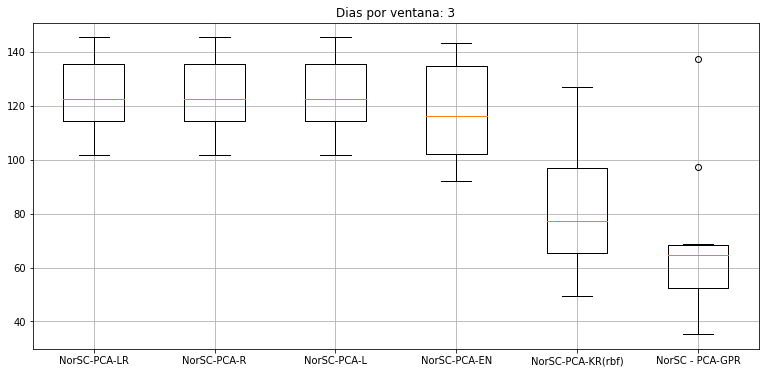

In [18]:
ventana_dias=3
plt.figure(figsize=[13,6])
plt.boxplot(maev[:,:,ventana_dias-3])
plt.xticks(ticks=np.arange(len(steps))+1, labels=label_model)
plt.title('Dias por ventana: '+str(ventana_dias))
plt.grid()
#plt.ylim([0,100])
plt.show()

#### Modelo Ganador



In [19]:
win_mae_wa

[35.37211740570204,
 39.28061936264392,
 40.81865263284563,
 30.497625730275175,
 44.00177616863235,
 42.633892821094484,
 33.99748755675213,
 35.22826680190277]

In [20]:
min=1e10
pos_min = 0
for i in range (len(win_mae_wa)):
    if (win_mae_wa[i] < min):
        min = win_mae_wa[i]
        pos_min = i
        
print('Mejor estimador: ',win_estimators_wa[pos_min])
print('Mejores Hyperparametros: ', win_hyperparams_wa[pos_min])
print('Mejor Error absoluto: ', min)
print('Mejor ventana regresor: ',pos_min+3,' dias')

Mejor estimador:  Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('rep',
                 PCA(copy=True, iterated_power='auto', n_components=0.5,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('reg',
                 GaussianProcessRegressor(alpha=0.001, copy_X_train=True,
                                          kernel=None, n_restarts_optimizer=0,
                                          normalize_y=False,
                                          optimizer='fmin_l_bfgs_b',
                                          random_state=None))],
         verbose=False)
Mejores Hyperparametros:  {'reg__alpha': 0.001, 'rep__n_components': 0.5}
Mejor Error absoluto:  30.497625730275175
Mejor ventana regresor:  6  dias


#### Entrenamiento de todo el set de datos con el Regresor ganador

mejor ventana entrenamiento:  3  dias


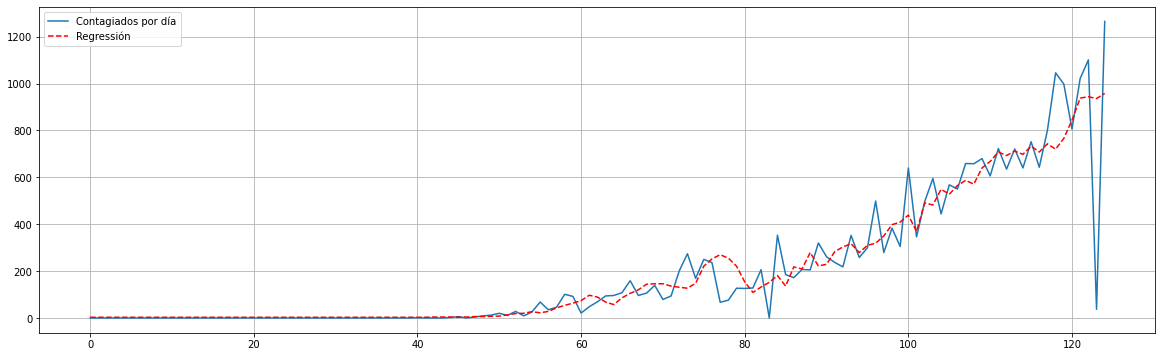

In [22]:
ii = Xd[Xd.columns[1]] == 'Colombia'
serie_d = np.append(0,np.diff(np.array(Xd.iloc[np.where(ii)[0][0],4:])))
min_mae_pred=1e10
best_window=0

for i in range (3,11):
    X,y = covid_win(serie_d,w=i)        
    model_covid_a = win_estimators_w[pos_min].fit(X,y)
    y_pred = model_covid_a.predict(X)
    y_pred_1 = []
    for j in range (len(X)):
        y_pred_1.append(int(y_pred[j]))
    if (mae(y_pred_1,y) < min_mae_pred):
        min_mae_pred=mae(y_pred_1,y)
        best_window=i
        
X,y = covid_win(serie_d,w=best_window)        
model_covid_a = win_estimators_w[pos_min].fit(X,y)
y_pred = model_covid_a.predict(X)
y_pred_1 = []
for j in range (len(X)):
    y_pred_1.append(int(y_pred[j]))

plt.figure(figsize=[20,6])
plt.plot(y,label='Contagiados por día')
plt.plot(y_pred_1,'r--', label='Regressión')
plt.legend()
plt.grid()
print("mejor ventana entrenamiento: ", best_window, ' dias')

In [24]:
print('Prediccion contagiados nuevos para',mañana,':',int(model_covid_a.predict(X[-2:-1])))

Prediccion contagiados nuevos para 2020-05-31 : 936


#### Guardar el modelo Obtenido 

In [25]:
# Guardar datos
savedata1 = {
    'mae':min,
    'best_model': win_estimators_wa[pos_min],
    'best_parameters': win_hyperparams_wa[pos_min]
}
dump(savedata1,'win_regressor_accum.joblib')

['win_regressor_accum.joblib']